# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin


- There are many times where you want to extract imporant features from high-dimensional data


- In essence, the goal is to compress data to some lower latent space where you can extract information


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/3-swissroll-unfolded.png?raw=true)


## Autoencoder

![imag](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder.png?raw=true)


- **Encoder** - Neural network that deconstructs the data into the most important statistical components


- **Embedding Layer(s)** - One or many layers were information is extracted


- **Decoder** - Neural network that translates the latent space to original dimensionality.


### Mathematical Objective


- Minimize the reconstruction loss based on some metric.
  - Mean squared error


- Good at avoiding influence of anomalies
  - Mean absolute error


- Good at capturing details within spectra


### Optimizers


- Standard optimizers like ADAM tend to be sufficient


- Can use more complex optimizers 2nd order, adhessian to optimize small models.


### Practical Objective


- Create an autoencoder that has performant reconstruction


- Create a low-dimensional and interpretable latent space
  - Reduce the dimensionality
  - Impose non-negativity contraints
  - Impose regularization
  - Impose sparsity
  - Impose constraints on the shape of the latent distribution
  - Impose soft-constraints that favor disentanglement


- Create a latent trajectory that is suitable for generation


# Imports Packages


In [1]:
# installs the tutorial package
!pip install m3_learning

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

from m3_learning.util.data_generators import generate_data
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function


# Generating Data


- We want to generate a hyperspectral image


- This can be done by taking the RGB values of an image and using them as parameters for a function


## Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [3]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255

## Displays the image


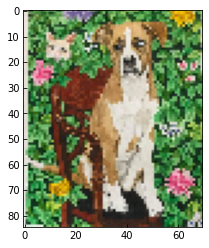

In [4]:
plt.imshow(image)

## Generating some data based on the image

### Define a non-linear function


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/generated.png?raw=true)


In [5]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )

In [6]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3), length=10, function=non_linear_fn)

In [7]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)

## Plots the generated data


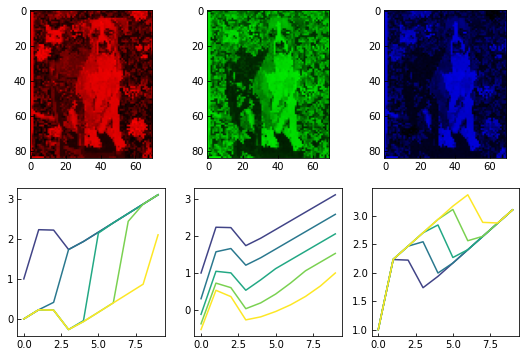

In [8]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)

## Building a Simple Autoencoder


### Defines the encoder and the decoder


In [9]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x

### Builds the autoencoder


In [10]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted

### Instantiates the model


In [11]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

You are running on a cuda


In [12]:
try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 12 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


### Builds the dataloader


In [13]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)

### Trains the model


In [14]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

100%|██████████| 19/19 [00:00<00:00, 526.88it/s]


Epoch 0, Train Loss: 2.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 633.33it/s]


Epoch 1, Train Loss: 1.9227
.............................


100%|██████████| 19/19 [00:00<00:00, 678.55it/s]


Epoch 2, Train Loss: 1.7698
.............................


100%|██████████| 19/19 [00:00<00:00, 730.84it/s]


Epoch 3, Train Loss: 1.6239
.............................


100%|██████████| 19/19 [00:00<00:00, 697.56it/s]


Epoch 4, Train Loss: 1.4843
.............................


100%|██████████| 19/19 [00:00<00:00, 758.57it/s]


Epoch 5, Train Loss: 1.3490
.............................


100%|██████████| 19/19 [00:00<00:00, 731.57it/s]


Epoch 6, Train Loss: 1.2190
.............................


100%|██████████| 19/19 [00:00<00:00, 704.52it/s]


Epoch 7, Train Loss: 1.0938
.............................


100%|██████████| 19/19 [00:00<00:00, 823.47it/s]


Epoch 8, Train Loss: 0.9760
.............................


100%|██████████| 19/19 [00:00<00:00, 593.79it/s]


Epoch 9, Train Loss: 0.8681
.............................


100%|██████████| 19/19 [00:00<00:00, 513.75it/s]


Epoch 10, Train Loss: 0.7671
.............................


100%|██████████| 19/19 [00:00<00:00, 772.29it/s]


Epoch 11, Train Loss: 0.6756
.............................


100%|██████████| 19/19 [00:00<00:00, 731.00it/s]


Epoch 12, Train Loss: 0.5942
.............................


100%|██████████| 19/19 [00:00<00:00, 760.00it/s]


Epoch 13, Train Loss: 0.5235
.............................


100%|██████████| 19/19 [00:00<00:00, 791.34it/s]


Epoch 14, Train Loss: 0.4614
.............................


100%|██████████| 19/19 [00:00<00:00, 607.27it/s]


Epoch 15, Train Loss: 0.4092
.............................


100%|██████████| 19/19 [00:00<00:00, 702.68it/s]


Epoch 16, Train Loss: 0.3649
.............................


100%|██████████| 19/19 [00:00<00:00, 760.25it/s]


Epoch 17, Train Loss: 0.3273
.............................


100%|██████████| 19/19 [00:00<00:00, 679.12it/s]


Epoch 18, Train Loss: 0.2960
.............................


100%|██████████| 19/19 [00:00<00:00, 730.59it/s]


Epoch 19, Train Loss: 0.2705
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 20, Train Loss: 0.2494
.............................


100%|██████████| 19/19 [00:00<00:00, 760.25it/s]


Epoch 21, Train Loss: 0.2325
.............................


100%|██████████| 19/19 [00:00<00:00, 633.51it/s]


Epoch 22, Train Loss: 0.2184
.............................


100%|██████████| 19/19 [00:00<00:00, 654.41it/s]


Epoch 23, Train Loss: 0.2071
.............................


100%|██████████| 19/19 [00:00<00:00, 703.25it/s]


Epoch 24, Train Loss: 0.1978
.............................


100%|██████████| 19/19 [00:00<00:00, 824.85it/s]


Epoch 25, Train Loss: 0.1903
.............................


100%|██████████| 19/19 [00:00<00:00, 632.40it/s]


Epoch 26, Train Loss: 0.1842
.............................


100%|██████████| 19/19 [00:00<00:00, 612.84it/s]


Epoch 27, Train Loss: 0.1791
.............................


100%|██████████| 19/19 [00:00<00:00, 677.52it/s]


Epoch 28, Train Loss: 0.1745
.............................


100%|██████████| 19/19 [00:00<00:00, 732.08it/s]


Epoch 29, Train Loss: 0.1708
.............................


100%|██████████| 19/19 [00:00<00:00, 760.63it/s]


Epoch 30, Train Loss: 0.1674
.............................


100%|██████████| 19/19 [00:00<00:00, 677.41it/s]


Epoch 31, Train Loss: 0.1639
.............................


100%|██████████| 19/19 [00:00<00:00, 677.53it/s]


Epoch 32, Train Loss: 0.1612
.............................


100%|██████████| 19/19 [00:00<00:00, 679.90it/s]


Epoch 33, Train Loss: 0.1584
.............................


100%|██████████| 19/19 [00:00<00:00, 431.84it/s]


Epoch 34, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 558.86it/s]


Epoch 35, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 729.83it/s]


Epoch 36, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 731.06it/s]


Epoch 37, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 758.46it/s]


Epoch 38, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 666.25it/s]


Epoch 39, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 678.70it/s]


Epoch 40, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 630.95it/s]


Epoch 41, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 654.25it/s]


Epoch 42, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 542.01it/s]


Epoch 43, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 725.55it/s]


Epoch 44, Train Loss: 0.1323
.............................


100%|██████████| 19/19 [00:00<00:00, 594.27it/s]


Epoch 45, Train Loss: 0.1300
.............................


100%|██████████| 19/19 [00:00<00:00, 760.19it/s]


Epoch 46, Train Loss: 0.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 791.65it/s]


Epoch 47, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 760.05it/s]


Epoch 48, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 760.01it/s]


Epoch 49, Train Loss: 0.1212
.............................


100%|██████████| 19/19 [00:00<00:00, 760.04it/s]


Epoch 50, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 759.97it/s]


Epoch 51, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 760.01it/s]


Epoch 52, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 730.78it/s]


Epoch 53, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 760.00it/s]


Epoch 54, Train Loss: 0.1107
.............................


100%|██████████| 19/19 [00:00<00:00, 760.00it/s]


Epoch 55, Train Loss: 0.1085
.............................


100%|██████████| 19/19 [00:00<00:00, 380.00it/s]


Epoch 56, Train Loss: 0.1067
.............................


100%|██████████| 19/19 [00:00<00:00, 758.05it/s]


Epoch 57, Train Loss: 0.1045
.............................


100%|██████████| 19/19 [00:00<00:00, 825.38it/s]


Epoch 58, Train Loss: 0.1024
.............................


100%|██████████| 19/19 [00:00<00:00, 791.49it/s]


Epoch 59, Train Loss: 0.1005
.............................


100%|██████████| 19/19 [00:00<00:00, 806.34it/s]


Epoch 60, Train Loss: 0.0985
.............................


100%|██████████| 19/19 [00:00<00:00, 646.72it/s]


Epoch 61, Train Loss: 0.0968
.............................


100%|██████████| 19/19 [00:00<00:00, 731.54it/s]


Epoch 62, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 791.68it/s]


Epoch 63, Train Loss: 0.0928
.............................


100%|██████████| 19/19 [00:00<00:00, 790.00it/s]


Epoch 64, Train Loss: 0.0913
.............................


100%|██████████| 19/19 [00:00<00:00, 791.68it/s]


Epoch 65, Train Loss: 0.0893
.............................


100%|██████████| 19/19 [00:00<00:00, 760.08it/s]


Epoch 66, Train Loss: 0.0874
.............................


100%|██████████| 19/19 [00:00<00:00, 790.57it/s]


Epoch 67, Train Loss: 0.0859
.............................


100%|██████████| 19/19 [00:00<00:00, 791.70it/s]


Epoch 68, Train Loss: 0.0840
.............................


100%|██████████| 19/19 [00:00<00:00, 758.93it/s]


Epoch 69, Train Loss: 0.0825
.............................


100%|██████████| 19/19 [00:00<00:00, 824.05it/s]


Epoch 70, Train Loss: 0.0808
.............................


100%|██████████| 19/19 [00:00<00:00, 678.56it/s]


Epoch 71, Train Loss: 0.0791
.............................


100%|██████████| 19/19 [00:00<00:00, 677.39it/s]


Epoch 72, Train Loss: 0.0775
.............................


100%|██████████| 19/19 [00:00<00:00, 702.51it/s]


Epoch 73, Train Loss: 0.0761
.............................


100%|██████████| 19/19 [00:00<00:00, 702.80it/s]


Epoch 74, Train Loss: 0.0747
.............................


100%|██████████| 19/19 [00:00<00:00, 654.54it/s]


Epoch 75, Train Loss: 0.0731
.............................


100%|██████████| 19/19 [00:00<00:00, 705.27it/s]


Epoch 76, Train Loss: 0.0716
.............................


100%|██████████| 19/19 [00:00<00:00, 729.06it/s]


Epoch 77, Train Loss: 0.0703
.............................


100%|██████████| 19/19 [00:00<00:00, 793.79it/s]


Epoch 78, Train Loss: 0.0689
.............................


100%|██████████| 19/19 [00:00<00:00, 632.38it/s]


Epoch 79, Train Loss: 0.0676
.............................


100%|██████████| 19/19 [00:00<00:00, 487.67it/s]


Epoch 80, Train Loss: 0.0663
.............................


100%|██████████| 19/19 [00:00<00:00, 791.71it/s]


Epoch 81, Train Loss: 0.0651
.............................


100%|██████████| 19/19 [00:00<00:00, 789.82it/s]


Epoch 82, Train Loss: 0.0638
.............................


100%|██████████| 19/19 [00:00<00:00, 826.77it/s]


Epoch 83, Train Loss: 0.0627
.............................


100%|██████████| 19/19 [00:00<00:00, 814.24it/s]


Epoch 84, Train Loss: 0.0617
.............................


100%|██████████| 19/19 [00:00<00:00, 730.73it/s]


Epoch 85, Train Loss: 0.0606
.............................


100%|██████████| 19/19 [00:00<00:00, 711.14it/s]


Epoch 86, Train Loss: 0.0595
.............................


100%|██████████| 19/19 [00:00<00:00, 720.47it/s]


Epoch 87, Train Loss: 0.0585
.............................


100%|██████████| 19/19 [00:00<00:00, 679.88it/s]


Epoch 88, Train Loss: 0.0574
.............................


100%|██████████| 19/19 [00:00<00:00, 789.47it/s]


Epoch 89, Train Loss: 0.0565
.............................


100%|██████████| 19/19 [00:00<00:00, 730.89it/s]


Epoch 90, Train Loss: 0.0554
.............................


100%|██████████| 19/19 [00:00<00:00, 756.68it/s]


Epoch 91, Train Loss: 0.0546
.............................


100%|██████████| 19/19 [00:00<00:00, 791.65it/s]


Epoch 92, Train Loss: 0.0537
.............................


100%|██████████| 19/19 [00:00<00:00, 652.34it/s]


Epoch 93, Train Loss: 0.0529
.............................


100%|██████████| 19/19 [00:00<00:00, 676.67it/s]


Epoch 94, Train Loss: 0.0521
.............................


100%|██████████| 19/19 [00:00<00:00, 676.68it/s]


Epoch 95, Train Loss: 0.0511
.............................


100%|██████████| 19/19 [00:00<00:00, 732.23it/s]


Epoch 96, Train Loss: 0.0505
.............................


100%|██████████| 19/19 [00:00<00:00, 704.86it/s]


Epoch 97, Train Loss: 0.0496
.............................


100%|██████████| 19/19 [00:00<00:00, 703.74it/s]


Epoch 98, Train Loss: 0.0489
.............................


100%|██████████| 19/19 [00:00<00:00, 813.60it/s]


Epoch 99, Train Loss: 0.0482
.............................


100%|██████████| 19/19 [00:00<00:00, 730.74it/s]


Epoch 100, Train Loss: 0.0474
.............................


100%|██████████| 19/19 [00:00<00:00, 824.93it/s]


Epoch 101, Train Loss: 0.0468
.............................


100%|██████████| 19/19 [00:00<00:00, 758.32it/s]


Epoch 102, Train Loss: 0.0462
.............................


100%|██████████| 19/19 [00:00<00:00, 732.27it/s]


Epoch 103, Train Loss: 0.0455
.............................


100%|██████████| 19/19 [00:00<00:00, 499.52it/s]


Epoch 104, Train Loss: 0.0448
.............................


100%|██████████| 19/19 [00:00<00:00, 729.77it/s]


Epoch 105, Train Loss: 0.0442
.............................


100%|██████████| 19/19 [00:00<00:00, 825.20it/s]


Epoch 106, Train Loss: 0.0436
.............................


100%|██████████| 19/19 [00:00<00:00, 824.51it/s]


Epoch 107, Train Loss: 0.0430
.............................


100%|██████████| 19/19 [00:00<00:00, 791.87it/s]


Epoch 108, Train Loss: 0.0423
.............................


100%|██████████| 19/19 [00:00<00:00, 593.71it/s]


Epoch 109, Train Loss: 0.0417
.............................


100%|██████████| 19/19 [00:00<00:00, 689.89it/s]


Epoch 110, Train Loss: 0.0412
.............................


100%|██████████| 19/19 [00:00<00:00, 633.19it/s]


Epoch 111, Train Loss: 0.0406
.............................


100%|██████████| 19/19 [00:00<00:00, 654.95it/s]


Epoch 112, Train Loss: 0.0401
.............................


100%|██████████| 19/19 [00:00<00:00, 558.43it/s]


Epoch 113, Train Loss: 0.0395
.............................


100%|██████████| 19/19 [00:00<00:00, 630.77it/s]


Epoch 114, Train Loss: 0.0390
.............................


100%|██████████| 19/19 [00:00<00:00, 703.47it/s]


Epoch 115, Train Loss: 0.0384
.............................


100%|██████████| 19/19 [00:00<00:00, 730.99it/s]


Epoch 116, Train Loss: 0.0379
.............................


100%|██████████| 19/19 [00:00<00:00, 649.93it/s]


Epoch 117, Train Loss: 0.0373
.............................


100%|██████████| 19/19 [00:00<00:00, 249.97it/s]


Epoch 118, Train Loss: 0.0368
.............................


100%|██████████| 19/19 [00:00<00:00, 706.80it/s]


Epoch 119, Train Loss: 0.0364
.............................


100%|██████████| 19/19 [00:00<00:00, 825.87it/s]


Epoch 120, Train Loss: 0.0358
.............................


100%|██████████| 19/19 [00:00<00:00, 828.23it/s]


Epoch 121, Train Loss: 0.0353
.............................


100%|██████████| 19/19 [00:00<00:00, 728.16it/s]


Epoch 122, Train Loss: 0.0349
.............................


100%|██████████| 19/19 [00:00<00:00, 630.42it/s]


Epoch 123, Train Loss: 0.0343
.............................


100%|██████████| 19/19 [00:00<00:00, 654.91it/s]


Epoch 124, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 592.79it/s]


Epoch 125, Train Loss: 0.0334
.............................


100%|██████████| 19/19 [00:00<00:00, 679.11it/s]


Epoch 126, Train Loss: 0.0329
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 127, Train Loss: 0.0325
.............................


100%|██████████| 19/19 [00:00<00:00, 758.51it/s]


Epoch 128, Train Loss: 0.0320
.............................


100%|██████████| 19/19 [00:00<00:00, 633.66it/s]


Epoch 129, Train Loss: 0.0316
.............................


100%|██████████| 19/19 [00:00<00:00, 678.96it/s]


Epoch 130, Train Loss: 0.0311
.............................


100%|██████████| 19/19 [00:00<00:00, 677.71it/s]


Epoch 131, Train Loss: 0.0306
.............................


100%|██████████| 19/19 [00:00<00:00, 790.40it/s]


Epoch 132, Train Loss: 0.0301
.............................


100%|██████████| 19/19 [00:00<00:00, 729.78it/s]


Epoch 133, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 729.53it/s]


Epoch 134, Train Loss: 0.0293
.............................


100%|██████████| 19/19 [00:00<00:00, 679.70it/s]


Epoch 135, Train Loss: 0.0289
.............................


100%|██████████| 19/19 [00:00<00:00, 760.72it/s]


Epoch 136, Train Loss: 0.0284
.............................


100%|██████████| 19/19 [00:00<00:00, 632.28it/s]


Epoch 137, Train Loss: 0.0280
.............................


100%|██████████| 19/19 [00:00<00:00, 654.20it/s]


Epoch 138, Train Loss: 0.0277
.............................


100%|██████████| 19/19 [00:00<00:00, 703.95it/s]


Epoch 139, Train Loss: 0.0272
.............................


100%|██████████| 19/19 [00:00<00:00, 790.53it/s]


Epoch 140, Train Loss: 0.0268
.............................


100%|██████████| 19/19 [00:00<00:00, 790.40it/s]


Epoch 141, Train Loss: 0.0265
.............................


100%|██████████| 19/19 [00:00<00:00, 702.73it/s]


Epoch 142, Train Loss: 0.0260
.............................


100%|██████████| 19/19 [00:00<00:00, 730.93it/s]


Epoch 143, Train Loss: 0.0257
.............................


100%|██████████| 19/19 [00:00<00:00, 702.51it/s]


Epoch 144, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 678.81it/s]


Epoch 145, Train Loss: 0.0249
.............................


100%|██████████| 19/19 [00:00<00:00, 593.72it/s]


Epoch 146, Train Loss: 0.0245
.............................


100%|██████████| 19/19 [00:00<00:00, 582.14it/s]


Epoch 147, Train Loss: 0.0242
.............................


100%|██████████| 19/19 [00:00<00:00, 655.21it/s]


Epoch 148, Train Loss: 0.0238
.............................


100%|██████████| 19/19 [00:00<00:00, 730.76it/s]


Epoch 149, Train Loss: 0.0235
.............................


100%|██████████| 19/19 [00:00<00:00, 728.96it/s]


Epoch 150, Train Loss: 0.0231
.............................


100%|██████████| 19/19 [00:00<00:00, 650.07it/s]


Epoch 151, Train Loss: 0.0228
.............................


100%|██████████| 19/19 [00:00<00:00, 575.75it/s]


Epoch 152, Train Loss: 0.0224
.............................


100%|██████████| 19/19 [00:00<00:00, 613.25it/s]


Epoch 153, Train Loss: 0.0221
.............................


100%|██████████| 19/19 [00:00<00:00, 678.57it/s]


Epoch 154, Train Loss: 0.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 677.56it/s]


Epoch 155, Train Loss: 0.0215
.............................


100%|██████████| 19/19 [00:00<00:00, 677.27it/s]


Epoch 156, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 633.36it/s]


Epoch 157, Train Loss: 0.0208
.............................


100%|██████████| 19/19 [00:00<00:00, 678.67it/s]


Epoch 158, Train Loss: 0.0206
.............................


100%|██████████| 19/19 [00:00<00:00, 758.66it/s]


Epoch 159, Train Loss: 0.0203
.............................


100%|██████████| 19/19 [00:00<00:00, 695.93it/s]


Epoch 160, Train Loss: 0.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 679.74it/s]


Epoch 161, Train Loss: 0.0197
.............................


100%|██████████| 19/19 [00:00<00:00, 574.65it/s]


Epoch 162, Train Loss: 0.0195
.............................


100%|██████████| 19/19 [00:00<00:00, 703.91it/s]


Epoch 163, Train Loss: 0.0192
.............................


100%|██████████| 19/19 [00:00<00:00, 593.74it/s]


Epoch 164, Train Loss: 0.0189
.............................


100%|██████████| 19/19 [00:00<00:00, 677.47it/s]


Epoch 165, Train Loss: 0.0187
.............................


100%|██████████| 19/19 [00:00<00:00, 729.39it/s]


Epoch 166, Train Loss: 0.0184
.............................


100%|██████████| 19/19 [00:00<00:00, 729.52it/s]


Epoch 167, Train Loss: 0.0182
.............................


100%|██████████| 19/19 [00:00<00:00, 684.81it/s]


Epoch 168, Train Loss: 0.0179
.............................


100%|██████████| 19/19 [00:00<00:00, 593.06it/s]


Epoch 169, Train Loss: 0.0177
.............................


100%|██████████| 19/19 [00:00<00:00, 653.46it/s]


Epoch 170, Train Loss: 0.0174
.............................


100%|██████████| 19/19 [00:00<00:00, 653.96it/s]


Epoch 171, Train Loss: 0.0172
.............................


100%|██████████| 19/19 [00:00<00:00, 678.65it/s]


Epoch 172, Train Loss: 0.0170
.............................


100%|██████████| 19/19 [00:00<00:00, 575.81it/s]


Epoch 173, Train Loss: 0.0167
.............................


100%|██████████| 19/19 [00:00<00:00, 678.45it/s]


Epoch 174, Train Loss: 0.0165
.............................


100%|██████████| 19/19 [00:00<00:00, 790.24it/s]


Epoch 175, Train Loss: 0.0163
.............................


100%|██████████| 19/19 [00:00<00:00, 654.26it/s]


Epoch 176, Train Loss: 0.0161
.............................


100%|██████████| 19/19 [00:00<00:00, 677.61it/s]


Epoch 177, Train Loss: 0.0159
.............................


100%|██████████| 19/19 [00:00<00:00, 594.59it/s]


Epoch 178, Train Loss: 0.0158
.............................


100%|██████████| 19/19 [00:00<00:00, 678.87it/s]


Epoch 179, Train Loss: 0.0155
.............................


100%|██████████| 19/19 [00:00<00:00, 633.56it/s]


Epoch 180, Train Loss: 0.0153
.............................


100%|██████████| 19/19 [00:00<00:00, 613.27it/s]


Epoch 181, Train Loss: 0.0151
.............................


100%|██████████| 19/19 [00:00<00:00, 703.46it/s]


Epoch 182, Train Loss: 0.0149
.............................


100%|██████████| 19/19 [00:00<00:00, 612.83it/s]


Epoch 183, Train Loss: 0.0147
.............................


100%|██████████| 19/19 [00:00<00:00, 730.67it/s]


Epoch 184, Train Loss: 0.0145
.............................


100%|██████████| 19/19 [00:00<00:00, 678.83it/s]


Epoch 185, Train Loss: 0.0143
.............................


100%|██████████| 19/19 [00:00<00:00, 633.51it/s]


Epoch 186, Train Loss: 0.0142
.............................


100%|██████████| 19/19 [00:00<00:00, 700.73it/s]


Epoch 187, Train Loss: 0.0140
.............................


100%|██████████| 19/19 [00:00<00:00, 761.28it/s]


Epoch 188, Train Loss: 0.0138
.............................


100%|██████████| 19/19 [00:00<00:00, 703.74it/s]


Epoch 189, Train Loss: 0.0136
.............................


100%|██████████| 19/19 [00:00<00:00, 702.68it/s]


Epoch 190, Train Loss: 0.0134
.............................


100%|██████████| 19/19 [00:00<00:00, 677.57it/s]


Epoch 191, Train Loss: 0.0133
.............................


100%|██████████| 19/19 [00:00<00:00, 679.23it/s]


Epoch 192, Train Loss: 0.0132
.............................


100%|██████████| 19/19 [00:00<00:00, 677.54it/s]


Epoch 193, Train Loss: 0.0130
.............................


100%|██████████| 19/19 [00:00<00:00, 594.02it/s]


Epoch 194, Train Loss: 0.0128
.............................


100%|██████████| 19/19 [00:00<00:00, 759.65it/s]


Epoch 195, Train Loss: 0.0127
.............................


100%|██████████| 19/19 [00:00<00:00, 611.11it/s]


Epoch 196, Train Loss: 0.0125
.............................


100%|██████████| 19/19 [00:00<00:00, 696.79it/s]


Epoch 197, Train Loss: 0.0123
.............................


100%|██████████| 19/19 [00:00<00:00, 678.68it/s]


Epoch 198, Train Loss: 0.0122
.............................


100%|██████████| 19/19 [00:00<00:00, 729.67it/s]


Epoch 199, Train Loss: 0.0120
.............................


100%|██████████| 19/19 [00:00<00:00, 703.57it/s]


Epoch 200, Train Loss: 0.0119
.............................


100%|██████████| 19/19 [00:00<00:00, 607.49it/s]


Epoch 201, Train Loss: 0.0117
.............................


100%|██████████| 19/19 [00:00<00:00, 631.46it/s]


Epoch 202, Train Loss: 0.0116
.............................


100%|██████████| 19/19 [00:00<00:00, 700.30it/s]


Epoch 203, Train Loss: 0.0114
.............................


100%|██████████| 19/19 [00:00<00:00, 791.40it/s]


Epoch 204, Train Loss: 0.0113
.............................


100%|██████████| 19/19 [00:00<00:00, 731.05it/s]


Epoch 205, Train Loss: 0.0112
.............................


100%|██████████| 19/19 [00:00<00:00, 631.92it/s]


Epoch 206, Train Loss: 0.0110
.............................


100%|██████████| 19/19 [00:00<00:00, 633.19it/s]


Epoch 207, Train Loss: 0.0108
.............................


100%|██████████| 19/19 [00:00<00:00, 702.63it/s]


Epoch 208, Train Loss: 0.0107
.............................


100%|██████████| 19/19 [00:00<00:00, 646.37it/s]


Epoch 209, Train Loss: 0.0106
.............................


100%|██████████| 19/19 [00:00<00:00, 758.59it/s]


Epoch 210, Train Loss: 0.0104
.............................


100%|██████████| 19/19 [00:00<00:00, 559.10it/s]


Epoch 211, Train Loss: 0.0104
.............................


100%|██████████| 19/19 [00:00<00:00, 729.52it/s]


Epoch 212, Train Loss: 0.0102
.............................


100%|██████████| 19/19 [00:00<00:00, 703.56it/s]


Epoch 213, Train Loss: 0.0101
.............................


100%|██████████| 19/19 [00:00<00:00, 656.14it/s]


Epoch 214, Train Loss: 0.0099
.............................


100%|██████████| 19/19 [00:00<00:00, 730.86it/s]


Epoch 215, Train Loss: 0.0098
.............................


100%|██████████| 19/19 [00:00<00:00, 703.49it/s]


Epoch 216, Train Loss: 0.0097
.............................


100%|██████████| 19/19 [00:00<00:00, 729.70it/s]


Epoch 217, Train Loss: 0.0095
.............................


100%|██████████| 19/19 [00:00<00:00, 633.45it/s]


Epoch 218, Train Loss: 0.0094
.............................


100%|██████████| 19/19 [00:00<00:00, 679.77it/s]


Epoch 219, Train Loss: 0.0093
.............................


100%|██████████| 19/19 [00:00<00:00, 730.99it/s]


Epoch 220, Train Loss: 0.0092
.............................


100%|██████████| 19/19 [00:00<00:00, 678.18it/s]


Epoch 221, Train Loss: 0.0091
.............................


100%|██████████| 19/19 [00:00<00:00, 633.32it/s]


Epoch 222, Train Loss: 0.0089
.............................


100%|██████████| 19/19 [00:00<00:00, 655.02it/s]


Epoch 223, Train Loss: 0.0088
.............................


100%|██████████| 19/19 [00:00<00:00, 593.39it/s]


Epoch 224, Train Loss: 0.0087
.............................


100%|██████████| 19/19 [00:00<00:00, 652.30it/s]


Epoch 225, Train Loss: 0.0086
.............................


100%|██████████| 19/19 [00:00<00:00, 755.87it/s]


Epoch 226, Train Loss: 0.0084
.............................


100%|██████████| 19/19 [00:00<00:00, 653.87it/s]


Epoch 227, Train Loss: 0.0083
.............................


100%|██████████| 19/19 [00:00<00:00, 675.19it/s]


Epoch 228, Train Loss: 0.0082
.............................


100%|██████████| 19/19 [00:00<00:00, 703.13it/s]


Epoch 229, Train Loss: 0.0081
.............................


100%|██████████| 19/19 [00:00<00:00, 679.62it/s]


Epoch 230, Train Loss: 0.0080
.............................


100%|██████████| 19/19 [00:00<00:00, 705.02it/s]


Epoch 231, Train Loss: 0.0079
.............................


100%|██████████| 19/19 [00:00<00:00, 702.43it/s]


Epoch 232, Train Loss: 0.0078
.............................


100%|██████████| 19/19 [00:00<00:00, 678.69it/s]


Epoch 233, Train Loss: 0.0077
.............................


100%|██████████| 19/19 [00:00<00:00, 612.00it/s]


Epoch 234, Train Loss: 0.0076
.............................


100%|██████████| 19/19 [00:00<00:00, 676.08it/s]


Epoch 235, Train Loss: 0.0075
.............................


100%|██████████| 19/19 [00:00<00:00, 731.37it/s]


Epoch 236, Train Loss: 0.0073
.............................


100%|██████████| 19/19 [00:00<00:00, 756.45it/s]


Epoch 237, Train Loss: 0.0073
.............................


100%|██████████| 19/19 [00:00<00:00, 594.20it/s]


Epoch 238, Train Loss: 0.0071
.............................


100%|██████████| 19/19 [00:00<00:00, 632.50it/s]


Epoch 239, Train Loss: 0.0070
.............................


100%|██████████| 19/19 [00:00<00:00, 655.07it/s]


Epoch 240, Train Loss: 0.0069
.............................


100%|██████████| 19/19 [00:00<00:00, 609.62it/s]


Epoch 241, Train Loss: 0.0069
.............................


100%|██████████| 19/19 [00:00<00:00, 633.36it/s]


Epoch 242, Train Loss: 0.0067
.............................


100%|██████████| 19/19 [00:00<00:00, 791.68it/s]


Epoch 243, Train Loss: 0.0066
.............................


100%|██████████| 19/19 [00:00<00:00, 513.08it/s]


Epoch 244, Train Loss: 0.0065
.............................


100%|██████████| 19/19 [00:00<00:00, 729.66it/s]


Epoch 245, Train Loss: 0.0064
.............................


100%|██████████| 19/19 [00:00<00:00, 677.25it/s]


Epoch 246, Train Loss: 0.0063
.............................


100%|██████████| 19/19 [00:00<00:00, 677.50it/s]


Epoch 247, Train Loss: 0.0062
.............................


100%|██████████| 19/19 [00:00<00:00, 653.19it/s]


Epoch 248, Train Loss: 0.0061
.............................


100%|██████████| 19/19 [00:00<00:00, 703.62it/s]


Epoch 249, Train Loss: 0.0060
.............................


100%|██████████| 19/19 [00:00<00:00, 730.90it/s]


Epoch 250, Train Loss: 0.0059
.............................


100%|██████████| 19/19 [00:00<00:00, 677.76it/s]


Epoch 251, Train Loss: 0.0058
.............................


100%|██████████| 19/19 [00:00<00:00, 655.30it/s]


Epoch 252, Train Loss: 0.0057
.............................


100%|██████████| 19/19 [00:00<00:00, 630.54it/s]


Epoch 253, Train Loss: 0.0056
.............................


100%|██████████| 19/19 [00:00<00:00, 543.72it/s]


Epoch 254, Train Loss: 0.0055
.............................


100%|██████████| 19/19 [00:00<00:00, 677.31it/s]


Epoch 255, Train Loss: 0.0055
.............................


100%|██████████| 19/19 [00:00<00:00, 703.55it/s]


Epoch 256, Train Loss: 0.0053
.............................


100%|██████████| 19/19 [00:00<00:00, 677.56it/s]


Epoch 257, Train Loss: 0.0053
.............................


100%|██████████| 19/19 [00:00<00:00, 655.59it/s]


Epoch 258, Train Loss: 0.0052
.............................


100%|██████████| 19/19 [00:00<00:00, 653.04it/s]


Epoch 259, Train Loss: 0.0050
.............................


100%|██████████| 19/19 [00:00<00:00, 655.21it/s]


Epoch 260, Train Loss: 0.0050
.............................


100%|██████████| 19/19 [00:00<00:00, 730.74it/s]


Epoch 261, Train Loss: 0.0049
.............................


100%|██████████| 19/19 [00:00<00:00, 759.98it/s]


Epoch 262, Train Loss: 0.0048
.............................


100%|██████████| 19/19 [00:00<00:00, 678.44it/s]


Epoch 263, Train Loss: 0.0047
.............................


100%|██████████| 19/19 [00:00<00:00, 558.07it/s]


Epoch 264, Train Loss: 0.0046
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 265, Train Loss: 0.0045
.............................


100%|██████████| 19/19 [00:00<00:00, 633.35it/s]


Epoch 266, Train Loss: 0.0044
.............................


100%|██████████| 19/19 [00:00<00:00, 612.33it/s]


Epoch 267, Train Loss: 0.0043
.............................


100%|██████████| 19/19 [00:00<00:00, 679.82it/s]


Epoch 268, Train Loss: 0.0043
.............................


100%|██████████| 19/19 [00:00<00:00, 703.64it/s]


Epoch 269, Train Loss: 0.0042
.............................


100%|██████████| 19/19 [00:00<00:00, 703.84it/s]


Epoch 270, Train Loss: 0.0041
.............................


100%|██████████| 19/19 [00:00<00:00, 702.48it/s]


Epoch 271, Train Loss: 0.0040
.............................


100%|██████████| 19/19 [00:00<00:00, 558.76it/s]


Epoch 272, Train Loss: 0.0039
.............................


100%|██████████| 19/19 [00:00<00:00, 702.33it/s]


Epoch 273, Train Loss: 0.0038
.............................


100%|██████████| 19/19 [00:00<00:00, 633.42it/s]


Epoch 274, Train Loss: 0.0037
.............................


100%|██████████| 19/19 [00:00<00:00, 703.77it/s]


Epoch 275, Train Loss: 0.0036
.............................


100%|██████████| 19/19 [00:00<00:00, 654.04it/s]


Epoch 276, Train Loss: 0.0036
.............................


100%|██████████| 19/19 [00:00<00:00, 587.52it/s]


Epoch 277, Train Loss: 0.0035
.............................


100%|██████████| 19/19 [00:00<00:00, 702.41it/s]


Epoch 278, Train Loss: 0.0034
.............................


100%|██████████| 19/19 [00:00<00:00, 655.27it/s]


Epoch 279, Train Loss: 0.0033
.............................


100%|██████████| 19/19 [00:00<00:00, 655.00it/s]


Epoch 280, Train Loss: 0.0032
.............................


100%|██████████| 19/19 [00:00<00:00, 592.74it/s]


Epoch 281, Train Loss: 0.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 282, Train Loss: 0.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 701.65it/s]


Epoch 283, Train Loss: 0.0030
.............................


100%|██████████| 19/19 [00:00<00:00, 677.58it/s]


Epoch 284, Train Loss: 0.0029
.............................


100%|██████████| 19/19 [00:00<00:00, 630.68it/s]


Epoch 285, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 593.76it/s]


Epoch 286, Train Loss: 0.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 593.74it/s]


Epoch 287, Train Loss: 0.0027
.............................


100%|██████████| 19/19 [00:00<00:00, 674.74it/s]


Epoch 288, Train Loss: 0.0026
.............................


100%|██████████| 19/19 [00:00<00:00, 703.51it/s]


Epoch 289, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 758.43it/s]


Epoch 290, Train Loss: 0.0025
.............................


100%|██████████| 19/19 [00:00<00:00, 679.19it/s]


Epoch 291, Train Loss: 0.0024
.............................


100%|██████████| 19/19 [00:00<00:00, 613.09it/s]


Epoch 292, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 704.03it/s]


Epoch 293, Train Loss: 0.0023
.............................


100%|██████████| 19/19 [00:00<00:00, 731.00it/s]


Epoch 294, Train Loss: 0.0022
.............................


100%|██████████| 19/19 [00:00<00:00, 703.02it/s]


Epoch 295, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 633.14it/s]


Epoch 296, Train Loss: 0.0021
.............................


100%|██████████| 19/19 [00:00<00:00, 677.58it/s]


Epoch 297, Train Loss: 0.0020
.............................


100%|██████████| 19/19 [00:00<00:00, 653.02it/s]


Epoch 298, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 610.41it/s]


Epoch 299, Train Loss: 0.0019
.............................


100%|██████████| 19/19 [00:00<00:00, 633.44it/s]


Epoch 300, Train Loss: 0.0018
.............................


100%|██████████| 19/19 [00:00<00:00, 395.85it/s]


Epoch 301, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 593.15it/s]


Epoch 302, Train Loss: 0.0017
.............................


100%|██████████| 19/19 [00:00<00:00, 592.93it/s]


Epoch 303, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 702.32it/s]


Epoch 304, Train Loss: 0.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 758.59it/s]


Epoch 305, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 633.31it/s]


Epoch 306, Train Loss: 0.0015
.............................


100%|██████████| 19/19 [00:00<00:00, 593.74it/s]


Epoch 307, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 471.12it/s]


Epoch 308, Train Loss: 0.0014
.............................


100%|██████████| 19/19 [00:00<00:00, 710.24it/s]


Epoch 309, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 673.12it/s]


Epoch 310, Train Loss: 0.0013
.............................


100%|██████████| 19/19 [00:00<00:00, 629.62it/s]


Epoch 311, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 633.71it/s]


Epoch 312, Train Loss: 0.0012
.............................


100%|██████████| 19/19 [00:00<00:00, 676.10it/s]


Epoch 313, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 678.48it/s]


Epoch 314, Train Loss: 0.0011
.............................


100%|██████████| 19/19 [00:00<00:00, 574.87it/s]


Epoch 315, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 729.69it/s]


Epoch 316, Train Loss: 0.0010
.............................


100%|██████████| 19/19 [00:00<00:00, 592.38it/s]


Epoch 317, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 633.20it/s]


Epoch 318, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 649.70it/s]


Epoch 319, Train Loss: 0.0009
.............................


100%|██████████| 19/19 [00:00<00:00, 675.50it/s]


Epoch 320, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 706.37it/s]


Epoch 321, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 677.54it/s]


Epoch 322, Train Loss: 0.0008
.............................


100%|██████████| 19/19 [00:00<00:00, 655.25it/s]


Epoch 323, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 633.40it/s]


Epoch 324, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 655.32it/s]


Epoch 325, Train Loss: 0.0007
.............................


100%|██████████| 19/19 [00:00<00:00, 704.76it/s]


Epoch 326, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 703.64it/s]


Epoch 327, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 678.67it/s]


Epoch 328, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 631.82it/s]


Epoch 329, Train Loss: 0.0006
.............................


100%|██████████| 19/19 [00:00<00:00, 594.02it/s]


Epoch 330, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 527.65it/s]


Epoch 331, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 593.60it/s]


Epoch 332, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 730.89it/s]


Epoch 333, Train Loss: 0.0005
.............................


100%|██████████| 19/19 [00:00<00:00, 612.87it/s]


Epoch 334, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 612.11it/s]


Epoch 335, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 677.59it/s]


Epoch 336, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 677.90it/s]


Epoch 337, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 731.05it/s]


Epoch 338, Train Loss: 0.0004
.............................


100%|██████████| 19/19 [00:00<00:00, 633.49it/s]


Epoch 339, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 575.81it/s]


Epoch 340, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 612.93it/s]


Epoch 341, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 677.52it/s]


Epoch 342, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 702.64it/s]


Epoch 343, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 653.23it/s]


Epoch 344, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 594.06it/s]


Epoch 345, Train Loss: 0.0003
.............................


100%|██████████| 19/19 [00:00<00:00, 702.64it/s]


Epoch 346, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 592.93it/s]


Epoch 347, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 703.79it/s]


Epoch 348, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 632.52it/s]


Epoch 349, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 677.49it/s]


Epoch 350, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 351, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 655.68it/s]


Epoch 352, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 788.94it/s]


Epoch 353, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 655.20it/s]


Epoch 354, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 633.16it/s]


Epoch 355, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 652.34it/s]


Epoch 356, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 675.45it/s]


Epoch 357, Train Loss: 0.0002
.............................


100%|██████████| 19/19 [00:00<00:00, 645.94it/s]


Epoch 358, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 671.38it/s]


Epoch 359, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 729.66it/s]


Epoch 360, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.74it/s]


Epoch 361, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 550.05it/s]


Epoch 362, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 623.20it/s]


Epoch 363, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.16it/s]


Epoch 364, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 527.74it/s]


Epoch 365, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 528.35it/s]


Epoch 366, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 486.51it/s]


Epoch 367, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 656.50it/s]


Epoch 368, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.43it/s]


Epoch 369, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 679.86it/s]


Epoch 370, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 487.21it/s]


Epoch 371, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.69it/s]


Epoch 372, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.14it/s]


Epoch 373, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.17it/s]


Epoch 374, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.39it/s]


Epoch 375, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.46it/s]


Epoch 376, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.46it/s]


Epoch 377, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.76it/s]


Epoch 378, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 679.48it/s]


Epoch 379, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 729.81it/s]


Epoch 380, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.38it/s]


Epoch 381, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 631.23it/s]


Epoch 382, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 652.77it/s]


Epoch 383, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.18it/s]


Epoch 384, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.56it/s]


Epoch 385, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 542.97it/s]


Epoch 386, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.36it/s]


Epoch 387, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.49it/s]


Epoch 388, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.61it/s]


Epoch 389, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 647.51it/s]


Epoch 390, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.47it/s]


Epoch 391, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.95it/s]


Epoch 392, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.23it/s]


Epoch 393, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.17it/s]


Epoch 394, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.04it/s]


Epoch 395, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 631.71it/s]


Epoch 396, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.91it/s]


Epoch 397, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 704.78it/s]


Epoch 398, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 760.16it/s]


Epoch 399, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 613.06it/s]


Epoch 400, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 631.75it/s]


Epoch 401, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.02it/s]


Epoch 402, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 576.32it/s]


Epoch 403, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.26it/s]


Epoch 404, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 456.89it/s]


Epoch 405, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.40it/s]


Epoch 406, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 725.57it/s]


Epoch 407, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 762.20it/s]


Epoch 408, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 759.80it/s]


Epoch 409, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 593.70it/s]


Epoch 410, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.04it/s]


Epoch 411, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 611.50it/s]


Epoch 412, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.59it/s]


Epoch 413, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.74it/s]


Epoch 414, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 791.39it/s]


Epoch 415, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.31it/s]


Epoch 416, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.60it/s]


Epoch 417, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.74it/s]


Epoch 418, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 729.67it/s]


Epoch 419, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 592.94it/s]


Epoch 420, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 513.90it/s]


Epoch 421, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 486.26it/s]


Epoch 422, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 789.65it/s]


Epoch 423, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 826.23it/s]


Epoch 424, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 791.54it/s]


Epoch 425, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 729.37it/s]


Epoch 426, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.62it/s]


Epoch 427, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.43it/s]


Epoch 428, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 613.28it/s]


Epoch 429, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 575.76it/s]


Epoch 430, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 704.62it/s]


Epoch 431, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 669.20it/s]


Epoch 432, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 613.10it/s]


Epoch 433, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.02it/s]


Epoch 434, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 528.04it/s]


Epoch 435, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.44it/s]


Epoch 436, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 575.82it/s]


Epoch 437, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.28it/s]


Epoch 438, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 594.13it/s]


Epoch 439, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.83it/s]


Epoch 440, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.26it/s]


Epoch 441, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 404.44it/s]


Epoch 442, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 593.47it/s]


Epoch 443, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 904.44it/s]


Epoch 444, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 803.24it/s]


Epoch 445, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 792.20it/s]


Epoch 446, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.41it/s]


Epoch 447, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 592.24it/s]


Epoch 448, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.48it/s]


Epoch 449, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.70it/s]


Epoch 450, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 542.33it/s]


Epoch 451, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.82it/s]


Epoch 452, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.08it/s]


Epoch 453, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 611.96it/s]


Epoch 454, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 593.82it/s]


Epoch 455, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.73it/s]


Epoch 456, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 593.94it/s]


Epoch 457, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 702.86it/s]


Epoch 458, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 567.10it/s]


Epoch 459, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 759.63it/s]


Epoch 460, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.38it/s]


Epoch 461, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.63it/s]


Epoch 462, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 422.03it/s]


Epoch 463, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 594.23it/s]


Epoch 464, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 791.02it/s]


Epoch 465, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 656.70it/s]


Epoch 466, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 728.68it/s]


Epoch 467, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 760.65it/s]


Epoch 468, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 679.89it/s]


Epoch 469, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.29it/s]


Epoch 470, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 654.03it/s]


Epoch 471, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.19it/s]


Epoch 472, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 730.64it/s]


Epoch 473, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.25it/s]


Epoch 474, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 632.26it/s]


Epoch 475, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 593.76it/s]


Epoch 476, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.45it/s]


Epoch 477, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.74it/s]


Epoch 478, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 612.41it/s]


Epoch 479, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.10it/s]


Epoch 480, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.65it/s]


Epoch 481, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.51it/s]


Epoch 482, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 422.77it/s]


Epoch 483, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.19it/s]


Epoch 484, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 701.86it/s]


Epoch 485, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 693.02it/s]


Epoch 486, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 575.82it/s]


Epoch 487, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 702.20it/s]


Epoch 488, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 685.54it/s]


Epoch 489, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 575.83it/s]


Epoch 490, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 678.68it/s]


Epoch 491, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 637.91it/s]


Epoch 492, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 703.85it/s]


Epoch 493, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 677.61it/s]


Epoch 494, Train Loss: 0.0001
.............................


100%|██████████| 19/19 [00:00<00:00, 633.12it/s]


Epoch 495, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.32it/s]


Epoch 496, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 633.30it/s]


Epoch 497, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 704.62it/s]


Epoch 498, Train Loss: 0.0000
.............................


100%|██████████| 19/19 [00:00<00:00, 593.30it/s]

Epoch 499, Train Loss: 0.0000
.............................


### Evaluates the model after training


In [15]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

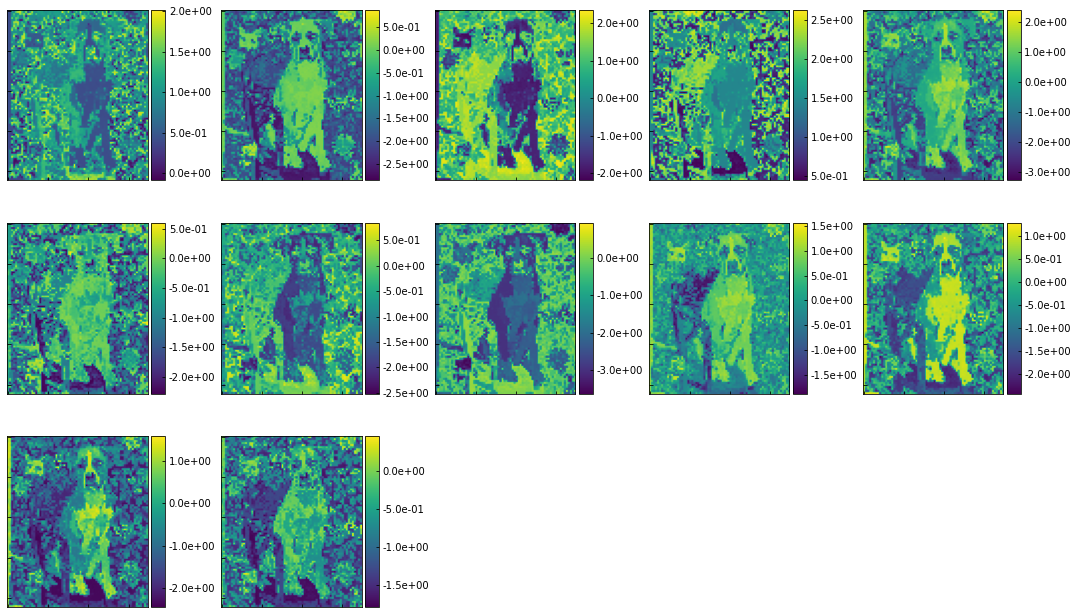

In [16]:
embedding_maps(encode, image)

- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


- We know that we only have 3 intrinsic latent variables


## Model with 3 latent variables

### Instantiates the model (3 latent variables)


In [17]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [18]:
summary(model, ((X_train.shape[1:])))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


- Encoder with 3 latent dimensions
- Decoder with with size 10 --> same as orignal spectral length
- Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample


In [19]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)

### Trains the model


In [20]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

100%|██████████| 19/19 [00:00<00:00, 431.13it/s]


Epoch 0, Train Loss: 2.3367
.............................


100%|██████████| 19/19 [00:00<00:00, 726.92it/s]


Epoch 1, Train Loss: 2.2750
.............................


100%|██████████| 19/19 [00:00<00:00, 756.33it/s]


Epoch 2, Train Loss: 2.2174
.............................


100%|██████████| 19/19 [00:00<00:00, 679.44it/s]


Epoch 3, Train Loss: 2.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 790.42it/s]


Epoch 4, Train Loss: 2.1008
.............................


100%|██████████| 19/19 [00:00<00:00, 790.17it/s]


Epoch 5, Train Loss: 2.0443
.............................


100%|██████████| 19/19 [00:00<00:00, 655.11it/s]


Epoch 6, Train Loss: 1.9859
.............................


100%|██████████| 19/19 [00:00<00:00, 678.57it/s]


Epoch 7, Train Loss: 1.9263
.............................


100%|██████████| 19/19 [00:00<00:00, 730.75it/s]


Epoch 8, Train Loss: 1.8688
.............................


100%|██████████| 19/19 [00:00<00:00, 758.68it/s]


Epoch 9, Train Loss: 1.8143
.............................


100%|██████████| 19/19 [00:00<00:00, 678.70it/s]


Epoch 10, Train Loss: 1.7565
.............................


100%|██████████| 19/19 [00:00<00:00, 758.57it/s]


Epoch 11, Train Loss: 1.7003
.............................


100%|██████████| 19/19 [00:00<00:00, 760.34it/s]


Epoch 12, Train Loss: 1.6473
.............................


100%|██████████| 19/19 [00:00<00:00, 703.66it/s]


Epoch 13, Train Loss: 1.5919
.............................


100%|██████████| 19/19 [00:00<00:00, 487.27it/s]


Epoch 14, Train Loss: 1.5402
.............................


100%|██████████| 19/19 [00:00<00:00, 758.65it/s]


Epoch 15, Train Loss: 1.4904
.............................


100%|██████████| 19/19 [00:00<00:00, 730.44it/s]


Epoch 16, Train Loss: 1.4413
.............................


100%|██████████| 19/19 [00:00<00:00, 760.04it/s]


Epoch 17, Train Loss: 1.3927
.............................


100%|██████████| 19/19 [00:00<00:00, 729.18it/s]


Epoch 18, Train Loss: 1.3465
.............................


100%|██████████| 19/19 [00:00<00:00, 791.89it/s]


Epoch 19, Train Loss: 1.3021
.............................


100%|██████████| 19/19 [00:00<00:00, 576.32it/s]


Epoch 20, Train Loss: 1.2592
.............................


100%|██████████| 19/19 [00:00<00:00, 702.47it/s]


Epoch 21, Train Loss: 1.2171
.............................


100%|██████████| 19/19 [00:00<00:00, 703.65it/s]


Epoch 22, Train Loss: 1.1775
.............................


100%|██████████| 19/19 [00:00<00:00, 703.94it/s]


Epoch 23, Train Loss: 1.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 758.45it/s]


Epoch 24, Train Loss: 1.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 704.51it/s]


Epoch 25, Train Loss: 1.0630
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 26, Train Loss: 1.0293
.............................


100%|██████████| 19/19 [00:00<00:00, 731.98it/s]


Epoch 27, Train Loss: 0.9960
.............................


100%|██████████| 19/19 [00:00<00:00, 730.42it/s]


Epoch 28, Train Loss: 0.9644
.............................


100%|██████████| 19/19 [00:00<00:00, 678.97it/s]


Epoch 29, Train Loss: 0.9337
.............................


100%|██████████| 19/19 [00:00<00:00, 703.87it/s]


Epoch 30, Train Loss: 0.9040
.............................


100%|██████████| 19/19 [00:00<00:00, 791.68it/s]


Epoch 31, Train Loss: 0.8737
.............................


100%|██████████| 19/19 [00:00<00:00, 729.58it/s]


Epoch 32, Train Loss: 0.8487
.............................


100%|██████████| 19/19 [00:00<00:00, 654.21it/s]


Epoch 33, Train Loss: 0.8216
.............................


100%|██████████| 19/19 [00:00<00:00, 678.83it/s]


Epoch 34, Train Loss: 0.7967
.............................


100%|██████████| 19/19 [00:00<00:00, 826.52it/s]


Epoch 35, Train Loss: 0.7724
.............................


100%|██████████| 19/19 [00:00<00:00, 730.52it/s]


Epoch 36, Train Loss: 0.7495
.............................


100%|██████████| 19/19 [00:00<00:00, 704.35it/s]


Epoch 37, Train Loss: 0.7253
.............................


100%|██████████| 19/19 [00:00<00:00, 738.30it/s]


Epoch 38, Train Loss: 0.7036
.............................


100%|██████████| 19/19 [00:00<00:00, 678.85it/s]


Epoch 39, Train Loss: 0.6820
.............................


100%|██████████| 19/19 [00:00<00:00, 703.54it/s]


Epoch 40, Train Loss: 0.6621
.............................


100%|██████████| 19/19 [00:00<00:00, 759.98it/s]


Epoch 41, Train Loss: 0.6420
.............................


100%|██████████| 19/19 [00:00<00:00, 703.75it/s]


Epoch 42, Train Loss: 0.6226
.............................


100%|██████████| 19/19 [00:00<00:00, 703.92it/s]


Epoch 43, Train Loss: 0.6028
.............................


100%|██████████| 19/19 [00:00<00:00, 824.74it/s]


Epoch 44, Train Loss: 0.5845
.............................


100%|██████████| 19/19 [00:00<00:00, 655.19it/s]


Epoch 45, Train Loss: 0.5671
.............................


100%|██████████| 19/19 [00:00<00:00, 731.04it/s]


Epoch 46, Train Loss: 0.5484
.............................


100%|██████████| 19/19 [00:00<00:00, 760.88it/s]


Epoch 47, Train Loss: 0.5322
.............................


100%|██████████| 19/19 [00:00<00:00, 678.59it/s]


Epoch 48, Train Loss: 0.5142
.............................


100%|██████████| 19/19 [00:00<00:00, 701.86it/s]


Epoch 49, Train Loss: 0.4982
.............................


100%|██████████| 19/19 [00:00<00:00, 701.51it/s]


Epoch 50, Train Loss: 0.4824
.............................


100%|██████████| 19/19 [00:00<00:00, 791.60it/s]


Epoch 51, Train Loss: 0.4666
.............................


100%|██████████| 19/19 [00:00<00:00, 678.45it/s]


Epoch 52, Train Loss: 0.4520
.............................


100%|██████████| 19/19 [00:00<00:00, 790.30it/s]


Epoch 53, Train Loss: 0.4370
.............................


100%|██████████| 19/19 [00:00<00:00, 730.95it/s]


Epoch 54, Train Loss: 0.4222
.............................


100%|██████████| 19/19 [00:00<00:00, 592.99it/s]


Epoch 55, Train Loss: 0.4089
.............................


100%|██████████| 19/19 [00:00<00:00, 730.81it/s]


Epoch 56, Train Loss: 0.3963
.............................


100%|██████████| 19/19 [00:00<00:00, 702.63it/s]


Epoch 57, Train Loss: 0.3831
.............................


100%|██████████| 19/19 [00:00<00:00, 791.49it/s]


Epoch 58, Train Loss: 0.3707
.............................


100%|██████████| 19/19 [00:00<00:00, 731.22it/s]


Epoch 59, Train Loss: 0.3587
.............................


100%|██████████| 19/19 [00:00<00:00, 759.77it/s]


Epoch 60, Train Loss: 0.3478
.............................


100%|██████████| 19/19 [00:00<00:00, 759.22it/s]


Epoch 61, Train Loss: 0.3368
.............................


100%|██████████| 19/19 [00:00<00:00, 703.62it/s]


Epoch 62, Train Loss: 0.3263
.............................


100%|██████████| 19/19 [00:00<00:00, 654.56it/s]


Epoch 63, Train Loss: 0.3157
.............................


100%|██████████| 19/19 [00:00<00:00, 790.51it/s]


Epoch 64, Train Loss: 0.3075
.............................


100%|██████████| 19/19 [00:00<00:00, 702.80it/s]


Epoch 65, Train Loss: 0.2977
.............................


100%|██████████| 19/19 [00:00<00:00, 759.01it/s]


Epoch 66, Train Loss: 0.2886
.............................


100%|██████████| 19/19 [00:00<00:00, 730.67it/s]


Epoch 67, Train Loss: 0.2808
.............................


100%|██████████| 19/19 [00:00<00:00, 729.76it/s]


Epoch 68, Train Loss: 0.2729
.............................


100%|██████████| 19/19 [00:00<00:00, 729.52it/s]


Epoch 69, Train Loss: 0.2657
.............................


100%|██████████| 19/19 [00:00<00:00, 678.74it/s]


Epoch 70, Train Loss: 0.2581
.............................


100%|██████████| 19/19 [00:00<00:00, 791.96it/s]


Epoch 71, Train Loss: 0.2517
.............................


100%|██████████| 19/19 [00:00<00:00, 653.98it/s]


Epoch 72, Train Loss: 0.2452
.............................


100%|██████████| 19/19 [00:00<00:00, 730.66it/s]


Epoch 73, Train Loss: 0.2392
.............................


100%|██████████| 19/19 [00:00<00:00, 759.16it/s]


Epoch 74, Train Loss: 0.2336
.............................


100%|██████████| 19/19 [00:00<00:00, 704.05it/s]


Epoch 75, Train Loss: 0.2277
.............................


100%|██████████| 19/19 [00:00<00:00, 633.46it/s]


Epoch 76, Train Loss: 0.2229
.............................


100%|██████████| 19/19 [00:00<00:00, 759.96it/s]


Epoch 77, Train Loss: 0.2180
.............................


100%|██████████| 19/19 [00:00<00:00, 677.40it/s]


Epoch 78, Train Loss: 0.2137
.............................


100%|██████████| 19/19 [00:00<00:00, 702.94it/s]


Epoch 79, Train Loss: 0.2092
.............................


100%|██████████| 19/19 [00:00<00:00, 730.59it/s]


Epoch 80, Train Loss: 0.2051
.............................


100%|██████████| 19/19 [00:00<00:00, 730.45it/s]


Epoch 81, Train Loss: 0.2015
.............................


100%|██████████| 19/19 [00:00<00:00, 703.67it/s]


Epoch 82, Train Loss: 0.1979
.............................


100%|██████████| 19/19 [00:00<00:00, 730.82it/s]


Epoch 83, Train Loss: 0.1948
.............................


100%|██████████| 19/19 [00:00<00:00, 731.78it/s]


Epoch 84, Train Loss: 0.1919
.............................


100%|██████████| 19/19 [00:00<00:00, 826.02it/s]


Epoch 85, Train Loss: 0.1892
.............................


100%|██████████| 19/19 [00:00<00:00, 731.49it/s]


Epoch 86, Train Loss: 0.1866
.............................


100%|██████████| 19/19 [00:00<00:00, 761.25it/s]


Epoch 87, Train Loss: 0.1843
.............................


100%|██████████| 19/19 [00:00<00:00, 758.73it/s]


Epoch 88, Train Loss: 0.1818
.............................


100%|██████████| 19/19 [00:00<00:00, 703.89it/s]


Epoch 89, Train Loss: 0.1795
.............................


100%|██████████| 19/19 [00:00<00:00, 612.95it/s]


Epoch 90, Train Loss: 0.1774
.............................


100%|██████████| 19/19 [00:00<00:00, 760.21it/s]


Epoch 91, Train Loss: 0.1757
.............................


100%|██████████| 19/19 [00:00<00:00, 703.97it/s]


Epoch 92, Train Loss: 0.1740
.............................


100%|██████████| 19/19 [00:00<00:00, 678.74it/s]


Epoch 93, Train Loss: 0.1726
.............................


100%|██████████| 19/19 [00:00<00:00, 703.80it/s]


Epoch 94, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 759.90it/s]


Epoch 95, Train Loss: 0.1693
.............................


100%|██████████| 19/19 [00:00<00:00, 527.87it/s]


Epoch 96, Train Loss: 0.1684
.............................


100%|██████████| 19/19 [00:00<00:00, 698.95it/s]


Epoch 97, Train Loss: 0.1670
.............................


100%|██████████| 19/19 [00:00<00:00, 632.57it/s]


Epoch 98, Train Loss: 0.1659
.............................


100%|██████████| 19/19 [00:00<00:00, 654.38it/s]


Epoch 99, Train Loss: 0.1652
.............................


100%|██████████| 19/19 [00:00<00:00, 593.63it/s]


Epoch 100, Train Loss: 0.1637
.............................


100%|██████████| 19/19 [00:00<00:00, 602.29it/s]


Epoch 101, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 592.63it/s]


Epoch 102, Train Loss: 0.1620
.............................


100%|██████████| 19/19 [00:00<00:00, 730.71it/s]


Epoch 103, Train Loss: 0.1611
.............................


100%|██████████| 19/19 [00:00<00:00, 678.72it/s]


Epoch 104, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 826.01it/s]


Epoch 105, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 655.40it/s]


Epoch 106, Train Loss: 0.1586
.............................


100%|██████████| 19/19 [00:00<00:00, 678.65it/s]


Epoch 107, Train Loss: 0.1584
.............................


100%|██████████| 19/19 [00:00<00:00, 677.58it/s]


Epoch 108, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 824.68it/s]


Epoch 109, Train Loss: 0.1568
.............................


100%|██████████| 19/19 [00:00<00:00, 655.34it/s]


Epoch 110, Train Loss: 0.1564
.............................


100%|██████████| 19/19 [00:00<00:00, 730.71it/s]


Epoch 111, Train Loss: 0.1558
.............................


100%|██████████| 19/19 [00:00<00:00, 792.09it/s]


Epoch 112, Train Loss: 0.1553
.............................


100%|██████████| 19/19 [00:00<00:00, 731.55it/s]


Epoch 113, Train Loss: 0.1545
.............................


100%|██████████| 19/19 [00:00<00:00, 703.75it/s]


Epoch 114, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 729.64it/s]


Epoch 115, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 702.45it/s]


Epoch 116, Train Loss: 0.1528
.............................


100%|██████████| 19/19 [00:00<00:00, 703.98it/s]


Epoch 117, Train Loss: 0.1524
.............................


100%|██████████| 19/19 [00:00<00:00, 791.79it/s]


Epoch 118, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 758.71it/s]


Epoch 119, Train Loss: 0.1517
.............................


100%|██████████| 19/19 [00:00<00:00, 702.42it/s]


Epoch 120, Train Loss: 0.1513
.............................


100%|██████████| 19/19 [00:00<00:00, 703.51it/s]


Epoch 121, Train Loss: 0.1507
.............................


100%|██████████| 19/19 [00:00<00:00, 729.44it/s]


Epoch 122, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 575.03it/s]


Epoch 123, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 593.63it/s]


Epoch 124, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 758.78it/s]


Epoch 125, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 678.42it/s]


Epoch 126, Train Loss: 0.1488
.............................


100%|██████████| 19/19 [00:00<00:00, 791.58it/s]


Epoch 127, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 703.85it/s]


Epoch 128, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 761.40it/s]


Epoch 129, Train Loss: 0.1476
.............................


100%|██████████| 19/19 [00:00<00:00, 729.74it/s]


Epoch 130, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 759.74it/s]


Epoch 131, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 678.96it/s]


Epoch 132, Train Loss: 0.1463
.............................


100%|██████████| 19/19 [00:00<00:00, 707.93it/s]


Epoch 133, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 760.11it/s]


Epoch 134, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 703.66it/s]


Epoch 135, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 702.67it/s]


Epoch 136, Train Loss: 0.1449
.............................


100%|██████████| 19/19 [00:00<00:00, 703.00it/s]


Epoch 137, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 729.72it/s]


Epoch 138, Train Loss: 0.1444
.............................


100%|██████████| 19/19 [00:00<00:00, 703.93it/s]


Epoch 139, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 655.15it/s]


Epoch 140, Train Loss: 0.1436
.............................


100%|██████████| 19/19 [00:00<00:00, 730.57it/s]


Epoch 141, Train Loss: 0.1436
.............................


100%|██████████| 19/19 [00:00<00:00, 679.14it/s]


Epoch 142, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 678.38it/s]


Epoch 143, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 655.27it/s]


Epoch 144, Train Loss: 0.1422
.............................


100%|██████████| 19/19 [00:00<00:00, 655.26it/s]


Epoch 145, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 730.59it/s]


Epoch 146, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 702.96it/s]


Epoch 147, Train Loss: 0.1413
.............................


100%|██████████| 19/19 [00:00<00:00, 702.45it/s]


Epoch 148, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 758.62it/s]


Epoch 149, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 729.62it/s]


Epoch 150, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 758.33it/s]


Epoch 151, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 762.37it/s]


Epoch 152, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 729.32it/s]


Epoch 153, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 760.85it/s]


Epoch 154, Train Loss: 0.1388
.............................


100%|██████████| 19/19 [00:00<00:00, 862.75it/s]


Epoch 155, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 760.37it/s]


Epoch 156, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 678.75it/s]


Epoch 157, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 759.97it/s]


Epoch 158, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 575.45it/s]


Epoch 159, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 730.76it/s]


Epoch 160, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 791.52it/s]


Epoch 161, Train Loss: 0.1369
.............................


100%|██████████| 19/19 [00:00<00:00, 759.90it/s]


Epoch 162, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 678.83it/s]


Epoch 163, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 791.69it/s]


Epoch 164, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 790.30it/s]


Epoch 165, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 758.63it/s]


Epoch 166, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 791.57it/s]


Epoch 167, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 679.42it/s]


Epoch 168, Train Loss: 0.1346
.............................


100%|██████████| 19/19 [00:00<00:00, 729.38it/s]


Epoch 169, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 760.37it/s]


Epoch 170, Train Loss: 0.1338
.............................


100%|██████████| 19/19 [00:00<00:00, 730.90it/s]


Epoch 171, Train Loss: 0.1335
.............................


100%|██████████| 19/19 [00:00<00:00, 677.55it/s]


Epoch 172, Train Loss: 0.1333
.............................


100%|██████████| 19/19 [00:00<00:00, 677.41it/s]


Epoch 173, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 702.67it/s]


Epoch 174, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 677.63it/s]


Epoch 175, Train Loss: 0.1323
.............................


100%|██████████| 19/19 [00:00<00:00, 729.53it/s]


Epoch 176, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 633.39it/s]


Epoch 177, Train Loss: 0.1320
.............................


100%|██████████| 19/19 [00:00<00:00, 732.25it/s]


Epoch 178, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 758.25it/s]


Epoch 179, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 740.55it/s]


Epoch 180, Train Loss: 0.1306
.............................


100%|██████████| 19/19 [00:00<00:00, 729.59it/s]


Epoch 181, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 729.47it/s]


Epoch 182, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 758.58it/s]


Epoch 183, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 678.37it/s]


Epoch 184, Train Loss: 0.1297
.............................


100%|██████████| 19/19 [00:00<00:00, 759.84it/s]


Epoch 185, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 679.33it/s]


Epoch 186, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 702.55it/s]


Epoch 187, Train Loss: 0.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 730.84it/s]


Epoch 188, Train Loss: 0.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 729.68it/s]


Epoch 189, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 702.47it/s]


Epoch 190, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 191, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 678.70it/s]


Epoch 192, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 729.57it/s]


Epoch 193, Train Loss: 0.1269
.............................


100%|██████████| 19/19 [00:00<00:00, 654.26it/s]


Epoch 194, Train Loss: 0.1267
.............................


100%|██████████| 19/19 [00:00<00:00, 679.04it/s]


Epoch 195, Train Loss: 0.1269
.............................


100%|██████████| 19/19 [00:00<00:00, 654.92it/s]


Epoch 196, Train Loss: 0.1265
.............................


100%|██████████| 19/19 [00:00<00:00, 826.45it/s]


Epoch 197, Train Loss: 0.1264
.............................


100%|██████████| 19/19 [00:00<00:00, 404.37it/s]


Epoch 198, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 824.59it/s]


Epoch 199, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 825.36it/s]


Epoch 200, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 760.92it/s]


Epoch 201, Train Loss: 0.1252
.............................


100%|██████████| 19/19 [00:00<00:00, 760.16it/s]


Epoch 202, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 677.61it/s]


Epoch 203, Train Loss: 0.1247
.............................


100%|██████████| 19/19 [00:00<00:00, 704.08it/s]


Epoch 204, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 703.59it/s]


Epoch 205, Train Loss: 0.1241
.............................


100%|██████████| 19/19 [00:00<00:00, 760.03it/s]


Epoch 206, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 678.64it/s]


Epoch 207, Train Loss: 0.1236
.............................


100%|██████████| 19/19 [00:00<00:00, 677.50it/s]


Epoch 208, Train Loss: 0.1235
.............................


100%|██████████| 19/19 [00:00<00:00, 704.71it/s]


Epoch 209, Train Loss: 0.1232
.............................


100%|██████████| 19/19 [00:00<00:00, 704.37it/s]


Epoch 210, Train Loss: 0.1230
.............................


100%|██████████| 19/19 [00:00<00:00, 633.29it/s]


Epoch 211, Train Loss: 0.1232
.............................


100%|██████████| 19/19 [00:00<00:00, 678.51it/s]


Epoch 212, Train Loss: 0.1228
.............................


100%|██████████| 19/19 [00:00<00:00, 678.63it/s]


Epoch 213, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 731.00it/s]


Epoch 214, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 655.24it/s]


Epoch 215, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 702.43it/s]


Epoch 216, Train Loss: 0.1217
.............................


100%|██████████| 19/19 [00:00<00:00, 732.69it/s]


Epoch 217, Train Loss: 0.1215
.............................


100%|██████████| 19/19 [00:00<00:00, 612.08it/s]


Epoch 218, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 730.78it/s]


Epoch 219, Train Loss: 0.1213
.............................


100%|██████████| 19/19 [00:00<00:00, 655.55it/s]


Epoch 220, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 679.20it/s]


Epoch 221, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 632.26it/s]


Epoch 222, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 704.07it/s]


Epoch 223, Train Loss: 0.1205
.............................


100%|██████████| 19/19 [00:00<00:00, 729.77it/s]


Epoch 224, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 677.84it/s]


Epoch 225, Train Loss: 0.1202
.............................


100%|██████████| 19/19 [00:00<00:00, 703.86it/s]


Epoch 226, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 645.49it/s]


Epoch 227, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 730.80it/s]


Epoch 228, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 703.69it/s]


Epoch 229, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 230, Train Loss: 0.1193
.............................


100%|██████████| 19/19 [00:00<00:00, 759.98it/s]


Epoch 231, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 232, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 730.74it/s]


Epoch 233, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 727.83it/s]


Epoch 234, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 678.60it/s]


Epoch 235, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 730.76it/s]


Epoch 236, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 731.39it/s]


Epoch 237, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 678.55it/s]


Epoch 238, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 678.60it/s]


Epoch 239, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 760.05it/s]


Epoch 240, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 760.03it/s]


Epoch 241, Train Loss: 0.1175
.............................


100%|██████████| 19/19 [00:00<00:00, 703.68it/s]


Epoch 242, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 760.03it/s]


Epoch 243, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 730.81it/s]


Epoch 244, Train Loss: 0.1171
.............................


100%|██████████| 19/19 [00:00<00:00, 754.01it/s]


Epoch 245, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 791.72it/s]


Epoch 246, Train Loss: 0.1165
.............................


100%|██████████| 19/19 [00:00<00:00, 612.78it/s]


Epoch 247, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 678.80it/s]


Epoch 248, Train Loss: 0.1164
.............................


100%|██████████| 19/19 [00:00<00:00, 611.72it/s]


Epoch 249, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 633.18it/s]


Epoch 250, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 678.29it/s]


Epoch 251, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 703.69it/s]


Epoch 252, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 705.17it/s]


Epoch 253, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 703.66it/s]


Epoch 254, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 730.80it/s]


Epoch 255, Train Loss: 0.1155
.............................


100%|██████████| 19/19 [00:00<00:00, 757.77it/s]


Epoch 256, Train Loss: 0.1155
.............................


100%|██████████| 19/19 [00:00<00:00, 653.61it/s]


Epoch 257, Train Loss: 0.1153
.............................


100%|██████████| 19/19 [00:00<00:00, 655.32it/s]


Epoch 258, Train Loss: 0.1151
.............................


100%|██████████| 19/19 [00:00<00:00, 791.25it/s]


Epoch 259, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 679.33it/s]


Epoch 260, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 703.68it/s]


Epoch 261, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 576.62it/s]


Epoch 262, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 632.28it/s]


Epoch 263, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 633.08it/s]


Epoch 264, Train Loss: 0.1144
.............................


100%|██████████| 19/19 [00:00<00:00, 653.96it/s]


Epoch 265, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 704.74it/s]


Epoch 266, Train Loss: 0.1141
.............................


100%|██████████| 19/19 [00:00<00:00, 678.89it/s]


Epoch 267, Train Loss: 0.1139
.............................


100%|██████████| 19/19 [00:00<00:00, 729.50it/s]


Epoch 268, Train Loss: 0.1139
.............................


100%|██████████| 19/19 [00:00<00:00, 655.25it/s]


Epoch 269, Train Loss: 0.1136
.............................


100%|██████████| 19/19 [00:00<00:00, 729.74it/s]


Epoch 270, Train Loss: 0.1136
.............................


100%|██████████| 19/19 [00:00<00:00, 729.64it/s]


Epoch 271, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 731.75it/s]


Epoch 272, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 759.94it/s]


Epoch 273, Train Loss: 0.1130
.............................


100%|██████████| 19/19 [00:00<00:00, 759.12it/s]


Epoch 274, Train Loss: 0.1131
.............................


100%|██████████| 19/19 [00:00<00:00, 655.74it/s]


Epoch 275, Train Loss: 0.1130
.............................


100%|██████████| 19/19 [00:00<00:00, 655.06it/s]


Epoch 276, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 611.07it/s]


Epoch 277, Train Loss: 0.1130
.............................


100%|██████████| 19/19 [00:00<00:00, 704.91it/s]


Epoch 278, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 677.59it/s]


Epoch 279, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 703.77it/s]


Epoch 280, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 678.52it/s]


Epoch 281, Train Loss: 0.1123
.............................


100%|██████████| 19/19 [00:00<00:00, 527.91it/s]


Epoch 282, Train Loss: 0.1121
.............................


100%|██████████| 19/19 [00:00<00:00, 611.29it/s]


Epoch 283, Train Loss: 0.1118
.............................


100%|██████████| 19/19 [00:00<00:00, 730.11it/s]


Epoch 284, Train Loss: 0.1118
.............................


100%|██████████| 19/19 [00:00<00:00, 792.20it/s]


Epoch 285, Train Loss: 0.1117
.............................


100%|██████████| 19/19 [00:00<00:00, 701.38it/s]


Epoch 286, Train Loss: 0.1119
.............................


100%|██████████| 19/19 [00:00<00:00, 703.26it/s]


Epoch 287, Train Loss: 0.1115
.............................


100%|██████████| 19/19 [00:00<00:00, 729.44it/s]


Epoch 288, Train Loss: 0.1115
.............................


100%|██████████| 19/19 [00:00<00:00, 729.86it/s]


Epoch 289, Train Loss: 0.1113
.............................


100%|██████████| 19/19 [00:00<00:00, 633.36it/s]


Epoch 290, Train Loss: 0.1111
.............................


100%|██████████| 19/19 [00:00<00:00, 678.18it/s]


Epoch 291, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 731.06it/s]


Epoch 292, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 791.70it/s]


Epoch 293, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 760.03it/s]


Epoch 294, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 791.66it/s]


Epoch 295, Train Loss: 0.1107
.............................


100%|██████████| 19/19 [00:00<00:00, 730.80it/s]


Epoch 296, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 703.76it/s]


Epoch 297, Train Loss: 0.1104
.............................


100%|██████████| 19/19 [00:00<00:00, 826.07it/s]


Epoch 298, Train Loss: 0.1101
.............................


100%|██████████| 19/19 [00:00<00:00, 730.77it/s]


Epoch 299, Train Loss: 0.1100
.............................


100%|██████████| 19/19 [00:00<00:00, 760.03it/s]


Epoch 300, Train Loss: 0.1101
.............................


100%|██████████| 19/19 [00:00<00:00, 703.75it/s]


Epoch 301, Train Loss: 0.1098
.............................


100%|██████████| 19/19 [00:00<00:00, 730.77it/s]


Epoch 302, Train Loss: 0.1098
.............................


100%|██████████| 19/19 [00:00<00:00, 826.10it/s]


Epoch 303, Train Loss: 0.1098
.............................


100%|██████████| 19/19 [00:00<00:00, 655.81it/s]


Epoch 304, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 631.74it/s]


Epoch 305, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 626.60it/s]


Epoch 306, Train Loss: 0.1093
.............................


100%|██████████| 19/19 [00:00<00:00, 673.90it/s]


Epoch 307, Train Loss: 0.1090
.............................


100%|██████████| 19/19 [00:00<00:00, 790.15it/s]


Epoch 308, Train Loss: 0.1091
.............................


100%|██████████| 19/19 [00:00<00:00, 633.46it/s]


Epoch 309, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 676.00it/s]


Epoch 310, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 653.60it/s]


Epoch 311, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 633.19it/s]


Epoch 312, Train Loss: 0.1084
.............................


100%|██████████| 19/19 [00:00<00:00, 609.69it/s]


Epoch 313, Train Loss: 0.1086
.............................


100%|██████████| 19/19 [00:00<00:00, 624.28it/s]


Epoch 314, Train Loss: 0.1086
.............................


100%|██████████| 19/19 [00:00<00:00, 702.66it/s]


Epoch 315, Train Loss: 0.1086
.............................


100%|██████████| 19/19 [00:00<00:00, 558.85it/s]


Epoch 316, Train Loss: 0.1082
.............................


100%|██████████| 19/19 [00:00<00:00, 558.83it/s]


Epoch 317, Train Loss: 0.1082
.............................


100%|██████████| 19/19 [00:00<00:00, 678.54it/s]


Epoch 318, Train Loss: 0.1080
.............................


100%|██████████| 19/19 [00:00<00:00, 674.58it/s]


Epoch 319, Train Loss: 0.1080
.............................


100%|██████████| 19/19 [00:00<00:00, 591.29it/s]


Epoch 320, Train Loss: 0.1078
.............................


100%|██████████| 19/19 [00:00<00:00, 612.94it/s]


Epoch 321, Train Loss: 0.1076
.............................


100%|██████████| 19/19 [00:00<00:00, 633.36it/s]


Epoch 322, Train Loss: 0.1074
.............................


100%|██████████| 19/19 [00:00<00:00, 680.31it/s]


Epoch 323, Train Loss: 0.1077
.............................


100%|██████████| 19/19 [00:00<00:00, 681.74it/s]


Epoch 324, Train Loss: 0.1075
.............................


100%|██████████| 19/19 [00:00<00:00, 729.33it/s]


Epoch 325, Train Loss: 0.1074
.............................


100%|██████████| 19/19 [00:00<00:00, 678.37it/s]


Epoch 326, Train Loss: 0.1073
.............................


100%|██████████| 19/19 [00:00<00:00, 613.38it/s]


Epoch 327, Train Loss: 0.1070
.............................


100%|██████████| 19/19 [00:00<00:00, 611.89it/s]


Epoch 328, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 527.24it/s]


Epoch 329, Train Loss: 0.1070
.............................


100%|██████████| 19/19 [00:00<00:00, 630.87it/s]


Epoch 330, Train Loss: 0.1070
.............................


100%|██████████| 19/19 [00:00<00:00, 700.51it/s]


Epoch 331, Train Loss: 0.1067
.............................


100%|██████████| 19/19 [00:00<00:00, 527.06it/s]


Epoch 332, Train Loss: 0.1067
.............................


100%|██████████| 19/19 [00:00<00:00, 678.79it/s]


Epoch 333, Train Loss: 0.1063
.............................


100%|██████████| 19/19 [00:00<00:00, 679.61it/s]


Epoch 334, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 730.75it/s]


Epoch 335, Train Loss: 0.1064
.............................


100%|██████████| 19/19 [00:00<00:00, 679.93it/s]


Epoch 336, Train Loss: 0.1061
.............................


100%|██████████| 19/19 [00:00<00:00, 633.08it/s]


Epoch 337, Train Loss: 0.1061
.............................


100%|██████████| 19/19 [00:00<00:00, 654.27it/s]


Epoch 338, Train Loss: 0.1062
.............................


100%|██████████| 19/19 [00:00<00:00, 678.54it/s]


Epoch 339, Train Loss: 0.1061
.............................


100%|██████████| 19/19 [00:00<00:00, 679.03it/s]


Epoch 340, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 760.35it/s]


Epoch 341, Train Loss: 0.1059
.............................


100%|██████████| 19/19 [00:00<00:00, 730.19it/s]


Epoch 342, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 703.66it/s]


Epoch 343, Train Loss: 0.1057
.............................


100%|██████████| 19/19 [00:00<00:00, 729.70it/s]


Epoch 344, Train Loss: 0.1057
.............................


100%|██████████| 19/19 [00:00<00:00, 678.48it/s]


Epoch 345, Train Loss: 0.1053
.............................


100%|██████████| 19/19 [00:00<00:00, 678.47it/s]


Epoch 346, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 632.30it/s]


Epoch 347, Train Loss: 0.1053
.............................


100%|██████████| 19/19 [00:00<00:00, 703.90it/s]


Epoch 348, Train Loss: 0.1051
.............................


100%|██████████| 19/19 [00:00<00:00, 669.88it/s]


Epoch 349, Train Loss: 0.1051
.............................


100%|██████████| 19/19 [00:00<00:00, 703.59it/s]


Epoch 350, Train Loss: 0.1050
.............................


100%|██████████| 19/19 [00:00<00:00, 632.32it/s]


Epoch 351, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 655.16it/s]


Epoch 352, Train Loss: 0.1047
.............................


100%|██████████| 19/19 [00:00<00:00, 702.53it/s]


Epoch 353, Train Loss: 0.1047
.............................


100%|██████████| 19/19 [00:00<00:00, 703.75it/s]


Epoch 354, Train Loss: 0.1044
.............................


100%|██████████| 19/19 [00:00<00:00, 677.28it/s]


Epoch 355, Train Loss: 0.1045
.............................


100%|██████████| 19/19 [00:00<00:00, 654.20it/s]


Epoch 356, Train Loss: 0.1044
.............................


100%|██████████| 19/19 [00:00<00:00, 655.14it/s]


Epoch 357, Train Loss: 0.1047
.............................


100%|██████████| 19/19 [00:00<00:00, 654.15it/s]


Epoch 358, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 760.33it/s]


Epoch 359, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 654.71it/s]


Epoch 360, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 731.13it/s]


Epoch 361, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 703.31it/s]


Epoch 362, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 632.31it/s]


Epoch 363, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 730.82it/s]


Epoch 364, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 718.82it/s]


Epoch 365, Train Loss: 0.1036
.............................


100%|██████████| 19/19 [00:00<00:00, 703.45it/s]


Epoch 366, Train Loss: 0.1038
.............................


100%|██████████| 19/19 [00:00<00:00, 654.99it/s]


Epoch 367, Train Loss: 0.1035
.............................


100%|██████████| 19/19 [00:00<00:00, 703.77it/s]


Epoch 368, Train Loss: 0.1036
.............................


100%|██████████| 19/19 [00:00<00:00, 655.56it/s]


Epoch 369, Train Loss: 0.1034
.............................


100%|██████████| 19/19 [00:00<00:00, 633.41it/s]


Epoch 370, Train Loss: 0.1031
.............................


100%|██████████| 19/19 [00:00<00:00, 677.83it/s]


Epoch 371, Train Loss: 0.1031
.............................


100%|██████████| 19/19 [00:00<00:00, 732.44it/s]


Epoch 372, Train Loss: 0.1030
.............................


100%|██████████| 19/19 [00:00<00:00, 730.33it/s]


Epoch 373, Train Loss: 0.1030
.............................


100%|██████████| 19/19 [00:00<00:00, 730.29it/s]


Epoch 374, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 760.04it/s]


Epoch 375, Train Loss: 0.1028
.............................


100%|██████████| 19/19 [00:00<00:00, 703.77it/s]


Epoch 376, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 760.02it/s]


Epoch 377, Train Loss: 0.1024
.............................


100%|██████████| 19/19 [00:00<00:00, 791.72it/s]


Epoch 378, Train Loss: 0.1025
.............................


100%|██████████| 19/19 [00:00<00:00, 702.16it/s]


Epoch 379, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 702.62it/s]


Epoch 380, Train Loss: 0.1026
.............................


100%|██████████| 19/19 [00:00<00:00, 679.67it/s]


Epoch 381, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 702.46it/s]


Epoch 382, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 654.92it/s]


Epoch 383, Train Loss: 0.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 654.96it/s]


Epoch 384, Train Loss: 0.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 703.02it/s]


Epoch 385, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 703.93it/s]


Epoch 386, Train Loss: 0.1019
.............................


100%|██████████| 19/19 [00:00<00:00, 654.58it/s]


Epoch 387, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 620.15it/s]


Epoch 388, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 576.78it/s]


Epoch 389, Train Loss: 0.1018
.............................


100%|██████████| 19/19 [00:00<00:00, 655.23it/s]


Epoch 390, Train Loss: 0.1014
.............................


100%|██████████| 19/19 [00:00<00:00, 575.60it/s]


Epoch 391, Train Loss: 0.1013
.............................


100%|██████████| 19/19 [00:00<00:00, 662.44it/s]


Epoch 392, Train Loss: 0.1015
.............................


100%|██████████| 19/19 [00:00<00:00, 542.17it/s]


Epoch 393, Train Loss: 0.1012
.............................


100%|██████████| 19/19 [00:00<00:00, 730.01it/s]


Epoch 394, Train Loss: 0.1013
.............................


100%|██████████| 19/19 [00:00<00:00, 634.01it/s]


Epoch 395, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 593.91it/s]


Epoch 396, Train Loss: 0.1009
.............................


100%|██████████| 19/19 [00:00<00:00, 704.96it/s]


Epoch 397, Train Loss: 0.1008
.............................


100%|██████████| 19/19 [00:00<00:00, 594.59it/s]


Epoch 398, Train Loss: 0.1009
.............................


100%|██████████| 19/19 [00:00<00:00, 634.25it/s]


Epoch 399, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 729.64it/s]


Epoch 400, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 612.42it/s]


Epoch 401, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 703.51it/s]


Epoch 402, Train Loss: 0.1004
.............................


100%|██████████| 19/19 [00:00<00:00, 655.00it/s]


Epoch 403, Train Loss: 0.1005
.............................


100%|██████████| 19/19 [00:00<00:00, 678.75it/s]


Epoch 404, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 730.19it/s]


Epoch 405, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 655.27it/s]


Epoch 406, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 677.31it/s]


Epoch 407, Train Loss: 0.1002
.............................


100%|██████████| 19/19 [00:00<00:00, 559.33it/s]


Epoch 408, Train Loss: 0.1000
.............................


100%|██████████| 19/19 [00:00<00:00, 632.06it/s]


Epoch 409, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 613.05it/s]


Epoch 410, Train Loss: 0.0998
.............................


100%|██████████| 19/19 [00:00<00:00, 558.96it/s]


Epoch 411, Train Loss: 0.0996
.............................


100%|██████████| 19/19 [00:00<00:00, 757.99it/s]


Epoch 412, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 702.34it/s]


Epoch 413, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 576.22it/s]


Epoch 414, Train Loss: 0.0994
.............................


100%|██████████| 19/19 [00:00<00:00, 730.27it/s]


Epoch 415, Train Loss: 0.0994
.............................


100%|██████████| 19/19 [00:00<00:00, 633.43it/s]


Epoch 416, Train Loss: 0.0993
.............................


100%|██████████| 19/19 [00:00<00:00, 632.29it/s]


Epoch 417, Train Loss: 0.0992
.............................


100%|██████████| 19/19 [00:00<00:00, 613.39it/s]


Epoch 418, Train Loss: 0.0995
.............................


100%|██████████| 19/19 [00:00<00:00, 633.14it/s]


Epoch 419, Train Loss: 0.0991
.............................


100%|██████████| 19/19 [00:00<00:00, 575.07it/s]


Epoch 420, Train Loss: 0.0989
.............................


100%|██████████| 19/19 [00:00<00:00, 678.45it/s]


Epoch 421, Train Loss: 0.0990
.............................


100%|██████████| 19/19 [00:00<00:00, 613.43it/s]


Epoch 422, Train Loss: 0.0990
.............................


100%|██████████| 19/19 [00:00<00:00, 678.10it/s]


Epoch 423, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 729.62it/s]


Epoch 424, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 575.54it/s]


Epoch 425, Train Loss: 0.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 702.74it/s]


Epoch 426, Train Loss: 0.0985
.............................


100%|██████████| 19/19 [00:00<00:00, 654.22it/s]


Epoch 427, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 452.59it/s]


Epoch 428, Train Loss: 0.0983
.............................


100%|██████████| 19/19 [00:00<00:00, 654.06it/s]


Epoch 429, Train Loss: 0.0981
.............................


100%|██████████| 19/19 [00:00<00:00, 614.11it/s]


Epoch 430, Train Loss: 0.0981
.............................


100%|██████████| 19/19 [00:00<00:00, 731.14it/s]


Epoch 431, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 633.71it/s]


Epoch 432, Train Loss: 0.0977
.............................


100%|██████████| 19/19 [00:00<00:00, 655.14it/s]


Epoch 433, Train Loss: 0.0979
.............................


100%|██████████| 19/19 [00:00<00:00, 633.64it/s]


Epoch 434, Train Loss: 0.0977
.............................


100%|██████████| 19/19 [00:00<00:00, 655.19it/s]


Epoch 435, Train Loss: 0.0976
.............................


100%|██████████| 19/19 [00:00<00:00, 655.11it/s]


Epoch 436, Train Loss: 0.0975
.............................


100%|██████████| 19/19 [00:00<00:00, 655.16it/s]


Epoch 437, Train Loss: 0.0974
.............................


100%|██████████| 19/19 [00:00<00:00, 730.05it/s]


Epoch 438, Train Loss: 0.0972
.............................


100%|██████████| 19/19 [00:00<00:00, 565.85it/s]


Epoch 439, Train Loss: 0.0972
.............................


100%|██████████| 19/19 [00:00<00:00, 702.37it/s]


Epoch 440, Train Loss: 0.0973
.............................


100%|██████████| 19/19 [00:00<00:00, 613.10it/s]


Epoch 441, Train Loss: 0.0970
.............................


100%|██████████| 19/19 [00:00<00:00, 654.03it/s]


Epoch 442, Train Loss: 0.0969
.............................


100%|██████████| 19/19 [00:00<00:00, 558.22it/s]


Epoch 443, Train Loss: 0.0970
.............................


100%|██████████| 19/19 [00:00<00:00, 654.99it/s]


Epoch 444, Train Loss: 0.0967
.............................


100%|██████████| 19/19 [00:00<00:00, 654.18it/s]


Epoch 445, Train Loss: 0.0967
.............................


100%|██████████| 19/19 [00:00<00:00, 654.05it/s]


Epoch 446, Train Loss: 0.0964
.............................


100%|██████████| 19/19 [00:00<00:00, 676.56it/s]


Epoch 447, Train Loss: 0.0964
.............................


100%|██████████| 19/19 [00:00<00:00, 703.86it/s]


Epoch 448, Train Loss: 0.0963
.............................


100%|██████████| 19/19 [00:00<00:00, 632.61it/s]


Epoch 449, Train Loss: 0.0963
.............................


100%|██████████| 19/19 [00:00<00:00, 760.24it/s]


Epoch 450, Train Loss: 0.0964
.............................


100%|██████████| 19/19 [00:00<00:00, 543.05it/s]


Epoch 451, Train Loss: 0.0960
.............................


100%|██████████| 19/19 [00:00<00:00, 757.71it/s]


Epoch 452, Train Loss: 0.0959
.............................


100%|██████████| 19/19 [00:00<00:00, 791.66it/s]


Epoch 453, Train Loss: 0.0959
.............................


100%|██████████| 19/19 [00:00<00:00, 760.82it/s]


Epoch 454, Train Loss: 0.0958
.............................


100%|██████████| 19/19 [00:00<00:00, 731.12it/s]


Epoch 455, Train Loss: 0.0957
.............................


100%|██████████| 19/19 [00:00<00:00, 793.17it/s]


Epoch 456, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 792.10it/s]


Epoch 457, Train Loss: 0.0956
.............................


100%|██████████| 19/19 [00:00<00:00, 702.84it/s]


Epoch 458, Train Loss: 0.0954
.............................


100%|██████████| 19/19 [00:00<00:00, 826.10it/s]


Epoch 459, Train Loss: 0.0952
.............................


100%|██████████| 19/19 [00:00<00:00, 678.62it/s]


Epoch 460, Train Loss: 0.0951
.............................


100%|██████████| 19/19 [00:00<00:00, 703.72it/s]


Epoch 461, Train Loss: 0.0950
.............................


100%|██████████| 19/19 [00:00<00:00, 702.78it/s]


Epoch 462, Train Loss: 0.0950
.............................


100%|██████████| 19/19 [00:00<00:00, 755.74it/s]


Epoch 463, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 702.95it/s]


Epoch 464, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 864.48it/s]


Epoch 465, Train Loss: 0.0948
.............................


100%|██████████| 19/19 [00:00<00:00, 760.00it/s]


Epoch 466, Train Loss: 0.0945
.............................


100%|██████████| 19/19 [00:00<00:00, 761.54it/s]


Epoch 467, Train Loss: 0.0944
.............................


100%|██████████| 19/19 [00:00<00:00, 792.21it/s]


Epoch 468, Train Loss: 0.0943
.............................


100%|██████████| 19/19 [00:00<00:00, 453.01it/s]


Epoch 469, Train Loss: 0.0942
.............................


100%|██████████| 19/19 [00:00<00:00, 702.85it/s]


Epoch 470, Train Loss: 0.0941
.............................


100%|██████████| 19/19 [00:00<00:00, 826.04it/s]


Epoch 471, Train Loss: 0.0939
.............................


100%|██████████| 19/19 [00:00<00:00, 863.32it/s]


Epoch 472, Train Loss: 0.0939
.............................


100%|██████████| 19/19 [00:00<00:00, 679.14it/s]


Epoch 473, Train Loss: 0.0937
.............................


100%|██████████| 19/19 [00:00<00:00, 678.97it/s]


Epoch 474, Train Loss: 0.0935
.............................


100%|██████████| 19/19 [00:00<00:00, 632.29it/s]


Epoch 475, Train Loss: 0.0934
.............................


100%|██████████| 19/19 [00:00<00:00, 654.05it/s]


Epoch 476, Train Loss: 0.0935
.............................


100%|██████████| 19/19 [00:00<00:00, 654.40it/s]


Epoch 477, Train Loss: 0.0933
.............................


100%|██████████| 19/19 [00:00<00:00, 703.70it/s]


Epoch 478, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 729.62it/s]


Epoch 479, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 633.24it/s]


Epoch 480, Train Loss: 0.0931
.............................


100%|██████████| 19/19 [00:00<00:00, 678.93it/s]


Epoch 481, Train Loss: 0.0930
.............................


100%|██████████| 19/19 [00:00<00:00, 647.82it/s]


Epoch 482, Train Loss: 0.0927
.............................


100%|██████████| 19/19 [00:00<00:00, 634.19it/s]


Epoch 483, Train Loss: 0.0928
.............................


100%|██████████| 19/19 [00:00<00:00, 703.62it/s]


Epoch 484, Train Loss: 0.0925
.............................


100%|██████████| 19/19 [00:00<00:00, 703.49it/s]


Epoch 485, Train Loss: 0.0923
.............................


100%|██████████| 19/19 [00:00<00:00, 654.28it/s]


Epoch 486, Train Loss: 0.0922
.............................


100%|██████████| 19/19 [00:00<00:00, 678.95it/s]


Epoch 487, Train Loss: 0.0920
.............................


100%|██████████| 19/19 [00:00<00:00, 730.61it/s]


Epoch 488, Train Loss: 0.0919
.............................


100%|██████████| 19/19 [00:00<00:00, 632.31it/s]


Epoch 489, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 678.93it/s]


Epoch 490, Train Loss: 0.0918
.............................


100%|██████████| 19/19 [00:00<00:00, 678.57it/s]


Epoch 491, Train Loss: 0.0917
.............................


100%|██████████| 19/19 [00:00<00:00, 654.96it/s]


Epoch 492, Train Loss: 0.0916
.............................


100%|██████████| 19/19 [00:00<00:00, 703.65it/s]


Epoch 493, Train Loss: 0.0913
.............................


100%|██████████| 19/19 [00:00<00:00, 513.51it/s]


Epoch 494, Train Loss: 0.0914
.............................


100%|██████████| 19/19 [00:00<00:00, 705.33it/s]


Epoch 495, Train Loss: 0.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 677.50it/s]


Epoch 496, Train Loss: 0.0911
.............................


100%|██████████| 19/19 [00:00<00:00, 703.30it/s]


Epoch 497, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 655.18it/s]


Epoch 498, Train Loss: 0.0909
.............................


100%|██████████| 19/19 [00:00<00:00, 631.35it/s]

Epoch 499, Train Loss: 0.0907
.............................


In [21]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

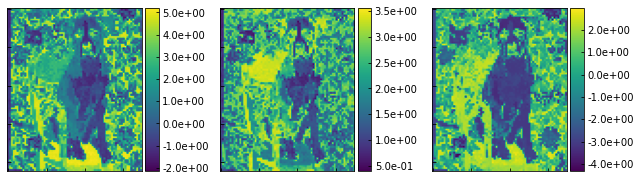

In [22]:
embedding_maps(encode, image)

- This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables


### Generator

- Now we want to see how the spectra changes as we traverse the latent space


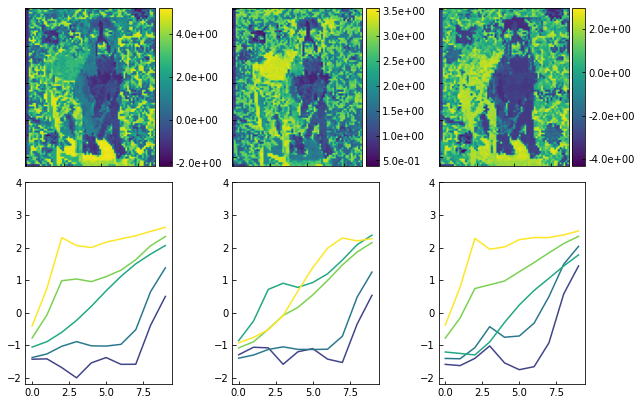

In [23]:
latent_generator(decoder, encode, image, 5, 10, device=device)

## Recurrent Neural Network Autoencoders


- The above example did not consider the temporal information in the data.


- This can be improved by using a recurrent neural network that processes each time step sequentially.


- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/LSTM%20Node.png?raw=true)


### Builds the model


In [24]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x

In [25]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

### Dataloader


In [26]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)

### Training


In [27]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

100%|██████████| 19/19 [00:01<00:00, 13.77it/s]


Epoch 0, Train Loss: 1.9070
.............................


100%|██████████| 19/19 [00:00<00:00, 253.08it/s]


Epoch 1, Train Loss: 1.9033
.............................


100%|██████████| 19/19 [00:00<00:00, 271.61it/s]


Epoch 2, Train Loss: 1.8997
.............................


100%|██████████| 19/19 [00:00<00:00, 283.20it/s]


Epoch 3, Train Loss: 1.8961
.............................


100%|██████████| 19/19 [00:00<00:00, 267.33it/s]


Epoch 4, Train Loss: 1.8926
.............................


100%|██████████| 19/19 [00:00<00:00, 263.67it/s]


Epoch 5, Train Loss: 1.8891
.............................


100%|██████████| 19/19 [00:00<00:00, 253.16it/s]


Epoch 6, Train Loss: 1.8856
.............................


100%|██████████| 19/19 [00:00<00:00, 260.40it/s]


Epoch 7, Train Loss: 1.8822
.............................


100%|██████████| 19/19 [00:00<00:00, 274.25it/s]


Epoch 8, Train Loss: 1.8788
.............................


100%|██████████| 19/19 [00:00<00:00, 253.38it/s]


Epoch 9, Train Loss: 1.8754
.............................


100%|██████████| 19/19 [00:00<00:00, 259.30it/s]


Epoch 10, Train Loss: 1.8720
.............................


100%|██████████| 19/19 [00:00<00:00, 267.49it/s]


Epoch 11, Train Loss: 1.8685
.............................


100%|██████████| 19/19 [00:00<00:00, 271.09it/s]


Epoch 12, Train Loss: 1.8651
.............................


100%|██████████| 19/19 [00:00<00:00, 275.07it/s]


Epoch 13, Train Loss: 1.8617
.............................


100%|██████████| 19/19 [00:00<00:00, 278.72it/s]


Epoch 14, Train Loss: 1.8582
.............................


100%|██████████| 19/19 [00:00<00:00, 275.40it/s]


Epoch 15, Train Loss: 1.8547
.............................


100%|██████████| 19/19 [00:00<00:00, 263.91it/s]


Epoch 16, Train Loss: 1.8511
.............................


100%|██████████| 19/19 [00:00<00:00, 238.12it/s]


Epoch 17, Train Loss: 1.8474
.............................


100%|██████████| 19/19 [00:00<00:00, 218.54it/s]


Epoch 18, Train Loss: 1.8437
.............................


100%|██████████| 19/19 [00:00<00:00, 226.37it/s]


Epoch 19, Train Loss: 1.8399
.............................


100%|██████████| 19/19 [00:00<00:00, 234.54it/s]


Epoch 20, Train Loss: 1.8359
.............................


100%|██████████| 19/19 [00:00<00:00, 296.63it/s]


Epoch 21, Train Loss: 1.8319
.............................


100%|██████████| 19/19 [00:00<00:00, 271.65it/s]


Epoch 22, Train Loss: 1.8276
.............................


100%|██████████| 19/19 [00:00<00:00, 256.71it/s]


Epoch 23, Train Loss: 1.8233
.............................


100%|██████████| 19/19 [00:00<00:00, 260.14it/s]


Epoch 24, Train Loss: 1.8187
.............................


100%|██████████| 19/19 [00:00<00:00, 234.57it/s]


Epoch 25, Train Loss: 1.8140
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 26, Train Loss: 1.8090
.............................


100%|██████████| 19/19 [00:00<00:00, 256.76it/s]


Epoch 27, Train Loss: 1.8038
.............................


100%|██████████| 19/19 [00:00<00:00, 275.11it/s]


Epoch 28, Train Loss: 1.7983
.............................


100%|██████████| 19/19 [00:00<00:00, 271.24it/s]


Epoch 29, Train Loss: 1.7925
.............................


100%|██████████| 19/19 [00:00<00:00, 260.27it/s]


Epoch 30, Train Loss: 1.7864
.............................


100%|██████████| 19/19 [00:00<00:00, 243.66it/s]


Epoch 31, Train Loss: 1.7799
.............................


100%|██████████| 19/19 [00:00<00:00, 231.68it/s]


Epoch 32, Train Loss: 1.7730
.............................


100%|██████████| 19/19 [00:00<00:00, 259.27it/s]


Epoch 33, Train Loss: 1.7657
.............................


100%|██████████| 19/19 [00:00<00:00, 251.43it/s]


Epoch 34, Train Loss: 1.7578
.............................


100%|██████████| 19/19 [00:00<00:00, 228.85it/s]


Epoch 35, Train Loss: 1.7494
.............................


100%|██████████| 19/19 [00:00<00:00, 246.49it/s]


Epoch 36, Train Loss: 1.7404
.............................


100%|██████████| 19/19 [00:00<00:00, 255.86it/s]


Epoch 37, Train Loss: 1.7308
.............................


100%|██████████| 19/19 [00:00<00:00, 206.29it/s]


Epoch 38, Train Loss: 1.7204
.............................


100%|██████████| 19/19 [00:00<00:00, 271.45it/s]


Epoch 39, Train Loss: 1.7093
.............................


100%|██████████| 19/19 [00:00<00:00, 275.14it/s]


Epoch 40, Train Loss: 1.6973
.............................


100%|██████████| 19/19 [00:00<00:00, 263.63it/s]


Epoch 41, Train Loss: 1.6845
.............................


100%|██████████| 19/19 [00:00<00:00, 297.10it/s]


Epoch 42, Train Loss: 1.6707
.............................


100%|██████████| 19/19 [00:00<00:00, 275.44it/s]


Epoch 43, Train Loss: 1.6558
.............................


100%|██████████| 19/19 [00:00<00:00, 287.67it/s]


Epoch 44, Train Loss: 1.6399
.............................


100%|██████████| 19/19 [00:00<00:00, 271.45it/s]


Epoch 45, Train Loss: 1.6230
.............................


100%|██████████| 19/19 [00:00<00:00, 282.73it/s]


Epoch 46, Train Loss: 1.6049
.............................


100%|██████████| 19/19 [00:00<00:00, 253.05it/s]


Epoch 47, Train Loss: 1.5856
.............................


100%|██████████| 19/19 [00:00<00:00, 216.84it/s]


Epoch 48, Train Loss: 1.5652
.............................


100%|██████████| 19/19 [00:00<00:00, 249.26it/s]


Epoch 49, Train Loss: 1.5437
.............................


100%|██████████| 19/19 [00:00<00:00, 243.47it/s]


Epoch 50, Train Loss: 1.5210
.............................


100%|██████████| 19/19 [00:00<00:00, 249.78it/s]


Epoch 51, Train Loss: 1.4974
.............................


100%|██████████| 19/19 [00:00<00:00, 206.67it/s]


Epoch 52, Train Loss: 1.4727
.............................


100%|██████████| 19/19 [00:00<00:00, 249.75it/s]


Epoch 53, Train Loss: 1.4471
.............................


100%|██████████| 19/19 [00:00<00:00, 246.62it/s]


Epoch 54, Train Loss: 1.4208
.............................


100%|██████████| 19/19 [00:00<00:00, 249.52it/s]


Epoch 55, Train Loss: 1.3936
.............................


100%|██████████| 19/19 [00:00<00:00, 213.48it/s]


Epoch 56, Train Loss: 1.3659
.............................


100%|██████████| 19/19 [00:00<00:00, 253.23it/s]


Epoch 57, Train Loss: 1.3375
.............................


100%|██████████| 19/19 [00:00<00:00, 253.22it/s]


Epoch 58, Train Loss: 1.3087
.............................


100%|██████████| 19/19 [00:00<00:00, 275.49it/s]


Epoch 59, Train Loss: 1.2795
.............................


100%|██████████| 19/19 [00:00<00:00, 277.01it/s]


Epoch 60, Train Loss: 1.2498
.............................


100%|██████████| 19/19 [00:00<00:00, 279.48it/s]


Epoch 61, Train Loss: 1.2199
.............................


100%|██████████| 19/19 [00:00<00:00, 279.42it/s]


Epoch 62, Train Loss: 1.1898
.............................


100%|██████████| 19/19 [00:00<00:00, 264.00it/s]


Epoch 63, Train Loss: 1.1595
.............................


100%|██████████| 19/19 [00:00<00:00, 266.72it/s]


Epoch 64, Train Loss: 1.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 261.19it/s]


Epoch 65, Train Loss: 1.0986
.............................


100%|██████████| 19/19 [00:00<00:00, 279.30it/s]


Epoch 66, Train Loss: 1.0681
.............................


100%|██████████| 19/19 [00:00<00:00, 275.37it/s]


Epoch 67, Train Loss: 1.0377
.............................


100%|██████████| 19/19 [00:00<00:00, 267.84it/s]


Epoch 68, Train Loss: 1.0074
.............................


100%|██████████| 19/19 [00:00<00:00, 275.12it/s]


Epoch 69, Train Loss: 0.9772
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 70, Train Loss: 0.9472
.............................


100%|██████████| 19/19 [00:00<00:00, 256.75it/s]


Epoch 71, Train Loss: 0.9175
.............................


100%|██████████| 19/19 [00:00<00:00, 241.98it/s]


Epoch 72, Train Loss: 0.8881
.............................


100%|██████████| 19/19 [00:00<00:00, 253.21it/s]


Epoch 73, Train Loss: 0.8591
.............................


100%|██████████| 19/19 [00:00<00:00, 253.60it/s]


Epoch 74, Train Loss: 0.8306
.............................


100%|██████████| 19/19 [00:00<00:00, 275.13it/s]


Epoch 75, Train Loss: 0.8026
.............................


100%|██████████| 19/19 [00:00<00:00, 256.77it/s]


Epoch 76, Train Loss: 0.7753
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 77, Train Loss: 0.7486
.............................


100%|██████████| 19/19 [00:00<00:00, 292.58it/s]


Epoch 78, Train Loss: 0.7227
.............................


100%|██████████| 19/19 [00:00<00:00, 283.39it/s]


Epoch 79, Train Loss: 0.6976
.............................


100%|██████████| 19/19 [00:00<00:00, 292.12it/s]


Epoch 80, Train Loss: 0.6735
.............................


100%|██████████| 19/19 [00:00<00:00, 266.23it/s]


Epoch 81, Train Loss: 0.6502
.............................


100%|██████████| 19/19 [00:00<00:00, 296.59it/s]


Epoch 82, Train Loss: 0.6279
.............................


100%|██████████| 19/19 [00:00<00:00, 287.84it/s]


Epoch 83, Train Loss: 0.6066
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 84, Train Loss: 0.5862
.............................


100%|██████████| 19/19 [00:00<00:00, 287.86it/s]


Epoch 85, Train Loss: 0.5668
.............................


100%|██████████| 19/19 [00:00<00:00, 287.91it/s]


Epoch 86, Train Loss: 0.5484
.............................


100%|██████████| 19/19 [00:00<00:00, 287.88it/s]


Epoch 87, Train Loss: 0.5308
.............................


100%|██████████| 19/19 [00:00<00:00, 283.67it/s]


Epoch 88, Train Loss: 0.5142
.............................


100%|██████████| 19/19 [00:00<00:00, 283.49it/s]


Epoch 89, Train Loss: 0.4983
.............................


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


Epoch 90, Train Loss: 0.4832
.............................


100%|██████████| 19/19 [00:00<00:00, 260.31it/s]


Epoch 91, Train Loss: 0.4688
.............................


100%|██████████| 19/19 [00:00<00:00, 271.50it/s]


Epoch 92, Train Loss: 0.4551
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 93, Train Loss: 0.4421
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 94, Train Loss: 0.4296
.............................


100%|██████████| 19/19 [00:00<00:00, 279.19it/s]


Epoch 95, Train Loss: 0.4177
.............................


100%|██████████| 19/19 [00:00<00:00, 275.19it/s]


Epoch 96, Train Loss: 0.4063
.............................


100%|██████████| 19/19 [00:00<00:00, 267.54it/s]


Epoch 97, Train Loss: 0.3954
.............................


100%|██████████| 19/19 [00:00<00:00, 279.33it/s]


Epoch 98, Train Loss: 0.3850
.............................


100%|██████████| 19/19 [00:00<00:00, 267.43it/s]


Epoch 99, Train Loss: 0.3750
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 100, Train Loss: 0.3655
.............................


100%|██████████| 19/19 [00:00<00:00, 275.24it/s]


Epoch 101, Train Loss: 0.3563
.............................


100%|██████████| 19/19 [00:00<00:00, 275.26it/s]


Epoch 102, Train Loss: 0.3476
.............................


100%|██████████| 19/19 [00:00<00:00, 263.89it/s]


Epoch 103, Train Loss: 0.3393
.............................


100%|██████████| 19/19 [00:00<00:00, 277.76it/s]


Epoch 104, Train Loss: 0.3313
.............................


100%|██████████| 19/19 [00:00<00:00, 275.50it/s]


Epoch 105, Train Loss: 0.3237
.............................


100%|██████████| 19/19 [00:00<00:00, 287.88it/s]


Epoch 106, Train Loss: 0.3164
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 107, Train Loss: 0.3094
.............................


100%|██████████| 19/19 [00:00<00:00, 267.41it/s]


Epoch 108, Train Loss: 0.3028
.............................


100%|██████████| 19/19 [00:00<00:00, 275.19it/s]


Epoch 109, Train Loss: 0.2965
.............................


100%|██████████| 19/19 [00:00<00:00, 277.63it/s]


Epoch 110, Train Loss: 0.2904
.............................


100%|██████████| 19/19 [00:00<00:00, 279.41it/s]


Epoch 111, Train Loss: 0.2847
.............................


100%|██████████| 19/19 [00:00<00:00, 211.10it/s]


Epoch 112, Train Loss: 0.2792
.............................


100%|██████████| 19/19 [00:00<00:00, 271.24it/s]


Epoch 113, Train Loss: 0.2739
.............................


100%|██████████| 19/19 [00:00<00:00, 279.32it/s]


Epoch 114, Train Loss: 0.2689
.............................


100%|██████████| 19/19 [00:00<00:00, 292.29it/s]


Epoch 115, Train Loss: 0.2642
.............................


100%|██████████| 19/19 [00:00<00:00, 279.52it/s]


Epoch 116, Train Loss: 0.2597
.............................


100%|██████████| 19/19 [00:00<00:00, 297.09it/s]


Epoch 117, Train Loss: 0.2554
.............................


100%|██████████| 19/19 [00:00<00:00, 279.21it/s]


Epoch 118, Train Loss: 0.2513
.............................


100%|██████████| 19/19 [00:00<00:00, 287.69it/s]


Epoch 119, Train Loss: 0.2474
.............................


100%|██████████| 19/19 [00:00<00:00, 301.61it/s]


Epoch 120, Train Loss: 0.2437
.............................


100%|██████████| 19/19 [00:00<00:00, 275.64it/s]


Epoch 121, Train Loss: 0.2402
.............................


100%|██████████| 19/19 [00:00<00:00, 269.66it/s]


Epoch 122, Train Loss: 0.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 271.63it/s]


Epoch 123, Train Loss: 0.2338
.............................


100%|██████████| 19/19 [00:00<00:00, 260.27it/s]


Epoch 124, Train Loss: 0.2308
.............................


100%|██████████| 19/19 [00:00<00:00, 253.23it/s]


Epoch 125, Train Loss: 0.2279
.............................


100%|██████████| 19/19 [00:00<00:00, 271.57it/s]


Epoch 126, Train Loss: 0.2252
.............................


100%|██████████| 19/19 [00:00<00:00, 271.44it/s]


Epoch 127, Train Loss: 0.2227
.............................


100%|██████████| 19/19 [00:00<00:00, 275.57it/s]


Epoch 128, Train Loss: 0.2202
.............................


100%|██████████| 19/19 [00:00<00:00, 277.19it/s]


Epoch 129, Train Loss: 0.2179
.............................


100%|██████████| 19/19 [00:00<00:00, 260.33it/s]


Epoch 130, Train Loss: 0.2158
.............................


100%|██████████| 19/19 [00:00<00:00, 279.28it/s]


Epoch 131, Train Loss: 0.2137
.............................


100%|██████████| 19/19 [00:00<00:00, 279.28it/s]


Epoch 132, Train Loss: 0.2117
.............................


100%|██████████| 19/19 [00:00<00:00, 296.71it/s]


Epoch 133, Train Loss: 0.2099
.............................


100%|██████████| 19/19 [00:00<00:00, 279.24it/s]


Epoch 134, Train Loss: 0.2081
.............................


100%|██████████| 19/19 [00:00<00:00, 215.86it/s]


Epoch 135, Train Loss: 0.2065
.............................


100%|██████████| 19/19 [00:00<00:00, 291.69it/s]


Epoch 136, Train Loss: 0.2049
.............................


100%|██████████| 19/19 [00:00<00:00, 253.34it/s]


Epoch 137, Train Loss: 0.2034
.............................


100%|██████████| 19/19 [00:00<00:00, 283.26it/s]


Epoch 138, Train Loss: 0.2020
.............................


100%|██████████| 19/19 [00:00<00:00, 280.17it/s]


Epoch 139, Train Loss: 0.2007
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 140, Train Loss: 0.1994
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 141, Train Loss: 0.1982
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 142, Train Loss: 0.1971
.............................


100%|██████████| 19/19 [00:00<00:00, 263.76it/s]


Epoch 143, Train Loss: 0.1960
.............................


100%|██████████| 19/19 [00:00<00:00, 266.57it/s]


Epoch 144, Train Loss: 0.1950
.............................


100%|██████████| 19/19 [00:00<00:00, 275.38it/s]


Epoch 145, Train Loss: 0.1940
.............................


100%|██████████| 19/19 [00:00<00:00, 279.47it/s]


Epoch 146, Train Loss: 0.1931
.............................


100%|██████████| 19/19 [00:00<00:00, 287.89it/s]


Epoch 147, Train Loss: 0.1923
.............................


100%|██████████| 19/19 [00:00<00:00, 283.38it/s]


Epoch 148, Train Loss: 0.1915
.............................


100%|██████████| 19/19 [00:00<00:00, 283.40it/s]


Epoch 149, Train Loss: 0.1907
.............................


100%|██████████| 19/19 [00:00<00:00, 287.67it/s]


Epoch 150, Train Loss: 0.1900
.............................


100%|██████████| 19/19 [00:00<00:00, 271.42it/s]


Epoch 151, Train Loss: 0.1893
.............................


100%|██████████| 19/19 [00:00<00:00, 275.62it/s]


Epoch 152, Train Loss: 0.1886
.............................


100%|██████████| 19/19 [00:00<00:00, 275.33it/s]


Epoch 153, Train Loss: 0.1880
.............................


100%|██████████| 19/19 [00:00<00:00, 279.28it/s]


Epoch 154, Train Loss: 0.1874
.............................


100%|██████████| 19/19 [00:00<00:00, 287.62it/s]


Epoch 155, Train Loss: 0.1869
.............................


100%|██████████| 19/19 [00:00<00:00, 267.83it/s]


Epoch 156, Train Loss: 0.1863
.............................


100%|██████████| 19/19 [00:00<00:00, 287.65it/s]


Epoch 157, Train Loss: 0.1858
.............................


100%|██████████| 19/19 [00:00<00:00, 283.59it/s]


Epoch 158, Train Loss: 0.1854
.............................


100%|██████████| 19/19 [00:00<00:00, 283.60it/s]


Epoch 159, Train Loss: 0.1849
.............................


100%|██████████| 19/19 [00:00<00:00, 296.67it/s]


Epoch 160, Train Loss: 0.1845
.............................


100%|██████████| 19/19 [00:00<00:00, 287.25it/s]


Epoch 161, Train Loss: 0.1841
.............................


100%|██████████| 19/19 [00:00<00:00, 279.65it/s]


Epoch 162, Train Loss: 0.1837
.............................


100%|██████████| 19/19 [00:00<00:00, 275.36it/s]


Epoch 163, Train Loss: 0.1833
.............................


100%|██████████| 19/19 [00:00<00:00, 283.58it/s]


Epoch 164, Train Loss: 0.1829
.............................


100%|██████████| 19/19 [00:00<00:00, 275.26it/s]


Epoch 165, Train Loss: 0.1826
.............................


100%|██████████| 19/19 [00:00<00:00, 283.56it/s]


Epoch 166, Train Loss: 0.1823
.............................


100%|██████████| 19/19 [00:00<00:00, 275.33it/s]


Epoch 167, Train Loss: 0.1820
.............................


100%|██████████| 19/19 [00:00<00:00, 290.48it/s]


Epoch 168, Train Loss: 0.1817
.............................


100%|██████████| 19/19 [00:00<00:00, 292.13it/s]


Epoch 169, Train Loss: 0.1814
.............................


100%|██████████| 19/19 [00:00<00:00, 283.58it/s]


Epoch 170, Train Loss: 0.1811
.............................


100%|██████████| 19/19 [00:00<00:00, 279.46it/s]


Epoch 171, Train Loss: 0.1808
.............................


100%|██████████| 19/19 [00:00<00:00, 267.83it/s]


Epoch 172, Train Loss: 0.1806
.............................


100%|██████████| 19/19 [00:00<00:00, 287.65it/s]


Epoch 173, Train Loss: 0.1803
.............................


100%|██████████| 19/19 [00:00<00:00, 281.73it/s]


Epoch 174, Train Loss: 0.1801
.............................


100%|██████████| 19/19 [00:00<00:00, 264.02it/s]


Epoch 175, Train Loss: 0.1798
.............................


100%|██████████| 19/19 [00:00<00:00, 279.20it/s]


Epoch 176, Train Loss: 0.1796
.............................


100%|██████████| 19/19 [00:00<00:00, 301.38it/s]


Epoch 177, Train Loss: 0.1794
.............................


100%|██████████| 19/19 [00:00<00:00, 287.94it/s]


Epoch 178, Train Loss: 0.1791
.............................


100%|██████████| 19/19 [00:00<00:00, 287.72it/s]


Epoch 179, Train Loss: 0.1789
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 180, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 296.78it/s]


Epoch 181, Train Loss: 0.1785
.............................


100%|██████████| 19/19 [00:00<00:00, 287.88it/s]


Epoch 182, Train Loss: 0.1783
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 183, Train Loss: 0.1781
.............................


100%|██████████| 19/19 [00:00<00:00, 287.68it/s]


Epoch 184, Train Loss: 0.1779
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 185, Train Loss: 0.1777
.............................


100%|██████████| 19/19 [00:00<00:00, 267.87it/s]


Epoch 186, Train Loss: 0.1776
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 187, Train Loss: 0.1774
.............................


100%|██████████| 19/19 [00:00<00:00, 267.48it/s]


Epoch 188, Train Loss: 0.1772
.............................


100%|██████████| 19/19 [00:00<00:00, 296.97it/s]


Epoch 189, Train Loss: 0.1770
.............................


100%|██████████| 19/19 [00:00<00:00, 283.39it/s]


Epoch 190, Train Loss: 0.1768
.............................


100%|██████████| 19/19 [00:00<00:00, 292.31it/s]


Epoch 191, Train Loss: 0.1767
.............................


100%|██████████| 19/19 [00:00<00:00, 284.51it/s]


Epoch 192, Train Loss: 0.1765
.............................


100%|██████████| 19/19 [00:00<00:00, 283.56it/s]


Epoch 193, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 275.40it/s]


Epoch 194, Train Loss: 0.1761
.............................


100%|██████████| 19/19 [00:00<00:00, 292.12it/s]


Epoch 195, Train Loss: 0.1760
.............................


100%|██████████| 19/19 [00:00<00:00, 283.44it/s]


Epoch 196, Train Loss: 0.1758
.............................


100%|██████████| 19/19 [00:00<00:00, 246.79it/s]


Epoch 197, Train Loss: 0.1756
.............................


100%|██████████| 19/19 [00:00<00:00, 267.62it/s]


Epoch 198, Train Loss: 0.1755
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 199, Train Loss: 0.1753
.............................


100%|██████████| 19/19 [00:00<00:00, 275.01it/s]


Epoch 200, Train Loss: 0.1751
.............................


100%|██████████| 19/19 [00:00<00:00, 297.03it/s]


Epoch 201, Train Loss: 0.1750
.............................


100%|██████████| 19/19 [00:00<00:00, 301.62it/s]


Epoch 202, Train Loss: 0.1748
.............................


100%|██████████| 19/19 [00:00<00:00, 287.71it/s]


Epoch 203, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 287.86it/s]


Epoch 204, Train Loss: 0.1745
.............................


100%|██████████| 19/19 [00:00<00:00, 287.73it/s]


Epoch 205, Train Loss: 0.1743
.............................


100%|██████████| 19/19 [00:00<00:00, 287.91it/s]


Epoch 206, Train Loss: 0.1741
.............................


100%|██████████| 19/19 [00:00<00:00, 305.08it/s]


Epoch 207, Train Loss: 0.1740
.............................


100%|██████████| 19/19 [00:00<00:00, 292.48it/s]


Epoch 208, Train Loss: 0.1738
.............................


100%|██████████| 19/19 [00:00<00:00, 275.35it/s]


Epoch 209, Train Loss: 0.1736
.............................


100%|██████████| 19/19 [00:00<00:00, 282.17it/s]


Epoch 210, Train Loss: 0.1735
.............................


100%|██████████| 19/19 [00:00<00:00, 283.64it/s]


Epoch 211, Train Loss: 0.1733
.............................


100%|██████████| 19/19 [00:00<00:00, 275.28it/s]


Epoch 212, Train Loss: 0.1731
.............................


100%|██████████| 19/19 [00:00<00:00, 280.36it/s]


Epoch 213, Train Loss: 0.1730
.............................


100%|██████████| 19/19 [00:00<00:00, 301.80it/s]


Epoch 214, Train Loss: 0.1728
.............................


100%|██████████| 19/19 [00:00<00:00, 296.83it/s]


Epoch 215, Train Loss: 0.1726
.............................


100%|██████████| 19/19 [00:00<00:00, 283.48it/s]


Epoch 216, Train Loss: 0.1725
.............................


100%|██████████| 19/19 [00:00<00:00, 288.05it/s]


Epoch 217, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 275.42it/s]


Epoch 218, Train Loss: 0.1721
.............................


100%|██████████| 19/19 [00:00<00:00, 275.35it/s]


Epoch 219, Train Loss: 0.1720
.............................


100%|██████████| 19/19 [00:00<00:00, 287.87it/s]


Epoch 220, Train Loss: 0.1718
.............................


100%|██████████| 19/19 [00:00<00:00, 271.48it/s]


Epoch 221, Train Loss: 0.1716
.............................


100%|██████████| 19/19 [00:00<00:00, 287.74it/s]


Epoch 222, Train Loss: 0.1714
.............................


100%|██████████| 19/19 [00:00<00:00, 280.92it/s]


Epoch 223, Train Loss: 0.1713
.............................


100%|██████████| 19/19 [00:00<00:00, 287.71it/s]


Epoch 224, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 292.32it/s]


Epoch 225, Train Loss: 0.1709
.............................


100%|██████████| 19/19 [00:00<00:00, 296.85it/s]


Epoch 226, Train Loss: 0.1707
.............................


100%|██████████| 19/19 [00:00<00:00, 282.18it/s]


Epoch 227, Train Loss: 0.1706
.............................


100%|██████████| 19/19 [00:00<00:00, 287.92it/s]


Epoch 228, Train Loss: 0.1704
.............................


100%|██████████| 19/19 [00:00<00:00, 237.62it/s]


Epoch 229, Train Loss: 0.1702
.............................


100%|██████████| 19/19 [00:00<00:00, 270.91it/s]


Epoch 230, Train Loss: 0.1700
.............................


100%|██████████| 19/19 [00:00<00:00, 256.92it/s]


Epoch 231, Train Loss: 0.1698
.............................


100%|██████████| 19/19 [00:00<00:00, 260.39it/s]


Epoch 232, Train Loss: 0.1697
.............................


100%|██████████| 19/19 [00:00<00:00, 256.30it/s]


Epoch 233, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 263.90it/s]


Epoch 234, Train Loss: 0.1693
.............................


100%|██████████| 19/19 [00:00<00:00, 267.64it/s]


Epoch 235, Train Loss: 0.1691
.............................


100%|██████████| 19/19 [00:00<00:00, 243.41it/s]


Epoch 236, Train Loss: 0.1689
.............................


100%|██████████| 19/19 [00:00<00:00, 247.47it/s]


Epoch 237, Train Loss: 0.1687
.............................


100%|██████████| 19/19 [00:00<00:00, 279.21it/s]


Epoch 238, Train Loss: 0.1685
.............................


100%|██████████| 19/19 [00:00<00:00, 275.38it/s]


Epoch 239, Train Loss: 0.1683
.............................


100%|██████████| 19/19 [00:00<00:00, 252.95it/s]


Epoch 240, Train Loss: 0.1681
.............................


100%|██████████| 19/19 [00:00<00:00, 263.46it/s]


Epoch 241, Train Loss: 0.1679
.............................


100%|██████████| 19/19 [00:00<00:00, 266.88it/s]


Epoch 242, Train Loss: 0.1677
.............................


100%|██████████| 19/19 [00:00<00:00, 274.70it/s]


Epoch 243, Train Loss: 0.1675
.............................


100%|██████████| 19/19 [00:00<00:00, 253.19it/s]


Epoch 244, Train Loss: 0.1673
.............................


100%|██████████| 19/19 [00:00<00:00, 274.18it/s]


Epoch 245, Train Loss: 0.1671
.............................


100%|██████████| 19/19 [00:00<00:00, 279.14it/s]


Epoch 246, Train Loss: 0.1669
.............................


100%|██████████| 19/19 [00:00<00:00, 271.30it/s]


Epoch 247, Train Loss: 0.1667
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 248, Train Loss: 0.1665
.............................


100%|██████████| 19/19 [00:00<00:00, 275.17it/s]


Epoch 249, Train Loss: 0.1663
.............................


100%|██████████| 19/19 [00:00<00:00, 260.21it/s]


Epoch 250, Train Loss: 0.1660
.............................


100%|██████████| 19/19 [00:00<00:00, 275.81it/s]


Epoch 251, Train Loss: 0.1658
.............................


100%|██████████| 19/19 [00:00<00:00, 301.38it/s]


Epoch 252, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 271.26it/s]


Epoch 253, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 220.87it/s]


Epoch 254, Train Loss: 0.1652
.............................


100%|██████████| 19/19 [00:00<00:00, 279.34it/s]


Epoch 255, Train Loss: 0.1649
.............................


100%|██████████| 19/19 [00:00<00:00, 275.36it/s]


Epoch 256, Train Loss: 0.1647
.............................


100%|██████████| 19/19 [00:00<00:00, 287.85it/s]


Epoch 257, Train Loss: 0.1645
.............................


100%|██████████| 19/19 [00:00<00:00, 260.13it/s]


Epoch 258, Train Loss: 0.1642
.............................


100%|██████████| 19/19 [00:00<00:00, 279.25it/s]


Epoch 259, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 306.49it/s]


Epoch 260, Train Loss: 0.1637
.............................


100%|██████████| 19/19 [00:00<00:00, 275.59it/s]


Epoch 261, Train Loss: 0.1635
.............................


100%|██████████| 19/19 [00:00<00:00, 283.42it/s]


Epoch 262, Train Loss: 0.1633
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 263, Train Loss: 0.1630
.............................


100%|██████████| 19/19 [00:00<00:00, 258.33it/s]


Epoch 264, Train Loss: 0.1628
.............................


100%|██████████| 19/19 [00:00<00:00, 251.62it/s]


Epoch 265, Train Loss: 0.1625
.............................


100%|██████████| 19/19 [00:00<00:00, 260.25it/s]


Epoch 266, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 260.12it/s]


Epoch 267, Train Loss: 0.1620
.............................


100%|██████████| 19/19 [00:00<00:00, 296.61it/s]


Epoch 268, Train Loss: 0.1617
.............................


100%|██████████| 19/19 [00:00<00:00, 292.19it/s]


Epoch 269, Train Loss: 0.1615
.............................


100%|██████████| 19/19 [00:00<00:00, 256.93it/s]


Epoch 270, Train Loss: 0.1612
.............................


100%|██████████| 19/19 [00:00<00:00, 253.21it/s]


Epoch 271, Train Loss: 0.1609
.............................


100%|██████████| 19/19 [00:00<00:00, 292.23it/s]


Epoch 272, Train Loss: 0.1607
.............................


100%|██████████| 19/19 [00:00<00:00, 296.91it/s]


Epoch 273, Train Loss: 0.1604
.............................


100%|██████████| 19/19 [00:00<00:00, 267.99it/s]


Epoch 274, Train Loss: 0.1601
.............................


100%|██████████| 19/19 [00:00<00:00, 271.41it/s]


Epoch 275, Train Loss: 0.1599
.............................


100%|██████████| 19/19 [00:00<00:00, 287.99it/s]


Epoch 276, Train Loss: 0.1596
.............................


100%|██████████| 19/19 [00:00<00:00, 279.23it/s]


Epoch 277, Train Loss: 0.1593
.............................


100%|██████████| 19/19 [00:00<00:00, 237.32it/s]


Epoch 278, Train Loss: 0.1590
.............................


100%|██████████| 19/19 [00:00<00:00, 275.21it/s]


Epoch 279, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 297.01it/s]


Epoch 280, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 275.37it/s]


Epoch 281, Train Loss: 0.1582
.............................


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


Epoch 282, Train Loss: 0.1579
.............................


100%|██████████| 19/19 [00:00<00:00, 282.16it/s]


Epoch 283, Train Loss: 0.1577
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 284, Train Loss: 0.1574
.............................


100%|██████████| 19/19 [00:00<00:00, 292.33it/s]


Epoch 285, Train Loss: 0.1571
.............................


100%|██████████| 19/19 [00:00<00:00, 296.68it/s]


Epoch 286, Train Loss: 0.1568
.............................


100%|██████████| 19/19 [00:00<00:00, 283.57it/s]


Epoch 287, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 287.97it/s]


Epoch 288, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 283.58it/s]


Epoch 289, Train Loss: 0.1560
.............................


100%|██████████| 19/19 [00:00<00:00, 283.60it/s]


Epoch 290, Train Loss: 0.1557
.............................


100%|██████████| 19/19 [00:00<00:00, 283.55it/s]


Epoch 291, Train Loss: 0.1554
.............................


100%|██████████| 19/19 [00:00<00:00, 287.68it/s]


Epoch 292, Train Loss: 0.1552
.............................


100%|██████████| 19/19 [00:00<00:00, 296.67it/s]


Epoch 293, Train Loss: 0.1549
.............................


100%|██████████| 19/19 [00:00<00:00, 279.40it/s]


Epoch 294, Train Loss: 0.1546
.............................


100%|██████████| 19/19 [00:00<00:00, 283.39it/s]


Epoch 295, Train Loss: 0.1543
.............................


100%|██████████| 19/19 [00:00<00:00, 279.41it/s]


Epoch 296, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 283.44it/s]


Epoch 297, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 271.70it/s]


Epoch 298, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 237.47it/s]


Epoch 299, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 270.12it/s]


Epoch 300, Train Loss: 0.1529
.............................


100%|██████████| 19/19 [00:00<00:00, 256.93it/s]


Epoch 301, Train Loss: 0.1527
.............................


100%|██████████| 19/19 [00:00<00:00, 271.66it/s]


Epoch 302, Train Loss: 0.1524
.............................


100%|██████████| 19/19 [00:00<00:00, 275.61it/s]


Epoch 303, Train Loss: 0.1521
.............................


100%|██████████| 19/19 [00:00<00:00, 278.61it/s]


Epoch 304, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 283.63it/s]


Epoch 305, Train Loss: 0.1516
.............................


100%|██████████| 19/19 [00:00<00:00, 253.90it/s]


Epoch 306, Train Loss: 0.1513
.............................


100%|██████████| 19/19 [00:00<00:00, 275.13it/s]


Epoch 307, Train Loss: 0.1510
.............................


100%|██████████| 19/19 [00:00<00:00, 275.37it/s]


Epoch 308, Train Loss: 0.1507
.............................


100%|██████████| 19/19 [00:00<00:00, 283.38it/s]


Epoch 309, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 291.73it/s]


Epoch 310, Train Loss: 0.1502
.............................


100%|██████████| 19/19 [00:00<00:00, 271.27it/s]


Epoch 311, Train Loss: 0.1499
.............................


100%|██████████| 19/19 [00:00<00:00, 283.24it/s]


Epoch 312, Train Loss: 0.1496
.............................


100%|██████████| 19/19 [00:00<00:00, 275.21it/s]


Epoch 313, Train Loss: 0.1494
.............................


100%|██████████| 19/19 [00:00<00:00, 271.44it/s]


Epoch 314, Train Loss: 0.1491
.............................


100%|██████████| 19/19 [00:00<00:00, 276.03it/s]


Epoch 315, Train Loss: 0.1488
.............................


100%|██████████| 19/19 [00:00<00:00, 275.38it/s]


Epoch 316, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 275.19it/s]


Epoch 317, Train Loss: 0.1483
.............................


100%|██████████| 19/19 [00:00<00:00, 267.60it/s]


Epoch 318, Train Loss: 0.1480
.............................


100%|██████████| 19/19 [00:00<00:00, 283.57it/s]


Epoch 319, Train Loss: 0.1478
.............................


100%|██████████| 19/19 [00:00<00:00, 263.76it/s]


Epoch 320, Train Loss: 0.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 286.96it/s]


Epoch 321, Train Loss: 0.1473
.............................


100%|██████████| 19/19 [00:00<00:00, 275.18it/s]


Epoch 322, Train Loss: 0.1470
.............................


100%|██████████| 19/19 [00:00<00:00, 275.58it/s]


Epoch 323, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 324, Train Loss: 0.1465
.............................


100%|██████████| 19/19 [00:00<00:00, 271.45it/s]


Epoch 325, Train Loss: 0.1462
.............................


100%|██████████| 19/19 [00:00<00:00, 243.60it/s]


Epoch 326, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 150.79it/s]


Epoch 327, Train Loss: 0.1457
.............................


100%|██████████| 19/19 [00:00<00:00, 228.76it/s]


Epoch 328, Train Loss: 0.1455
.............................


100%|██████████| 19/19 [00:00<00:00, 278.75it/s]


Epoch 329, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 330, Train Loss: 0.1450
.............................


100%|██████████| 19/19 [00:00<00:00, 259.84it/s]


Epoch 331, Train Loss: 0.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 264.57it/s]


Epoch 332, Train Loss: 0.1445
.............................


100%|██████████| 19/19 [00:00<00:00, 263.78it/s]


Epoch 333, Train Loss: 0.1443
.............................


100%|██████████| 19/19 [00:00<00:00, 279.36it/s]


Epoch 334, Train Loss: 0.1440
.............................


100%|██████████| 19/19 [00:00<00:00, 279.47it/s]


Epoch 335, Train Loss: 0.1438
.............................


100%|██████████| 19/19 [00:00<00:00, 279.25it/s]


Epoch 336, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 283.34it/s]


Epoch 337, Train Loss: 0.1433
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 338, Train Loss: 0.1431
.............................


100%|██████████| 19/19 [00:00<00:00, 283.98it/s]


Epoch 339, Train Loss: 0.1428
.............................


100%|██████████| 19/19 [00:00<00:00, 271.44it/s]


Epoch 340, Train Loss: 0.1426
.............................


100%|██████████| 19/19 [00:00<00:00, 263.75it/s]


Epoch 341, Train Loss: 0.1424
.............................


100%|██████████| 19/19 [00:00<00:00, 267.71it/s]


Epoch 342, Train Loss: 0.1422
.............................


100%|██████████| 19/19 [00:00<00:00, 279.25it/s]


Epoch 343, Train Loss: 0.1419
.............................


100%|██████████| 19/19 [00:00<00:00, 283.36it/s]


Epoch 344, Train Loss: 0.1417
.............................


100%|██████████| 19/19 [00:00<00:00, 271.48it/s]


Epoch 345, Train Loss: 0.1415
.............................


100%|██████████| 19/19 [00:00<00:00, 275.42it/s]


Epoch 346, Train Loss: 0.1413
.............................


100%|██████████| 19/19 [00:00<00:00, 249.79it/s]


Epoch 347, Train Loss: 0.1411
.............................


100%|██████████| 19/19 [00:00<00:00, 279.24it/s]


Epoch 348, Train Loss: 0.1409
.............................


100%|██████████| 19/19 [00:00<00:00, 283.60it/s]


Epoch 349, Train Loss: 0.1406
.............................


100%|██████████| 19/19 [00:00<00:00, 275.39it/s]


Epoch 350, Train Loss: 0.1404
.............................


100%|██████████| 19/19 [00:00<00:00, 279.53it/s]


Epoch 351, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 283.57it/s]


Epoch 352, Train Loss: 0.1400
.............................


100%|██████████| 19/19 [00:00<00:00, 275.26it/s]


Epoch 353, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 292.31it/s]


Epoch 354, Train Loss: 0.1396
.............................


100%|██████████| 19/19 [00:00<00:00, 267.73it/s]


Epoch 355, Train Loss: 0.1394
.............................


100%|██████████| 19/19 [00:00<00:00, 283.40it/s]


Epoch 356, Train Loss: 0.1392
.............................


100%|██████████| 19/19 [00:00<00:00, 275.32it/s]


Epoch 357, Train Loss: 0.1390
.............................


100%|██████████| 19/19 [00:00<00:00, 271.27it/s]


Epoch 358, Train Loss: 0.1388
.............................


100%|██████████| 19/19 [00:00<00:00, 265.93it/s]


Epoch 359, Train Loss: 0.1386
.............................


100%|██████████| 19/19 [00:00<00:00, 283.55it/s]


Epoch 360, Train Loss: 0.1384
.............................


100%|██████████| 19/19 [00:00<00:00, 283.40it/s]


Epoch 361, Train Loss: 0.1382
.............................


100%|██████████| 19/19 [00:00<00:00, 279.48it/s]


Epoch 362, Train Loss: 0.1380
.............................


100%|██████████| 19/19 [00:00<00:00, 279.42it/s]


Epoch 363, Train Loss: 0.1378
.............................


100%|██████████| 19/19 [00:00<00:00, 267.39it/s]


Epoch 364, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 279.19it/s]


Epoch 365, Train Loss: 0.1374
.............................


100%|██████████| 19/19 [00:00<00:00, 287.94it/s]


Epoch 366, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 282.16it/s]


Epoch 367, Train Loss: 0.1370
.............................


100%|██████████| 19/19 [00:00<00:00, 292.32it/s]


Epoch 368, Train Loss: 0.1369
.............................


100%|██████████| 19/19 [00:00<00:00, 283.39it/s]


Epoch 369, Train Loss: 0.1367
.............................


100%|██████████| 19/19 [00:00<00:00, 292.31it/s]


Epoch 370, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 296.95it/s]


Epoch 371, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


Epoch 372, Train Loss: 0.1361
.............................


100%|██████████| 19/19 [00:00<00:00, 296.91it/s]


Epoch 373, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 374, Train Loss: 0.1357
.............................


100%|██████████| 19/19 [00:00<00:00, 292.36it/s]


Epoch 375, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 278.58it/s]


Epoch 376, Train Loss: 0.1354
.............................


100%|██████████| 19/19 [00:00<00:00, 287.81it/s]


Epoch 377, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 279.21it/s]


Epoch 378, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 283.56it/s]


Epoch 379, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 380, Train Loss: 0.1346
.............................


100%|██████████| 19/19 [00:00<00:00, 283.56it/s]


Epoch 381, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 290.76it/s]


Epoch 382, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 296.87it/s]


Epoch 383, Train Loss: 0.1341
.............................


100%|██████████| 19/19 [00:00<00:00, 287.88it/s]


Epoch 384, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 296.98it/s]


Epoch 385, Train Loss: 0.1337
.............................


100%|██████████| 19/19 [00:00<00:00, 306.43it/s]


Epoch 386, Train Loss: 0.1335
.............................


100%|██████████| 19/19 [00:00<00:00, 292.38it/s]


Epoch 387, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 283.41it/s]


Epoch 388, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 296.67it/s]


Epoch 389, Train Loss: 0.1330
.............................


100%|██████████| 19/19 [00:00<00:00, 279.17it/s]


Epoch 390, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 271.27it/s]


Epoch 391, Train Loss: 0.1326
.............................


100%|██████████| 19/19 [00:00<00:00, 287.89it/s]


Epoch 392, Train Loss: 0.1324
.............................


100%|██████████| 19/19 [00:00<00:00, 296.68it/s]


Epoch 393, Train Loss: 0.1323
.............................


100%|██████████| 19/19 [00:00<00:00, 287.69it/s]


Epoch 394, Train Loss: 0.1321
.............................


100%|██████████| 19/19 [00:00<00:00, 220.96it/s]


Epoch 395, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 306.40it/s]


Epoch 396, Train Loss: 0.1317
.............................


100%|██████████| 19/19 [00:00<00:00, 292.26it/s]


Epoch 397, Train Loss: 0.1315
.............................


100%|██████████| 19/19 [00:00<00:00, 295.50it/s]


Epoch 398, Train Loss: 0.1313
.............................


100%|██████████| 19/19 [00:00<00:00, 283.59it/s]


Epoch 399, Train Loss: 0.1312
.............................


100%|██████████| 19/19 [00:00<00:00, 275.41it/s]


Epoch 400, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 250.00it/s]


Epoch 401, Train Loss: 0.1308
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 402, Train Loss: 0.1306
.............................


100%|██████████| 19/19 [00:00<00:00, 252.40it/s]


Epoch 403, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 404, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 256.56it/s]


Epoch 405, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 288.17it/s]


Epoch 406, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 283.59it/s]


Epoch 407, Train Loss: 0.1297
.............................


100%|██████████| 19/19 [00:00<00:00, 256.89it/s]


Epoch 408, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 263.86it/s]


Epoch 409, Train Loss: 0.1293
.............................


100%|██████████| 19/19 [00:00<00:00, 275.31it/s]


Epoch 410, Train Loss: 0.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 255.38it/s]


Epoch 411, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 279.41it/s]


Epoch 412, Train Loss: 0.1288
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 413, Train Loss: 0.1286
.............................


100%|██████████| 19/19 [00:00<00:00, 279.42it/s]


Epoch 414, Train Loss: 0.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 283.39it/s]


Epoch 415, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 275.30it/s]


Epoch 416, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 297.63it/s]


Epoch 417, Train Loss: 0.1278
.............................


100%|██████████| 19/19 [00:00<00:00, 287.69it/s]


Epoch 418, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 271.41it/s]


Epoch 419, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 296.68it/s]


Epoch 420, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 296.90it/s]


Epoch 421, Train Loss: 0.1271
.............................


100%|██████████| 19/19 [00:00<00:00, 279.39it/s]


Epoch 422, Train Loss: 0.1269
.............................


100%|██████████| 19/19 [00:00<00:00, 296.93it/s]


Epoch 423, Train Loss: 0.1267
.............................


100%|██████████| 19/19 [00:00<00:00, 283.75it/s]


Epoch 424, Train Loss: 0.1265
.............................


100%|██████████| 19/19 [00:00<00:00, 275.15it/s]


Epoch 425, Train Loss: 0.1263
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 426, Train Loss: 0.1261
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 427, Train Loss: 0.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 292.10it/s]


Epoch 428, Train Loss: 0.1258
.............................


100%|██████████| 19/19 [00:00<00:00, 292.09it/s]


Epoch 429, Train Loss: 0.1256
.............................


100%|██████████| 19/19 [00:00<00:00, 296.62it/s]


Epoch 430, Train Loss: 0.1254
.............................


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


Epoch 431, Train Loss: 0.1252
.............................


100%|██████████| 19/19 [00:00<00:00, 283.51it/s]


Epoch 432, Train Loss: 0.1250
.............................


100%|██████████| 19/19 [00:00<00:00, 263.77it/s]


Epoch 433, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 287.75it/s]


Epoch 434, Train Loss: 0.1246
.............................


100%|██████████| 19/19 [00:00<00:00, 270.64it/s]


Epoch 435, Train Loss: 0.1244
.............................


100%|██████████| 19/19 [00:00<00:00, 287.90it/s]


Epoch 436, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 275.28it/s]


Epoch 437, Train Loss: 0.1241
.............................


100%|██████████| 19/19 [00:00<00:00, 260.28it/s]


Epoch 438, Train Loss: 0.1239
.............................


100%|██████████| 19/19 [00:00<00:00, 229.03it/s]


Epoch 439, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 267.40it/s]


Epoch 440, Train Loss: 0.1235
.............................


100%|██████████| 19/19 [00:00<00:00, 249.93it/s]


Epoch 441, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 287.77it/s]


Epoch 442, Train Loss: 0.1231
.............................


100%|██████████| 19/19 [00:00<00:00, 260.43it/s]


Epoch 443, Train Loss: 0.1229
.............................


100%|██████████| 19/19 [00:00<00:00, 264.45it/s]


Epoch 444, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 256.62it/s]


Epoch 445, Train Loss: 0.1225
.............................


100%|██████████| 19/19 [00:00<00:00, 226.34it/s]


Epoch 446, Train Loss: 0.1223
.............................


100%|██████████| 19/19 [00:00<00:00, 253.04it/s]


Epoch 447, Train Loss: 0.1222
.............................


100%|██████████| 19/19 [00:00<00:00, 276.21it/s]


Epoch 448, Train Loss: 0.1220
.............................


100%|██████████| 19/19 [00:00<00:00, 287.77it/s]


Epoch 449, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 283.42it/s]


Epoch 450, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 279.27it/s]


Epoch 451, Train Loss: 0.1214
.............................


100%|██████████| 19/19 [00:00<00:00, 260.23it/s]


Epoch 452, Train Loss: 0.1212
.............................


100%|██████████| 19/19 [00:00<00:00, 234.58it/s]


Epoch 453, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 253.22it/s]


Epoch 454, Train Loss: 0.1208
.............................


100%|██████████| 19/19 [00:00<00:00, 259.83it/s]


Epoch 455, Train Loss: 0.1206
.............................


100%|██████████| 19/19 [00:00<00:00, 287.75it/s]


Epoch 456, Train Loss: 0.1204
.............................


100%|██████████| 19/19 [00:00<00:00, 279.43it/s]


Epoch 457, Train Loss: 0.1202
.............................


100%|██████████| 19/19 [00:00<00:00, 275.61it/s]


Epoch 458, Train Loss: 0.1200
.............................


100%|██████████| 19/19 [00:00<00:00, 283.56it/s]


Epoch 459, Train Loss: 0.1199
.............................


100%|██████████| 19/19 [00:00<00:00, 250.04it/s]


Epoch 460, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 267.56it/s]


Epoch 461, Train Loss: 0.1195
.............................


100%|██████████| 19/19 [00:00<00:00, 263.76it/s]


Epoch 462, Train Loss: 0.1193
.............................


100%|██████████| 19/19 [00:00<00:00, 267.47it/s]


Epoch 463, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 271.22it/s]


Epoch 464, Train Loss: 0.1189
.............................


100%|██████████| 19/19 [00:00<00:00, 275.41it/s]


Epoch 465, Train Loss: 0.1187
.............................


100%|██████████| 19/19 [00:00<00:00, 234.44it/s]


Epoch 466, Train Loss: 0.1185
.............................


100%|██████████| 19/19 [00:00<00:00, 253.20it/s]


Epoch 467, Train Loss: 0.1183
.............................


100%|██████████| 19/19 [00:00<00:00, 260.34it/s]


Epoch 468, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 283.37it/s]


Epoch 469, Train Loss: 0.1179
.............................


100%|██████████| 19/19 [00:00<00:00, 283.40it/s]


Epoch 470, Train Loss: 0.1177
.............................


100%|██████████| 19/19 [00:00<00:00, 275.41it/s]


Epoch 471, Train Loss: 0.1175
.............................


100%|██████████| 19/19 [00:00<00:00, 287.89it/s]


Epoch 472, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 280.03it/s]


Epoch 473, Train Loss: 0.1172
.............................


100%|██████████| 19/19 [00:00<00:00, 202.03it/s]


Epoch 474, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 279.29it/s]


Epoch 475, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 275.16it/s]


Epoch 476, Train Loss: 0.1166
.............................


100%|██████████| 19/19 [00:00<00:00, 283.66it/s]


Epoch 477, Train Loss: 0.1164
.............................


100%|██████████| 19/19 [00:00<00:00, 275.15it/s]


Epoch 478, Train Loss: 0.1162
.............................


100%|██████████| 19/19 [00:00<00:00, 275.45it/s]


Epoch 479, Train Loss: 0.1160
.............................


100%|██████████| 19/19 [00:00<00:00, 260.27it/s]


Epoch 480, Train Loss: 0.1158
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 481, Train Loss: 0.1156
.............................


100%|██████████| 19/19 [00:00<00:00, 260.09it/s]


Epoch 482, Train Loss: 0.1154
.............................


100%|██████████| 19/19 [00:00<00:00, 263.80it/s]


Epoch 483, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 296.81it/s]


Epoch 484, Train Loss: 0.1150
.............................


100%|██████████| 19/19 [00:00<00:00, 275.41it/s]


Epoch 485, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


Epoch 486, Train Loss: 0.1146
.............................


100%|██████████| 19/19 [00:00<00:00, 275.01it/s]


Epoch 487, Train Loss: 0.1144
.............................


100%|██████████| 19/19 [00:00<00:00, 283.33it/s]


Epoch 488, Train Loss: 0.1142
.............................


100%|██████████| 19/19 [00:00<00:00, 306.62it/s]


Epoch 489, Train Loss: 0.1140
.............................


100%|██████████| 19/19 [00:00<00:00, 279.42it/s]


Epoch 490, Train Loss: 0.1138
.............................


100%|██████████| 19/19 [00:00<00:00, 296.96it/s]


Epoch 491, Train Loss: 0.1136
.............................


100%|██████████| 19/19 [00:00<00:00, 283.78it/s]


Epoch 492, Train Loss: 0.1134
.............................


100%|██████████| 19/19 [00:00<00:00, 283.46it/s]


Epoch 493, Train Loss: 0.1132
.............................


100%|██████████| 19/19 [00:00<00:00, 260.24it/s]


Epoch 494, Train Loss: 0.1130
.............................


100%|██████████| 19/19 [00:00<00:00, 237.51it/s]


Epoch 495, Train Loss: 0.1128
.............................


100%|██████████| 19/19 [00:00<00:00, 240.41it/s]


Epoch 496, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 283.34it/s]


Epoch 497, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 275.18it/s]


Epoch 498, Train Loss: 0.1122
.............................


100%|██████████| 19/19 [00:00<00:00, 275.42it/s]

Epoch 499, Train Loss: 0.1120
.............................


### Validation


In [28]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

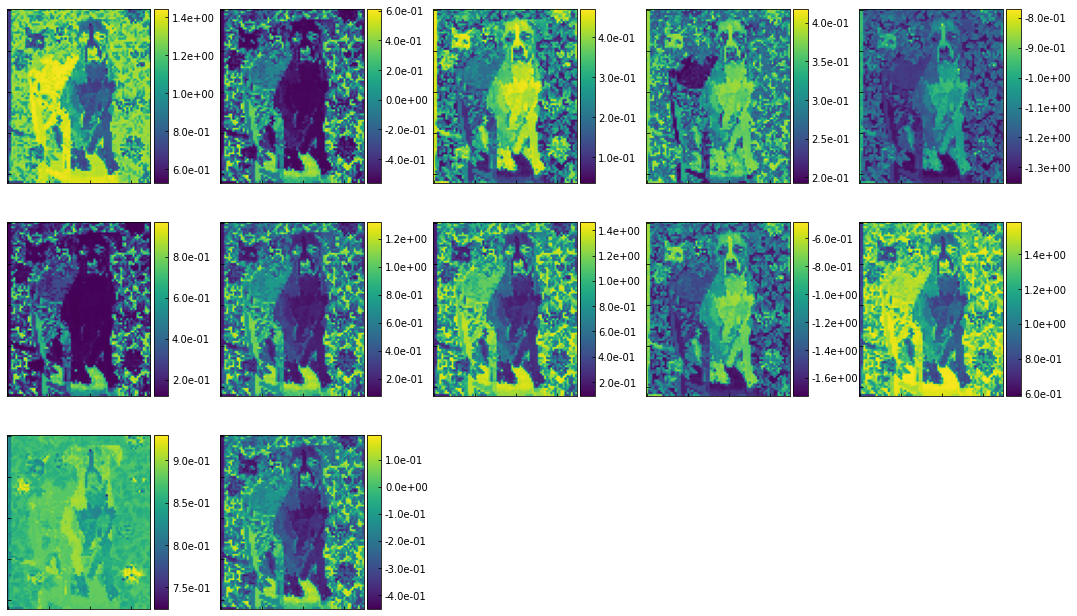

In [29]:
embedding_maps(encode, image)

- This does not really mean too much because the latent variables are all competing with one another


## LSTM Autoencoder with 3 Latent Variables


In [30]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [31]:
model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [32]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)

### Training


In [33]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)

100%|██████████| 19/19 [00:00<00:00, 231.63it/s]


Epoch 0, Train Loss: 2.1234
.............................


100%|██████████| 19/19 [00:00<00:00, 275.35it/s]


Epoch 1, Train Loss: 2.1185
.............................


100%|██████████| 19/19 [00:00<00:00, 275.16it/s]


Epoch 2, Train Loss: 2.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 269.92it/s]


Epoch 3, Train Loss: 2.1085
.............................


100%|██████████| 19/19 [00:00<00:00, 260.11it/s]


Epoch 4, Train Loss: 2.1035
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 5, Train Loss: 2.0984
.............................


100%|██████████| 19/19 [00:00<00:00, 245.61it/s]


Epoch 6, Train Loss: 2.0933
.............................


100%|██████████| 19/19 [00:00<00:00, 264.10it/s]


Epoch 7, Train Loss: 2.0882
.............................


100%|██████████| 19/19 [00:00<00:00, 243.49it/s]


Epoch 8, Train Loss: 2.0830
.............................


100%|██████████| 19/19 [00:00<00:00, 231.72it/s]


Epoch 9, Train Loss: 2.0777
.............................


100%|██████████| 19/19 [00:00<00:00, 253.22it/s]


Epoch 10, Train Loss: 2.0724
.............................


100%|██████████| 19/19 [00:00<00:00, 231.47it/s]


Epoch 11, Train Loss: 2.0670
.............................


100%|██████████| 19/19 [00:00<00:00, 246.87it/s]


Epoch 12, Train Loss: 2.0616
.............................


100%|██████████| 19/19 [00:00<00:00, 263.90it/s]


Epoch 13, Train Loss: 2.0561
.............................


100%|██████████| 19/19 [00:00<00:00, 260.10it/s]


Epoch 14, Train Loss: 2.0506
.............................


100%|██████████| 19/19 [00:00<00:00, 250.02it/s]


Epoch 15, Train Loss: 2.0449
.............................


100%|██████████| 19/19 [00:00<00:00, 286.23it/s]


Epoch 16, Train Loss: 2.0392
.............................


100%|██████████| 19/19 [00:00<00:00, 289.45it/s]


Epoch 17, Train Loss: 2.0334
.............................


100%|██████████| 19/19 [00:00<00:00, 287.92it/s]


Epoch 18, Train Loss: 2.0275
.............................


100%|██████████| 19/19 [00:00<00:00, 275.37it/s]


Epoch 19, Train Loss: 2.0216
.............................


100%|██████████| 19/19 [00:00<00:00, 283.37it/s]


Epoch 20, Train Loss: 2.0155
.............................


100%|██████████| 19/19 [00:00<00:00, 287.89it/s]


Epoch 21, Train Loss: 2.0094
.............................


100%|██████████| 19/19 [00:00<00:00, 283.39it/s]


Epoch 22, Train Loss: 2.0031
.............................


100%|██████████| 19/19 [00:00<00:00, 291.24it/s]


Epoch 23, Train Loss: 1.9967
.............................


100%|██████████| 19/19 [00:00<00:00, 296.87it/s]


Epoch 24, Train Loss: 1.9903
.............................


100%|██████████| 19/19 [00:00<00:00, 237.30it/s]


Epoch 25, Train Loss: 1.9837
.............................


100%|██████████| 19/19 [00:00<00:00, 284.90it/s]


Epoch 26, Train Loss: 1.9770
.............................


100%|██████████| 19/19 [00:00<00:00, 283.40it/s]


Epoch 27, Train Loss: 1.9702
.............................


100%|██████████| 19/19 [00:00<00:00, 292.32it/s]


Epoch 28, Train Loss: 1.9632
.............................


100%|██████████| 19/19 [00:00<00:00, 279.48it/s]


Epoch 29, Train Loss: 1.9562
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 30, Train Loss: 1.9490
.............................


100%|██████████| 19/19 [00:00<00:00, 283.52it/s]


Epoch 31, Train Loss: 1.9417
.............................


100%|██████████| 19/19 [00:00<00:00, 253.14it/s]


Epoch 32, Train Loss: 1.9342
.............................


100%|██████████| 19/19 [00:00<00:00, 275.17it/s]


Epoch 33, Train Loss: 1.9266
.............................


100%|██████████| 19/19 [00:00<00:00, 275.41it/s]


Epoch 34, Train Loss: 1.9189
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 35, Train Loss: 1.9111
.............................


100%|██████████| 19/19 [00:00<00:00, 267.64it/s]


Epoch 36, Train Loss: 1.9031
.............................


100%|██████████| 19/19 [00:00<00:00, 287.70it/s]


Epoch 37, Train Loss: 1.8949
.............................


100%|██████████| 19/19 [00:00<00:00, 279.25it/s]


Epoch 38, Train Loss: 1.8867
.............................


100%|██████████| 19/19 [00:00<00:00, 228.82it/s]


Epoch 39, Train Loss: 1.8782
.............................


100%|██████████| 19/19 [00:00<00:00, 297.03it/s]


Epoch 40, Train Loss: 1.8697
.............................


100%|██████████| 19/19 [00:00<00:00, 223.47it/s]


Epoch 41, Train Loss: 1.8610
.............................


100%|██████████| 19/19 [00:00<00:00, 249.90it/s]


Epoch 42, Train Loss: 1.8522
.............................


100%|██████████| 19/19 [00:00<00:00, 256.93it/s]


Epoch 43, Train Loss: 1.8433
.............................


100%|██████████| 19/19 [00:00<00:00, 263.89it/s]


Epoch 44, Train Loss: 1.8342
.............................


100%|██████████| 19/19 [00:00<00:00, 260.46it/s]


Epoch 45, Train Loss: 1.8250
.............................


100%|██████████| 19/19 [00:00<00:00, 253.22it/s]


Epoch 46, Train Loss: 1.8156
.............................


100%|██████████| 19/19 [00:00<00:00, 256.76it/s]


Epoch 47, Train Loss: 1.8062
.............................


100%|██████████| 19/19 [00:00<00:00, 271.97it/s]


Epoch 48, Train Loss: 1.7966
.............................


100%|██████████| 19/19 [00:00<00:00, 256.63it/s]


Epoch 49, Train Loss: 1.7869
.............................


100%|██████████| 19/19 [00:00<00:00, 263.86it/s]


Epoch 50, Train Loss: 1.7770
.............................


100%|██████████| 19/19 [00:00<00:00, 253.16it/s]


Epoch 51, Train Loss: 1.7671
.............................


100%|██████████| 19/19 [00:00<00:00, 243.58it/s]


Epoch 52, Train Loss: 1.7570
.............................


100%|██████████| 19/19 [00:00<00:00, 260.27it/s]


Epoch 53, Train Loss: 1.7468
.............................


100%|██████████| 19/19 [00:00<00:00, 246.59it/s]


Epoch 54, Train Loss: 1.7365
.............................


100%|██████████| 19/19 [00:00<00:00, 221.98it/s]


Epoch 55, Train Loss: 1.7260
.............................


100%|██████████| 19/19 [00:00<00:00, 256.82it/s]


Epoch 56, Train Loss: 1.7155
.............................


100%|██████████| 19/19 [00:00<00:00, 202.06it/s]


Epoch 57, Train Loss: 1.7049
.............................


100%|██████████| 19/19 [00:00<00:00, 263.81it/s]


Epoch 58, Train Loss: 1.6941
.............................


100%|██████████| 19/19 [00:00<00:00, 220.96it/s]


Epoch 59, Train Loss: 1.6833
.............................


100%|██████████| 19/19 [00:00<00:00, 249.94it/s]


Epoch 60, Train Loss: 1.6723
.............................


100%|██████████| 19/19 [00:00<00:00, 283.62it/s]


Epoch 61, Train Loss: 1.6613
.............................


100%|██████████| 19/19 [00:00<00:00, 240.55it/s]


Epoch 62, Train Loss: 1.6503
.............................


100%|██████████| 19/19 [00:00<00:00, 238.07it/s]


Epoch 63, Train Loss: 1.6391
.............................


100%|██████████| 19/19 [00:00<00:00, 256.62it/s]


Epoch 64, Train Loss: 1.6279
.............................


100%|██████████| 19/19 [00:00<00:00, 267.62it/s]


Epoch 65, Train Loss: 1.6167
.............................


100%|██████████| 19/19 [00:00<00:00, 292.21it/s]


Epoch 66, Train Loss: 1.6054
.............................


100%|██████████| 19/19 [00:00<00:00, 260.21it/s]


Epoch 67, Train Loss: 1.5942
.............................


100%|██████████| 19/19 [00:00<00:00, 267.73it/s]


Epoch 68, Train Loss: 1.5829
.............................


100%|██████████| 19/19 [00:00<00:00, 262.63it/s]


Epoch 69, Train Loss: 1.5717
.............................


100%|██████████| 19/19 [00:00<00:00, 260.21it/s]


Epoch 70, Train Loss: 1.5605
.............................


100%|██████████| 19/19 [00:00<00:00, 240.46it/s]


Epoch 71, Train Loss: 1.5493
.............................


100%|██████████| 19/19 [00:00<00:00, 243.53it/s]


Epoch 72, Train Loss: 1.5382
.............................


100%|██████████| 19/19 [00:00<00:00, 237.51it/s]


Epoch 73, Train Loss: 1.5272
.............................


100%|██████████| 19/19 [00:00<00:00, 267.47it/s]


Epoch 74, Train Loss: 1.5162
.............................


100%|██████████| 19/19 [00:00<00:00, 231.48it/s]


Epoch 75, Train Loss: 1.5052
.............................


100%|██████████| 19/19 [00:00<00:00, 259.25it/s]


Epoch 76, Train Loss: 1.4943
.............................


100%|██████████| 19/19 [00:00<00:00, 271.51it/s]


Epoch 77, Train Loss: 1.4835
.............................


100%|██████████| 19/19 [00:00<00:00, 267.59it/s]


Epoch 78, Train Loss: 1.4727
.............................


100%|██████████| 19/19 [00:00<00:00, 154.18it/s]


Epoch 79, Train Loss: 1.4620
.............................


100%|██████████| 19/19 [00:00<00:00, 253.24it/s]


Epoch 80, Train Loss: 1.4512
.............................


100%|██████████| 19/19 [00:00<00:00, 259.45it/s]


Epoch 81, Train Loss: 1.4405
.............................


100%|██████████| 19/19 [00:00<00:00, 213.41it/s]


Epoch 82, Train Loss: 1.4298
.............................


100%|██████████| 19/19 [00:00<00:00, 188.10it/s]


Epoch 83, Train Loss: 1.4191
.............................


100%|██████████| 19/19 [00:00<00:00, 283.42it/s]


Epoch 84, Train Loss: 1.4084
.............................


100%|██████████| 19/19 [00:00<00:00, 275.34it/s]


Epoch 85, Train Loss: 1.3976
.............................


100%|██████████| 19/19 [00:00<00:00, 271.31it/s]


Epoch 86, Train Loss: 1.3868
.............................


100%|██████████| 19/19 [00:00<00:00, 249.83it/s]


Epoch 87, Train Loss: 1.3759
.............................


100%|██████████| 19/19 [00:00<00:00, 256.77it/s]


Epoch 88, Train Loss: 1.3650
.............................


100%|██████████| 19/19 [00:00<00:00, 218.42it/s]


Epoch 89, Train Loss: 1.3539
.............................


100%|██████████| 19/19 [00:00<00:00, 271.33it/s]


Epoch 90, Train Loss: 1.3428
.............................


100%|██████████| 19/19 [00:00<00:00, 252.05it/s]


Epoch 91, Train Loss: 1.3315
.............................


100%|██████████| 19/19 [00:00<00:00, 250.02it/s]


Epoch 92, Train Loss: 1.3201
.............................


100%|██████████| 19/19 [00:00<00:00, 234.70it/s]


Epoch 93, Train Loss: 1.3086
.............................


100%|██████████| 19/19 [00:00<00:00, 254.10it/s]


Epoch 94, Train Loss: 1.2969
.............................


100%|██████████| 19/19 [00:00<00:00, 253.18it/s]


Epoch 95, Train Loss: 1.2851
.............................


100%|██████████| 19/19 [00:00<00:00, 246.85it/s]


Epoch 96, Train Loss: 1.2731
.............................


100%|██████████| 19/19 [00:00<00:00, 253.47it/s]


Epoch 97, Train Loss: 1.2610
.............................


100%|██████████| 19/19 [00:00<00:00, 240.20it/s]


Epoch 98, Train Loss: 1.2487
.............................


100%|██████████| 19/19 [00:00<00:00, 275.19it/s]


Epoch 99, Train Loss: 1.2363
.............................


100%|██████████| 19/19 [00:00<00:00, 246.59it/s]


Epoch 100, Train Loss: 1.2237
.............................


100%|██████████| 19/19 [00:00<00:00, 260.31it/s]


Epoch 101, Train Loss: 1.2110
.............................


100%|██████████| 19/19 [00:00<00:00, 243.43it/s]


Epoch 102, Train Loss: 1.1981
.............................


100%|██████████| 19/19 [00:00<00:00, 263.87it/s]


Epoch 103, Train Loss: 1.1851
.............................


100%|██████████| 19/19 [00:00<00:00, 253.18it/s]


Epoch 104, Train Loss: 1.1720
.............................


100%|██████████| 19/19 [00:00<00:00, 223.54it/s]


Epoch 105, Train Loss: 1.1587
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 106, Train Loss: 1.1453
.............................


100%|██████████| 19/19 [00:00<00:00, 256.59it/s]


Epoch 107, Train Loss: 1.1318
.............................


100%|██████████| 19/19 [00:00<00:00, 240.39it/s]


Epoch 108, Train Loss: 1.1183
.............................


100%|██████████| 19/19 [00:00<00:00, 208.89it/s]


Epoch 109, Train Loss: 1.1046
.............................


100%|██████████| 19/19 [00:00<00:00, 220.79it/s]


Epoch 110, Train Loss: 1.0909
.............................


100%|██████████| 19/19 [00:00<00:00, 263.87it/s]


Epoch 111, Train Loss: 1.0771
.............................


100%|██████████| 19/19 [00:00<00:00, 234.61it/s]


Epoch 112, Train Loss: 1.0633
.............................


100%|██████████| 19/19 [00:00<00:00, 260.12it/s]


Epoch 113, Train Loss: 1.0495
.............................


100%|██████████| 19/19 [00:00<00:00, 223.46it/s]


Epoch 114, Train Loss: 1.0357
.............................


100%|██████████| 19/19 [00:00<00:00, 246.61it/s]


Epoch 115, Train Loss: 1.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 218.44it/s]


Epoch 116, Train Loss: 1.0080
.............................


100%|██████████| 19/19 [00:00<00:00, 231.55it/s]


Epoch 117, Train Loss: 0.9942
.............................


100%|██████████| 19/19 [00:00<00:00, 240.58it/s]


Epoch 118, Train Loss: 0.9805
.............................


100%|██████████| 19/19 [00:00<00:00, 256.56it/s]


Epoch 119, Train Loss: 0.9668
.............................


100%|██████████| 19/19 [00:00<00:00, 260.26it/s]


Epoch 120, Train Loss: 0.9531
.............................


100%|██████████| 19/19 [00:00<00:00, 271.48it/s]


Epoch 121, Train Loss: 0.9396
.............................


100%|██████████| 19/19 [00:00<00:00, 285.75it/s]


Epoch 122, Train Loss: 0.9261
.............................


100%|██████████| 19/19 [00:00<00:00, 279.39it/s]


Epoch 123, Train Loss: 0.9127
.............................


100%|██████████| 19/19 [00:00<00:00, 292.33it/s]


Epoch 124, Train Loss: 0.8995
.............................


100%|██████████| 19/19 [00:00<00:00, 275.18it/s]


Epoch 125, Train Loss: 0.8863
.............................


100%|██████████| 19/19 [00:00<00:00, 267.66it/s]


Epoch 126, Train Loss: 0.8733
.............................


100%|██████████| 19/19 [00:00<00:00, 271.49it/s]


Epoch 127, Train Loss: 0.8603
.............................


100%|██████████| 19/19 [00:00<00:00, 271.23it/s]


Epoch 128, Train Loss: 0.8475
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 129, Train Loss: 0.8348
.............................


100%|██████████| 19/19 [00:00<00:00, 223.45it/s]


Epoch 130, Train Loss: 0.8222
.............................


100%|██████████| 19/19 [00:00<00:00, 190.03it/s]


Epoch 131, Train Loss: 0.8097
.............................


100%|██████████| 19/19 [00:00<00:00, 240.11it/s]


Epoch 132, Train Loss: 0.7973
.............................


100%|██████████| 19/19 [00:00<00:00, 246.64it/s]


Epoch 133, Train Loss: 0.7851
.............................


100%|██████████| 19/19 [00:00<00:00, 274.95it/s]


Epoch 134, Train Loss: 0.7729
.............................


100%|██████████| 19/19 [00:00<00:00, 210.29it/s]


Epoch 135, Train Loss: 0.7609
.............................


100%|██████████| 19/19 [00:00<00:00, 182.71it/s]


Epoch 136, Train Loss: 0.7489
.............................


100%|██████████| 19/19 [00:00<00:00, 243.37it/s]


Epoch 137, Train Loss: 0.7371
.............................


100%|██████████| 19/19 [00:00<00:00, 263.21it/s]


Epoch 138, Train Loss: 0.7254
.............................


100%|██████████| 19/19 [00:00<00:00, 217.66it/s]


Epoch 139, Train Loss: 0.7137
.............................


100%|██████████| 19/19 [00:00<00:00, 229.64it/s]


Epoch 140, Train Loss: 0.7022
.............................


100%|██████████| 19/19 [00:00<00:00, 276.42it/s]


Epoch 141, Train Loss: 0.6908
.............................


100%|██████████| 19/19 [00:00<00:00, 225.86it/s]


Epoch 142, Train Loss: 0.6794
.............................


100%|██████████| 19/19 [00:00<00:00, 237.14it/s]


Epoch 143, Train Loss: 0.6682
.............................


100%|██████████| 19/19 [00:00<00:00, 210.58it/s]


Epoch 144, Train Loss: 0.6570
.............................


100%|██████████| 19/19 [00:00<00:00, 263.89it/s]


Epoch 145, Train Loss: 0.6460
.............................


100%|██████████| 19/19 [00:00<00:00, 214.62it/s]


Epoch 146, Train Loss: 0.6351
.............................


100%|██████████| 19/19 [00:00<00:00, 184.40it/s]


Epoch 147, Train Loss: 0.6243
.............................


100%|██████████| 19/19 [00:00<00:00, 234.30it/s]


Epoch 148, Train Loss: 0.6136
.............................


100%|██████████| 19/19 [00:00<00:00, 267.04it/s]


Epoch 149, Train Loss: 0.6030
.............................


100%|██████████| 19/19 [00:00<00:00, 245.87it/s]


Epoch 150, Train Loss: 0.5925
.............................


100%|██████████| 19/19 [00:00<00:00, 241.32it/s]


Epoch 151, Train Loss: 0.5822
.............................


100%|██████████| 19/19 [00:00<00:00, 259.83it/s]


Epoch 152, Train Loss: 0.5720
.............................


100%|██████████| 19/19 [00:00<00:00, 228.92it/s]


Epoch 153, Train Loss: 0.5619
.............................


100%|██████████| 19/19 [00:00<00:00, 224.26it/s]


Epoch 154, Train Loss: 0.5520
.............................


100%|██████████| 19/19 [00:00<00:00, 229.21it/s]


Epoch 155, Train Loss: 0.5422
.............................


100%|██████████| 19/19 [00:00<00:00, 259.98it/s]


Epoch 156, Train Loss: 0.5326
.............................


100%|██████████| 19/19 [00:00<00:00, 264.04it/s]


Epoch 157, Train Loss: 0.5231
.............................


100%|██████████| 19/19 [00:00<00:00, 254.41it/s]


Epoch 158, Train Loss: 0.5138
.............................


100%|██████████| 19/19 [00:00<00:00, 256.49it/s]


Epoch 159, Train Loss: 0.5046
.............................


100%|██████████| 19/19 [00:00<00:00, 283.40it/s]


Epoch 160, Train Loss: 0.4956
.............................


100%|██████████| 19/19 [00:00<00:00, 263.75it/s]


Epoch 161, Train Loss: 0.4867
.............................


100%|██████████| 19/19 [00:00<00:00, 255.68it/s]


Epoch 162, Train Loss: 0.4780
.............................


100%|██████████| 19/19 [00:00<00:00, 252.31it/s]


Epoch 163, Train Loss: 0.4695
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 164, Train Loss: 0.4611
.............................


100%|██████████| 19/19 [00:00<00:00, 275.33it/s]


Epoch 165, Train Loss: 0.4529
.............................


100%|██████████| 19/19 [00:00<00:00, 242.43it/s]


Epoch 166, Train Loss: 0.4448
.............................


100%|██████████| 19/19 [00:00<00:00, 228.57it/s]


Epoch 167, Train Loss: 0.4369
.............................


100%|██████████| 19/19 [00:00<00:00, 262.91it/s]


Epoch 168, Train Loss: 0.4292
.............................


100%|██████████| 19/19 [00:00<00:00, 263.74it/s]


Epoch 169, Train Loss: 0.4217
.............................


100%|██████████| 19/19 [00:00<00:00, 228.56it/s]


Epoch 170, Train Loss: 0.4143
.............................


100%|██████████| 19/19 [00:00<00:00, 240.40it/s]


Epoch 171, Train Loss: 0.4071
.............................


100%|██████████| 19/19 [00:00<00:00, 243.38it/s]


Epoch 172, Train Loss: 0.4000
.............................


100%|██████████| 19/19 [00:00<00:00, 240.35it/s]


Epoch 173, Train Loss: 0.3931
.............................


100%|██████████| 19/19 [00:00<00:00, 218.22it/s]


Epoch 174, Train Loss: 0.3864
.............................


100%|██████████| 19/19 [00:00<00:00, 228.90it/s]


Epoch 175, Train Loss: 0.3798
.............................


100%|██████████| 19/19 [00:00<00:00, 203.93it/s]


Epoch 176, Train Loss: 0.3734
.............................


100%|██████████| 19/19 [00:00<00:00, 246.63it/s]


Epoch 177, Train Loss: 0.3672
.............................


100%|██████████| 19/19 [00:00<00:00, 220.78it/s]


Epoch 178, Train Loss: 0.3611
.............................


100%|██████████| 19/19 [00:00<00:00, 235.98it/s]


Epoch 179, Train Loss: 0.3552
.............................


100%|██████████| 19/19 [00:00<00:00, 261.88it/s]


Epoch 180, Train Loss: 0.3494
.............................


100%|██████████| 19/19 [00:00<00:00, 224.71it/s]


Epoch 181, Train Loss: 0.3438
.............................


100%|██████████| 19/19 [00:00<00:00, 234.05it/s]


Epoch 182, Train Loss: 0.3383
.............................


100%|██████████| 19/19 [00:00<00:00, 239.85it/s]


Epoch 183, Train Loss: 0.3330
.............................


100%|██████████| 19/19 [00:00<00:00, 249.17it/s]


Epoch 184, Train Loss: 0.3279
.............................


100%|██████████| 19/19 [00:00<00:00, 244.89it/s]


Epoch 185, Train Loss: 0.3229
.............................


100%|██████████| 19/19 [00:00<00:00, 197.66it/s]


Epoch 186, Train Loss: 0.3180
.............................


100%|██████████| 19/19 [00:00<00:00, 269.38it/s]


Epoch 187, Train Loss: 0.3133
.............................


100%|██████████| 19/19 [00:00<00:00, 266.16it/s]


Epoch 188, Train Loss: 0.3088
.............................


100%|██████████| 19/19 [00:00<00:00, 239.31it/s]


Epoch 189, Train Loss: 0.3043
.............................


100%|██████████| 19/19 [00:00<00:00, 240.49it/s]


Epoch 190, Train Loss: 0.3001
.............................


100%|██████████| 19/19 [00:00<00:00, 253.21it/s]


Epoch 191, Train Loss: 0.2959
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 192, Train Loss: 0.2919
.............................


100%|██████████| 19/19 [00:00<00:00, 246.75it/s]


Epoch 193, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 235.66it/s]


Epoch 194, Train Loss: 0.2842
.............................


100%|██████████| 19/19 [00:00<00:00, 260.27it/s]


Epoch 195, Train Loss: 0.2806
.............................


100%|██████████| 19/19 [00:00<00:00, 278.93it/s]


Epoch 196, Train Loss: 0.2771
.............................


100%|██████████| 19/19 [00:00<00:00, 256.03it/s]


Epoch 197, Train Loss: 0.2737
.............................


100%|██████████| 19/19 [00:00<00:00, 243.54it/s]


Epoch 198, Train Loss: 0.2704
.............................


100%|██████████| 19/19 [00:00<00:00, 239.79it/s]


Epoch 199, Train Loss: 0.2672
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 200, Train Loss: 0.2642
.............................


100%|██████████| 19/19 [00:00<00:00, 249.82it/s]


Epoch 201, Train Loss: 0.2612
.............................


100%|██████████| 19/19 [00:00<00:00, 257.80it/s]


Epoch 202, Train Loss: 0.2584
.............................


100%|██████████| 19/19 [00:00<00:00, 253.21it/s]


Epoch 203, Train Loss: 0.2556
.............................


100%|██████████| 19/19 [00:00<00:00, 279.24it/s]


Epoch 204, Train Loss: 0.2530
.............................


100%|██████████| 19/19 [00:00<00:00, 279.63it/s]


Epoch 205, Train Loss: 0.2505
.............................


100%|██████████| 19/19 [00:00<00:00, 243.34it/s]


Epoch 206, Train Loss: 0.2480
.............................


100%|██████████| 19/19 [00:00<00:00, 246.64it/s]


Epoch 207, Train Loss: 0.2456
.............................


100%|██████████| 19/19 [00:00<00:00, 267.39it/s]


Epoch 208, Train Loss: 0.2434
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 209, Train Loss: 0.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 236.34it/s]


Epoch 210, Train Loss: 0.2391
.............................


100%|██████████| 19/19 [00:00<00:00, 215.86it/s]


Epoch 211, Train Loss: 0.2371
.............................


100%|██████████| 19/19 [00:00<00:00, 253.13it/s]


Epoch 212, Train Loss: 0.2351
.............................


100%|██████████| 19/19 [00:00<00:00, 249.97it/s]


Epoch 213, Train Loss: 0.2332
.............................


100%|██████████| 19/19 [00:00<00:00, 246.82it/s]


Epoch 214, Train Loss: 0.2314
.............................


100%|██████████| 19/19 [00:00<00:00, 260.30it/s]


Epoch 215, Train Loss: 0.2297
.............................


100%|██████████| 19/19 [00:00<00:00, 275.16it/s]


Epoch 216, Train Loss: 0.2280
.............................


100%|██████████| 19/19 [00:00<00:00, 256.76it/s]


Epoch 217, Train Loss: 0.2264
.............................


100%|██████████| 19/19 [00:00<00:00, 283.59it/s]


Epoch 218, Train Loss: 0.2249
.............................


100%|██████████| 19/19 [00:00<00:00, 223.71it/s]


Epoch 219, Train Loss: 0.2234
.............................


100%|██████████| 19/19 [00:00<00:00, 218.41it/s]


Epoch 220, Train Loss: 0.2220
.............................


100%|██████████| 19/19 [00:00<00:00, 189.92it/s]


Epoch 221, Train Loss: 0.2206
.............................


100%|██████████| 19/19 [00:00<00:00, 249.51it/s]


Epoch 222, Train Loss: 0.2193
.............................


100%|██████████| 19/19 [00:00<00:00, 267.65it/s]


Epoch 223, Train Loss: 0.2181
.............................


100%|██████████| 19/19 [00:00<00:00, 240.16it/s]


Epoch 224, Train Loss: 0.2168
.............................


100%|██████████| 19/19 [00:00<00:00, 236.99it/s]


Epoch 225, Train Loss: 0.2157
.............................


100%|██████████| 19/19 [00:00<00:00, 231.65it/s]


Epoch 226, Train Loss: 0.2146
.............................


100%|██████████| 19/19 [00:00<00:00, 271.60it/s]


Epoch 227, Train Loss: 0.2135
.............................


100%|██████████| 19/19 [00:00<00:00, 279.03it/s]


Epoch 228, Train Loss: 0.2124
.............................


100%|██████████| 19/19 [00:00<00:00, 253.35it/s]


Epoch 229, Train Loss: 0.2114
.............................


100%|██████████| 19/19 [00:00<00:00, 253.34it/s]


Epoch 230, Train Loss: 0.2104
.............................


100%|██████████| 19/19 [00:00<00:00, 259.41it/s]


Epoch 231, Train Loss: 0.2095
.............................


100%|██████████| 19/19 [00:00<00:00, 263.86it/s]


Epoch 232, Train Loss: 0.2086
.............................


100%|██████████| 19/19 [00:00<00:00, 274.95it/s]


Epoch 233, Train Loss: 0.2077
.............................


100%|██████████| 19/19 [00:00<00:00, 287.72it/s]


Epoch 234, Train Loss: 0.2069
.............................


100%|██████████| 19/19 [00:00<00:00, 279.53it/s]


Epoch 235, Train Loss: 0.2061
.............................


100%|██████████| 19/19 [00:00<00:00, 271.25it/s]


Epoch 236, Train Loss: 0.2053
.............................


100%|██████████| 19/19 [00:00<00:00, 286.55it/s]


Epoch 237, Train Loss: 0.2045
.............................


100%|██████████| 19/19 [00:00<00:00, 279.41it/s]


Epoch 238, Train Loss: 0.2038
.............................


100%|██████████| 19/19 [00:00<00:00, 275.29it/s]


Epoch 239, Train Loss: 0.2030
.............................


100%|██████████| 19/19 [00:00<00:00, 263.28it/s]


Epoch 240, Train Loss: 0.2023
.............................


100%|██████████| 19/19 [00:00<00:00, 292.35it/s]


Epoch 241, Train Loss: 0.2016
.............................


100%|██████████| 19/19 [00:00<00:00, 287.69it/s]


Epoch 242, Train Loss: 0.2010
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 243, Train Loss: 0.2003
.............................


100%|██████████| 19/19 [00:00<00:00, 292.40it/s]


Epoch 244, Train Loss: 0.1997
.............................


100%|██████████| 19/19 [00:00<00:00, 283.62it/s]


Epoch 245, Train Loss: 0.1991
.............................


100%|██████████| 19/19 [00:00<00:00, 275.55it/s]


Epoch 246, Train Loss: 0.1985
.............................


100%|██████████| 19/19 [00:00<00:00, 283.58it/s]


Epoch 247, Train Loss: 0.1979
.............................


100%|██████████| 19/19 [00:00<00:00, 275.38it/s]


Epoch 248, Train Loss: 0.1973
.............................


100%|██████████| 19/19 [00:00<00:00, 278.24it/s]


Epoch 249, Train Loss: 0.1967
.............................


100%|██████████| 19/19 [00:00<00:00, 253.05it/s]


Epoch 250, Train Loss: 0.1962
.............................


100%|██████████| 19/19 [00:00<00:00, 271.40it/s]


Epoch 251, Train Loss: 0.1956
.............................


100%|██████████| 19/19 [00:00<00:00, 271.43it/s]


Epoch 252, Train Loss: 0.1951
.............................


100%|██████████| 19/19 [00:00<00:00, 272.64it/s]


Epoch 253, Train Loss: 0.1946
.............................


100%|██████████| 19/19 [00:00<00:00, 256.64it/s]


Epoch 254, Train Loss: 0.1941
.............................


100%|██████████| 19/19 [00:00<00:00, 275.19it/s]


Epoch 255, Train Loss: 0.1935
.............................


100%|██████████| 19/19 [00:00<00:00, 260.97it/s]


Epoch 256, Train Loss: 0.1930
.............................


100%|██████████| 19/19 [00:00<00:00, 279.44it/s]


Epoch 257, Train Loss: 0.1925
.............................


100%|██████████| 19/19 [00:00<00:00, 253.08it/s]


Epoch 258, Train Loss: 0.1921
.............................


100%|██████████| 19/19 [00:00<00:00, 275.53it/s]


Epoch 259, Train Loss: 0.1916
.............................


100%|██████████| 19/19 [00:00<00:00, 279.48it/s]


Epoch 260, Train Loss: 0.1911
.............................


100%|██████████| 19/19 [00:00<00:00, 275.33it/s]


Epoch 261, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 252.99it/s]


Epoch 262, Train Loss: 0.1901
.............................


100%|██████████| 19/19 [00:00<00:00, 267.54it/s]


Epoch 263, Train Loss: 0.1897
.............................


100%|██████████| 19/19 [00:00<00:00, 267.60it/s]


Epoch 264, Train Loss: 0.1892
.............................


100%|██████████| 19/19 [00:00<00:00, 172.82it/s]


Epoch 265, Train Loss: 0.1887
.............................


100%|██████████| 19/19 [00:00<00:00, 237.56it/s]


Epoch 266, Train Loss: 0.1883
.............................


100%|██████████| 19/19 [00:00<00:00, 235.63it/s]


Epoch 267, Train Loss: 0.1878
.............................


100%|██████████| 19/19 [00:00<00:00, 274.69it/s]


Epoch 268, Train Loss: 0.1874
.............................


100%|██████████| 19/19 [00:00<00:00, 240.37it/s]


Epoch 269, Train Loss: 0.1869
.............................


100%|██████████| 19/19 [00:00<00:00, 246.68it/s]


Epoch 270, Train Loss: 0.1865
.............................


100%|██████████| 19/19 [00:00<00:00, 234.47it/s]


Epoch 271, Train Loss: 0.1860
.............................


100%|██████████| 19/19 [00:00<00:00, 246.44it/s]


Epoch 272, Train Loss: 0.1856
.............................


100%|██████████| 19/19 [00:00<00:00, 222.84it/s]


Epoch 273, Train Loss: 0.1851
.............................


100%|██████████| 19/19 [00:00<00:00, 264.51it/s]


Epoch 274, Train Loss: 0.1847
.............................


100%|██████████| 19/19 [00:00<00:00, 185.18it/s]


Epoch 275, Train Loss: 0.1843
.............................


100%|██████████| 19/19 [00:00<00:00, 233.65it/s]


Epoch 276, Train Loss: 0.1838
.............................


100%|██████████| 19/19 [00:00<00:00, 249.52it/s]


Epoch 277, Train Loss: 0.1834
.............................


100%|██████████| 19/19 [00:00<00:00, 247.91it/s]


Epoch 278, Train Loss: 0.1830
.............................


100%|██████████| 19/19 [00:00<00:00, 249.73it/s]


Epoch 279, Train Loss: 0.1825
.............................


100%|██████████| 19/19 [00:00<00:00, 263.38it/s]


Epoch 280, Train Loss: 0.1821
.............................


100%|██████████| 19/19 [00:00<00:00, 256.53it/s]


Epoch 281, Train Loss: 0.1817
.............................


100%|██████████| 19/19 [00:00<00:00, 238.45it/s]


Epoch 282, Train Loss: 0.1813
.............................


100%|██████████| 19/19 [00:00<00:00, 249.33it/s]


Epoch 283, Train Loss: 0.1808
.............................


100%|██████████| 19/19 [00:00<00:00, 271.28it/s]


Epoch 284, Train Loss: 0.1804
.............................


100%|██████████| 19/19 [00:00<00:00, 275.14it/s]


Epoch 285, Train Loss: 0.1800
.............................


100%|██████████| 19/19 [00:00<00:00, 242.73it/s]


Epoch 286, Train Loss: 0.1796
.............................


100%|██████████| 19/19 [00:00<00:00, 262.60it/s]


Epoch 287, Train Loss: 0.1792
.............................


100%|██████████| 19/19 [00:00<00:00, 267.64it/s]


Epoch 288, Train Loss: 0.1787
.............................


100%|██████████| 19/19 [00:00<00:00, 243.17it/s]


Epoch 289, Train Loss: 0.1783
.............................


100%|██████████| 19/19 [00:00<00:00, 246.60it/s]


Epoch 290, Train Loss: 0.1779
.............................


100%|██████████| 19/19 [00:00<00:00, 263.34it/s]


Epoch 291, Train Loss: 0.1775
.............................


100%|██████████| 19/19 [00:00<00:00, 246.87it/s]


Epoch 292, Train Loss: 0.1771
.............................


100%|██████████| 19/19 [00:00<00:00, 279.40it/s]


Epoch 293, Train Loss: 0.1767
.............................


100%|██████████| 19/19 [00:00<00:00, 237.55it/s]


Epoch 294, Train Loss: 0.1763
.............................


100%|██████████| 19/19 [00:00<00:00, 265.51it/s]


Epoch 295, Train Loss: 0.1759
.............................


100%|██████████| 19/19 [00:00<00:00, 256.61it/s]


Epoch 296, Train Loss: 0.1755
.............................


100%|██████████| 19/19 [00:00<00:00, 275.56it/s]


Epoch 297, Train Loss: 0.1751
.............................


100%|██████████| 19/19 [00:00<00:00, 253.13it/s]


Epoch 298, Train Loss: 0.1747
.............................


100%|██████████| 19/19 [00:00<00:00, 250.10it/s]


Epoch 299, Train Loss: 0.1743
.............................


100%|██████████| 19/19 [00:00<00:00, 259.68it/s]


Epoch 300, Train Loss: 0.1739
.............................


100%|██████████| 19/19 [00:00<00:00, 271.39it/s]


Epoch 301, Train Loss: 0.1735
.............................


100%|██████████| 19/19 [00:00<00:00, 245.09it/s]


Epoch 302, Train Loss: 0.1731
.............................


100%|██████████| 19/19 [00:00<00:00, 240.40it/s]


Epoch 303, Train Loss: 0.1727
.............................


100%|██████████| 19/19 [00:00<00:00, 246.71it/s]


Epoch 304, Train Loss: 0.1723
.............................


100%|██████████| 19/19 [00:00<00:00, 243.07it/s]


Epoch 305, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 234.39it/s]


Epoch 306, Train Loss: 0.1715
.............................


100%|██████████| 19/19 [00:00<00:00, 200.00it/s]


Epoch 307, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 271.75it/s]


Epoch 308, Train Loss: 0.1707
.............................


100%|██████████| 19/19 [00:00<00:00, 263.75it/s]


Epoch 309, Train Loss: 0.1703
.............................


100%|██████████| 19/19 [00:00<00:00, 234.26it/s]


Epoch 310, Train Loss: 0.1699
.............................


100%|██████████| 19/19 [00:00<00:00, 245.94it/s]


Epoch 311, Train Loss: 0.1695
.............................


100%|██████████| 19/19 [00:00<00:00, 243.57it/s]


Epoch 312, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 262.25it/s]


Epoch 313, Train Loss: 0.1688
.............................


100%|██████████| 19/19 [00:00<00:00, 242.83it/s]


Epoch 314, Train Loss: 0.1684
.............................


100%|██████████| 19/19 [00:00<00:00, 253.05it/s]


Epoch 315, Train Loss: 0.1680
.............................


100%|██████████| 19/19 [00:00<00:00, 267.37it/s]


Epoch 316, Train Loss: 0.1677
.............................


100%|██████████| 19/19 [00:00<00:00, 234.34it/s]


Epoch 317, Train Loss: 0.1673
.............................


100%|██████████| 19/19 [00:00<00:00, 201.99it/s]


Epoch 318, Train Loss: 0.1669
.............................


100%|██████████| 19/19 [00:00<00:00, 202.07it/s]


Epoch 319, Train Loss: 0.1665
.............................


100%|██████████| 19/19 [00:00<00:00, 271.24it/s]


Epoch 320, Train Loss: 0.1662
.............................


100%|██████████| 19/19 [00:00<00:00, 243.53it/s]


Epoch 321, Train Loss: 0.1658
.............................


100%|██████████| 19/19 [00:00<00:00, 231.38it/s]


Epoch 322, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 246.76it/s]


Epoch 323, Train Loss: 0.1651
.............................


100%|██████████| 19/19 [00:00<00:00, 263.89it/s]


Epoch 324, Train Loss: 0.1647
.............................


100%|██████████| 19/19 [00:00<00:00, 230.47it/s]


Epoch 325, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 245.47it/s]


Epoch 326, Train Loss: 0.1640
.............................


100%|██████████| 19/19 [00:00<00:00, 267.69it/s]


Epoch 327, Train Loss: 0.1636
.............................


100%|██████████| 19/19 [00:00<00:00, 279.27it/s]


Epoch 328, Train Loss: 0.1633
.............................


100%|██████████| 19/19 [00:00<00:00, 243.46it/s]


Epoch 329, Train Loss: 0.1629
.............................


100%|██████████| 19/19 [00:00<00:00, 228.79it/s]


Epoch 330, Train Loss: 0.1626
.............................


100%|██████████| 19/19 [00:00<00:00, 263.74it/s]


Epoch 331, Train Loss: 0.1622
.............................


100%|██████████| 19/19 [00:00<00:00, 283.45it/s]


Epoch 332, Train Loss: 0.1619
.............................


100%|██████████| 19/19 [00:00<00:00, 240.49it/s]


Epoch 333, Train Loss: 0.1615
.............................


100%|██████████| 19/19 [00:00<00:00, 237.14it/s]


Epoch 334, Train Loss: 0.1612
.............................


100%|██████████| 19/19 [00:00<00:00, 249.99it/s]


Epoch 335, Train Loss: 0.1608
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 336, Train Loss: 0.1605
.............................


100%|██████████| 19/19 [00:00<00:00, 241.79it/s]


Epoch 337, Train Loss: 0.1602
.............................


100%|██████████| 19/19 [00:00<00:00, 213.48it/s]


Epoch 338, Train Loss: 0.1598
.............................


100%|██████████| 19/19 [00:00<00:00, 242.94it/s]


Epoch 339, Train Loss: 0.1595
.............................


100%|██████████| 19/19 [00:00<00:00, 279.63it/s]


Epoch 340, Train Loss: 0.1592
.............................


100%|██████████| 19/19 [00:00<00:00, 246.74it/s]


Epoch 341, Train Loss: 0.1588
.............................


100%|██████████| 19/19 [00:00<00:00, 243.00it/s]


Epoch 342, Train Loss: 0.1585
.............................


100%|██████████| 19/19 [00:00<00:00, 220.59it/s]


Epoch 343, Train Loss: 0.1582
.............................


100%|██████████| 19/19 [00:00<00:00, 228.91it/s]


Epoch 344, Train Loss: 0.1578
.............................


100%|██████████| 19/19 [00:00<00:00, 227.59it/s]


Epoch 345, Train Loss: 0.1575
.............................


100%|██████████| 19/19 [00:00<00:00, 242.86it/s]


Epoch 346, Train Loss: 0.1572
.............................


100%|██████████| 19/19 [00:00<00:00, 243.49it/s]


Epoch 347, Train Loss: 0.1569
.............................


100%|██████████| 19/19 [00:00<00:00, 259.57it/s]


Epoch 348, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 250.03it/s]


Epoch 349, Train Loss: 0.1562
.............................


100%|██████████| 19/19 [00:00<00:00, 225.63it/s]


Epoch 350, Train Loss: 0.1559
.............................


100%|██████████| 19/19 [00:00<00:00, 229.73it/s]


Epoch 351, Train Loss: 0.1556
.............................


100%|██████████| 19/19 [00:00<00:00, 260.03it/s]


Epoch 352, Train Loss: 0.1553
.............................


100%|██████████| 19/19 [00:00<00:00, 234.58it/s]


Epoch 353, Train Loss: 0.1550
.............................


100%|██████████| 19/19 [00:00<00:00, 179.16it/s]


Epoch 354, Train Loss: 0.1547
.............................


100%|██████████| 19/19 [00:00<00:00, 199.61it/s]


Epoch 355, Train Loss: 0.1544
.............................


100%|██████████| 19/19 [00:00<00:00, 256.25it/s]


Epoch 356, Train Loss: 0.1541
.............................


100%|██████████| 19/19 [00:00<00:00, 253.10it/s]


Epoch 357, Train Loss: 0.1538
.............................


100%|██████████| 19/19 [00:00<00:00, 224.59it/s]


Epoch 358, Train Loss: 0.1535
.............................


100%|██████████| 19/19 [00:00<00:00, 243.36it/s]


Epoch 359, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 263.17it/s]


Epoch 360, Train Loss: 0.1529
.............................


100%|██████████| 19/19 [00:00<00:00, 267.66it/s]


Epoch 361, Train Loss: 0.1526
.............................


100%|██████████| 19/19 [00:00<00:00, 253.21it/s]


Epoch 362, Train Loss: 0.1523
.............................


100%|██████████| 19/19 [00:00<00:00, 231.44it/s]


Epoch 363, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 263.12it/s]


Epoch 364, Train Loss: 0.1518
.............................


100%|██████████| 19/19 [00:00<00:00, 279.20it/s]


Epoch 365, Train Loss: 0.1515
.............................


100%|██████████| 19/19 [00:00<00:00, 260.36it/s]


Epoch 366, Train Loss: 0.1512
.............................


100%|██████████| 19/19 [00:00<00:00, 203.50it/s]


Epoch 367, Train Loss: 0.1509
.............................


100%|██████████| 19/19 [00:00<00:00, 260.01it/s]


Epoch 368, Train Loss: 0.1506
.............................


100%|██████████| 19/19 [00:00<00:00, 256.67it/s]


Epoch 369, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 260.13it/s]


Epoch 370, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 228.81it/s]


Epoch 371, Train Loss: 0.1498
.............................


100%|██████████| 19/19 [00:00<00:00, 253.46it/s]


Epoch 372, Train Loss: 0.1495
.............................


100%|██████████| 19/19 [00:00<00:00, 253.01it/s]


Epoch 373, Train Loss: 0.1493
.............................


100%|██████████| 19/19 [00:00<00:00, 253.29it/s]


Epoch 374, Train Loss: 0.1490
.............................


100%|██████████| 19/19 [00:00<00:00, 228.90it/s]


Epoch 375, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 229.96it/s]


Epoch 376, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 243.58it/s]


Epoch 377, Train Loss: 0.1482
.............................


100%|██████████| 19/19 [00:00<00:00, 256.63it/s]


Epoch 378, Train Loss: 0.1479
.............................


100%|██████████| 19/19 [00:00<00:00, 246.12it/s]


Epoch 379, Train Loss: 0.1477
.............................


100%|██████████| 19/19 [00:00<00:00, 275.39it/s]


Epoch 380, Train Loss: 0.1474
.............................


100%|██████████| 19/19 [00:00<00:00, 263.98it/s]


Epoch 381, Train Loss: 0.1471
.............................


100%|██████████| 19/19 [00:00<00:00, 237.48it/s]


Epoch 382, Train Loss: 0.1469
.............................


100%|██████████| 19/19 [00:00<00:00, 231.53it/s]


Epoch 383, Train Loss: 0.1466
.............................


100%|██████████| 19/19 [00:00<00:00, 249.97it/s]


Epoch 384, Train Loss: 0.1464
.............................


100%|██████████| 19/19 [00:00<00:00, 247.56it/s]


Epoch 385, Train Loss: 0.1461
.............................


100%|██████████| 19/19 [00:00<00:00, 256.60it/s]


Epoch 386, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 387, Train Loss: 0.1456
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 388, Train Loss: 0.1454
.............................


100%|██████████| 19/19 [00:00<00:00, 249.61it/s]


Epoch 389, Train Loss: 0.1451
.............................


100%|██████████| 19/19 [00:00<00:00, 234.42it/s]


Epoch 390, Train Loss: 0.1449
.............................


100%|██████████| 19/19 [00:00<00:00, 218.70it/s]


Epoch 391, Train Loss: 0.1446
.............................


100%|██████████| 19/19 [00:00<00:00, 237.42it/s]


Epoch 392, Train Loss: 0.1444
.............................


100%|██████████| 19/19 [00:00<00:00, 259.10it/s]


Epoch 393, Train Loss: 0.1442
.............................


100%|██████████| 19/19 [00:00<00:00, 253.30it/s]


Epoch 394, Train Loss: 0.1439
.............................


100%|██████████| 19/19 [00:00<00:00, 260.31it/s]


Epoch 395, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 257.12it/s]


Epoch 396, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 275.36it/s]


Epoch 397, Train Loss: 0.1432
.............................


100%|██████████| 19/19 [00:00<00:00, 237.44it/s]


Epoch 398, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 243.22it/s]


Epoch 399, Train Loss: 0.1427
.............................


100%|██████████| 19/19 [00:00<00:00, 274.88it/s]


Epoch 400, Train Loss: 0.1425
.............................


100%|██████████| 19/19 [00:00<00:00, 264.14it/s]


Epoch 401, Train Loss: 0.1423
.............................


100%|██████████| 19/19 [00:00<00:00, 249.76it/s]


Epoch 402, Train Loss: 0.1421
.............................


100%|██████████| 19/19 [00:00<00:00, 249.99it/s]


Epoch 403, Train Loss: 0.1418
.............................


100%|██████████| 19/19 [00:00<00:00, 259.72it/s]


Epoch 404, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 260.19it/s]


Epoch 405, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 260.11it/s]


Epoch 406, Train Loss: 0.1412
.............................


100%|██████████| 19/19 [00:00<00:00, 263.69it/s]


Epoch 407, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 249.90it/s]


Epoch 408, Train Loss: 0.1407
.............................


100%|██████████| 19/19 [00:00<00:00, 271.14it/s]


Epoch 409, Train Loss: 0.1405
.............................


100%|██████████| 19/19 [00:00<00:00, 246.71it/s]


Epoch 410, Train Loss: 0.1403
.............................


100%|██████████| 19/19 [00:00<00:00, 269.60it/s]


Epoch 411, Train Loss: 0.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 256.71it/s]


Epoch 412, Train Loss: 0.1399
.............................


100%|██████████| 19/19 [00:00<00:00, 263.89it/s]


Epoch 413, Train Loss: 0.1397
.............................


100%|██████████| 19/19 [00:00<00:00, 256.74it/s]


Epoch 414, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 260.18it/s]


Epoch 415, Train Loss: 0.1393
.............................


100%|██████████| 19/19 [00:00<00:00, 263.91it/s]


Epoch 416, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 267.58it/s]


Epoch 417, Train Loss: 0.1389
.............................


100%|██████████| 19/19 [00:00<00:00, 267.43it/s]


Epoch 418, Train Loss: 0.1387
.............................


100%|██████████| 19/19 [00:00<00:00, 253.19it/s]


Epoch 419, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 263.53it/s]


Epoch 420, Train Loss: 0.1383
.............................


100%|██████████| 19/19 [00:00<00:00, 264.86it/s]


Epoch 421, Train Loss: 0.1381
.............................


100%|██████████| 19/19 [00:00<00:00, 271.41it/s]


Epoch 422, Train Loss: 0.1379
.............................


100%|██████████| 19/19 [00:00<00:00, 256.49it/s]


Epoch 423, Train Loss: 0.1377
.............................


100%|██████████| 19/19 [00:00<00:00, 279.34it/s]


Epoch 424, Train Loss: 0.1375
.............................


100%|██████████| 19/19 [00:00<00:00, 260.00it/s]


Epoch 425, Train Loss: 0.1373
.............................


100%|██████████| 19/19 [00:00<00:00, 260.23it/s]


Epoch 426, Train Loss: 0.1371
.............................


100%|██████████| 19/19 [00:00<00:00, 253.15it/s]


Epoch 427, Train Loss: 0.1369
.............................


100%|██████████| 19/19 [00:00<00:00, 279.41it/s]


Epoch 428, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 261.05it/s]


Epoch 429, Train Loss: 0.1366
.............................


100%|██████████| 19/19 [00:00<00:00, 287.70it/s]


Epoch 430, Train Loss: 0.1364
.............................


100%|██████████| 19/19 [00:00<00:00, 260.22it/s]


Epoch 431, Train Loss: 0.1362
.............................


100%|██████████| 19/19 [00:00<00:00, 263.47it/s]


Epoch 432, Train Loss: 0.1360
.............................


100%|██████████| 19/19 [00:00<00:00, 271.08it/s]


Epoch 433, Train Loss: 0.1359
.............................


100%|██████████| 19/19 [00:00<00:00, 275.37it/s]


Epoch 434, Train Loss: 0.1357
.............................


100%|██████████| 19/19 [00:00<00:00, 263.88it/s]


Epoch 435, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 256.78it/s]


Epoch 436, Train Loss: 0.1353
.............................


100%|██████████| 19/19 [00:00<00:00, 260.12it/s]


Epoch 437, Train Loss: 0.1352
.............................


100%|██████████| 19/19 [00:00<00:00, 263.44it/s]


Epoch 438, Train Loss: 0.1350
.............................


100%|██████████| 19/19 [00:00<00:00, 271.41it/s]


Epoch 439, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 266.84it/s]


Epoch 440, Train Loss: 0.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 279.37it/s]


Epoch 441, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 266.95it/s]


Epoch 442, Train Loss: 0.1343
.............................


100%|██████████| 19/19 [00:00<00:00, 260.35it/s]


Epoch 443, Train Loss: 0.1342
.............................


100%|██████████| 19/19 [00:00<00:00, 256.98it/s]


Epoch 444, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 256.78it/s]


Epoch 445, Train Loss: 0.1339
.............................


100%|██████████| 19/19 [00:00<00:00, 271.39it/s]


Epoch 446, Train Loss: 0.1337
.............................


100%|██████████| 19/19 [00:00<00:00, 264.98it/s]


Epoch 447, Train Loss: 0.1336
.............................


100%|██████████| 19/19 [00:00<00:00, 267.22it/s]


Epoch 448, Train Loss: 0.1334
.............................


100%|██████████| 19/19 [00:00<00:00, 267.07it/s]


Epoch 449, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 267.61it/s]


Epoch 450, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 271.16it/s]


Epoch 451, Train Loss: 0.1329
.............................


100%|██████████| 19/19 [00:00<00:00, 253.34it/s]


Epoch 452, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 256.74it/s]


Epoch 453, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 263.75it/s]


Epoch 454, Train Loss: 0.1325
.............................


100%|██████████| 19/19 [00:00<00:00, 263.79it/s]


Epoch 455, Train Loss: 0.1324
.............................


100%|██████████| 19/19 [00:00<00:00, 267.51it/s]


Epoch 456, Train Loss: 0.1322
.............................


100%|██████████| 19/19 [00:00<00:00, 256.59it/s]


Epoch 457, Train Loss: 0.1321
.............................


100%|██████████| 19/19 [00:00<00:00, 270.85it/s]


Epoch 458, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 271.35it/s]


Epoch 459, Train Loss: 0.1318
.............................


100%|██████████| 19/19 [00:00<00:00, 271.64it/s]


Epoch 460, Train Loss: 0.1317
.............................


100%|██████████| 19/19 [00:00<00:00, 267.56it/s]


Epoch 461, Train Loss: 0.1315
.............................


100%|██████████| 19/19 [00:00<00:00, 260.23it/s]


Epoch 462, Train Loss: 0.1314
.............................


100%|██████████| 19/19 [00:00<00:00, 263.67it/s]


Epoch 463, Train Loss: 0.1313
.............................


100%|██████████| 19/19 [00:00<00:00, 249.96it/s]


Epoch 464, Train Loss: 0.1311
.............................


100%|██████████| 19/19 [00:00<00:00, 267.50it/s]


Epoch 465, Train Loss: 0.1310
.............................


100%|██████████| 19/19 [00:00<00:00, 243.61it/s]


Epoch 466, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 256.51it/s]


Epoch 467, Train Loss: 0.1307
.............................


100%|██████████| 19/19 [00:00<00:00, 263.68it/s]


Epoch 468, Train Loss: 0.1306
.............................


100%|██████████| 19/19 [00:00<00:00, 275.26it/s]


Epoch 469, Train Loss: 0.1305
.............................


100%|██████████| 19/19 [00:00<00:00, 292.11it/s]


Epoch 470, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 288.09it/s]


Epoch 471, Train Loss: 0.1302
.............................


100%|██████████| 19/19 [00:00<00:00, 287.42it/s]


Epoch 472, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 271.38it/s]


Epoch 473, Train Loss: 0.1300
.............................


100%|██████████| 19/19 [00:00<00:00, 208.72it/s]


Epoch 474, Train Loss: 0.1299
.............................


100%|██████████| 19/19 [00:00<00:00, 256.81it/s]


Epoch 475, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 267.51it/s]


Epoch 476, Train Loss: 0.1296
.............................


100%|██████████| 19/19 [00:00<00:00, 263.88it/s]


Epoch 477, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 267.69it/s]


Epoch 478, Train Loss: 0.1294
.............................


100%|██████████| 19/19 [00:00<00:00, 267.46it/s]


Epoch 479, Train Loss: 0.1293
.............................


100%|██████████| 19/19 [00:00<00:00, 283.57it/s]


Epoch 480, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 267.60it/s]


Epoch 481, Train Loss: 0.1291
.............................


100%|██████████| 19/19 [00:00<00:00, 271.39it/s]


Epoch 482, Train Loss: 0.1289
.............................


100%|██████████| 19/19 [00:00<00:00, 218.44it/s]


Epoch 483, Train Loss: 0.1288
.............................


100%|██████████| 19/19 [00:00<00:00, 290.56it/s]


Epoch 484, Train Loss: 0.1287
.............................


100%|██████████| 19/19 [00:00<00:00, 249.56it/s]


Epoch 485, Train Loss: 0.1286
.............................


100%|██████████| 19/19 [00:00<00:00, 234.58it/s]


Epoch 486, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 263.78it/s]


Epoch 487, Train Loss: 0.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 263.92it/s]


Epoch 488, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 264.04it/s]


Epoch 489, Train Loss: 0.1282
.............................


100%|██████████| 19/19 [00:00<00:00, 256.73it/s]


Epoch 490, Train Loss: 0.1280
.............................


100%|██████████| 19/19 [00:00<00:00, 275.34it/s]


Epoch 491, Train Loss: 0.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 263.77it/s]


Epoch 492, Train Loss: 0.1278
.............................


100%|██████████| 19/19 [00:00<00:00, 271.15it/s]


Epoch 493, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 270.91it/s]


Epoch 494, Train Loss: 0.1276
.............................


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


Epoch 495, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 263.89it/s]


Epoch 496, Train Loss: 0.1274
.............................


100%|██████████| 19/19 [00:00<00:00, 263.81it/s]


Epoch 497, Train Loss: 0.1273
.............................


100%|██████████| 19/19 [00:00<00:00, 177.54it/s]


Epoch 498, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 249.44it/s]

Epoch 499, Train Loss: 0.1271
.............................


### Validation


In [34]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

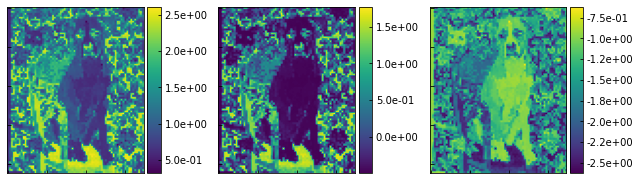

In [35]:
embedding_maps(encode, image)

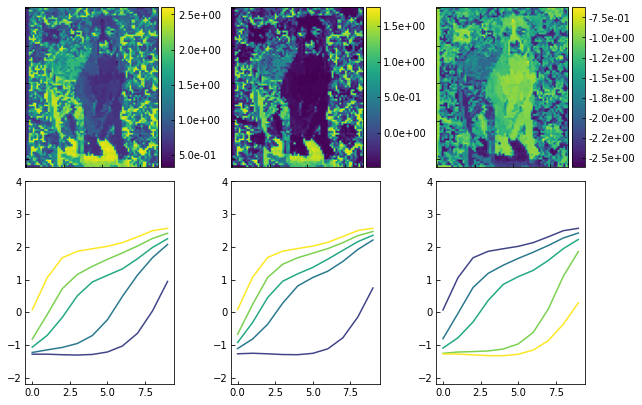

In [36]:
latent_generator(decoder, encode, image, 5, 10, device=device)

- This once again is very hard to interpret and the spectra do not really contain the necessary details


## Disentanglement

### Regularization

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/L1_reg.png?raw=true)


### Builds the Model


In [37]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x

In [38]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [39]:
model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Dataloader


In [40]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)

### Training


In [41]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3,
    mse=False,
    device=device,
)

100%|██████████| 19/19 [00:00<00:00, 159.57it/s]


Epoch 0, Train Loss: 2.1541
.............................


100%|██████████| 19/19 [00:00<00:00, 225.90it/s]


Epoch 1, Train Loss: 2.1475
.............................


100%|██████████| 19/19 [00:00<00:00, 246.34it/s]


Epoch 2, Train Loss: 2.1411
.............................


100%|██████████| 19/19 [00:00<00:00, 237.49it/s]


Epoch 3, Train Loss: 2.1347
.............................


100%|██████████| 19/19 [00:00<00:00, 256.63it/s]


Epoch 4, Train Loss: 2.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 5, Train Loss: 2.1221
.............................


100%|██████████| 19/19 [00:00<00:00, 228.53it/s]


Epoch 6, Train Loss: 2.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 231.60it/s]


Epoch 7, Train Loss: 2.1098
.............................


100%|██████████| 19/19 [00:00<00:00, 217.90it/s]


Epoch 8, Train Loss: 2.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 246.11it/s]


Epoch 9, Train Loss: 2.0977
.............................


100%|██████████| 19/19 [00:00<00:00, 233.18it/s]


Epoch 10, Train Loss: 2.0917
.............................


100%|██████████| 19/19 [00:00<00:00, 246.61it/s]


Epoch 11, Train Loss: 2.0857
.............................


100%|██████████| 19/19 [00:00<00:00, 197.96it/s]


Epoch 12, Train Loss: 2.0798
.............................


100%|██████████| 19/19 [00:00<00:00, 245.95it/s]


Epoch 13, Train Loss: 2.0739
.............................


100%|██████████| 19/19 [00:00<00:00, 246.26it/s]


Epoch 14, Train Loss: 2.0680
.............................


100%|██████████| 19/19 [00:00<00:00, 247.46it/s]


Epoch 15, Train Loss: 2.0621
.............................


100%|██████████| 19/19 [00:00<00:00, 246.60it/s]


Epoch 16, Train Loss: 2.0563
.............................


100%|██████████| 19/19 [00:00<00:00, 231.51it/s]


Epoch 17, Train Loss: 2.0504
.............................


100%|██████████| 19/19 [00:00<00:00, 218.36it/s]


Epoch 18, Train Loss: 2.0445
.............................


100%|██████████| 19/19 [00:00<00:00, 239.10it/s]


Epoch 19, Train Loss: 2.0386
.............................


100%|██████████| 19/19 [00:00<00:00, 243.69it/s]


Epoch 20, Train Loss: 2.0327
.............................


100%|██████████| 19/19 [00:00<00:00, 240.53it/s]


Epoch 21, Train Loss: 2.0268
.............................


100%|██████████| 19/19 [00:00<00:00, 226.10it/s]


Epoch 22, Train Loss: 2.0209
.............................


100%|██████████| 19/19 [00:00<00:00, 240.20it/s]


Epoch 23, Train Loss: 2.0149
.............................


100%|██████████| 19/19 [00:00<00:00, 237.17it/s]


Epoch 24, Train Loss: 2.0089
.............................


100%|██████████| 19/19 [00:00<00:00, 240.59it/s]


Epoch 25, Train Loss: 2.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 246.58it/s]


Epoch 26, Train Loss: 1.9967
.............................


100%|██████████| 19/19 [00:00<00:00, 234.43it/s]


Epoch 27, Train Loss: 1.9906
.............................


100%|██████████| 19/19 [00:00<00:00, 231.62it/s]


Epoch 28, Train Loss: 1.9843
.............................


100%|██████████| 19/19 [00:00<00:00, 226.03it/s]


Epoch 29, Train Loss: 1.9780
.............................


100%|██████████| 19/19 [00:00<00:00, 257.30it/s]


Epoch 30, Train Loss: 1.9716
.............................


100%|██████████| 19/19 [00:00<00:00, 226.03it/s]


Epoch 31, Train Loss: 1.9652
.............................


100%|██████████| 19/19 [00:00<00:00, 237.31it/s]


Epoch 32, Train Loss: 1.9586
.............................


100%|██████████| 19/19 [00:00<00:00, 231.40it/s]


Epoch 33, Train Loss: 1.9523
.............................


100%|██████████| 19/19 [00:00<00:00, 240.08it/s]


Epoch 34, Train Loss: 1.9463
.............................


100%|██████████| 19/19 [00:00<00:00, 228.76it/s]


Epoch 35, Train Loss: 1.9405
.............................


100%|██████████| 19/19 [00:00<00:00, 246.25it/s]


Epoch 36, Train Loss: 1.9348
.............................


100%|██████████| 19/19 [00:00<00:00, 215.94it/s]


Epoch 37, Train Loss: 1.9292
.............................


100%|██████████| 19/19 [00:00<00:00, 256.55it/s]


Epoch 38, Train Loss: 1.9237
.............................


100%|██████████| 19/19 [00:00<00:00, 231.47it/s]


Epoch 39, Train Loss: 1.9183
.............................


100%|██████████| 19/19 [00:00<00:00, 237.57it/s]


Epoch 40, Train Loss: 1.9129
.............................


100%|██████████| 19/19 [00:00<00:00, 223.67it/s]


Epoch 41, Train Loss: 1.9076
.............................


100%|██████████| 19/19 [00:00<00:00, 243.48it/s]


Epoch 42, Train Loss: 1.9023
.............................


100%|██████████| 19/19 [00:00<00:00, 234.24it/s]


Epoch 43, Train Loss: 1.8974
.............................


100%|██████████| 19/19 [00:00<00:00, 231.61it/s]


Epoch 44, Train Loss: 1.8928
.............................


100%|██████████| 19/19 [00:00<00:00, 249.87it/s]


Epoch 45, Train Loss: 1.8883
.............................


100%|██████████| 19/19 [00:00<00:00, 223.51it/s]


Epoch 46, Train Loss: 1.8838
.............................


100%|██████████| 19/19 [00:00<00:00, 248.78it/s]


Epoch 47, Train Loss: 1.8794
.............................


100%|██████████| 19/19 [00:00<00:00, 240.46it/s]


Epoch 48, Train Loss: 1.8750
.............................


100%|██████████| 19/19 [00:00<00:00, 243.40it/s]


Epoch 49, Train Loss: 1.8705
.............................


100%|██████████| 19/19 [00:00<00:00, 228.12it/s]


Epoch 50, Train Loss: 1.8661
.............................


100%|██████████| 19/19 [00:00<00:00, 250.02it/s]


Epoch 51, Train Loss: 1.8617
.............................


100%|██████████| 19/19 [00:00<00:00, 234.61it/s]


Epoch 52, Train Loss: 1.8572
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 53, Train Loss: 1.8527
.............................


100%|██████████| 19/19 [00:00<00:00, 226.19it/s]


Epoch 54, Train Loss: 1.8482
.............................


100%|██████████| 19/19 [00:00<00:00, 247.28it/s]


Epoch 55, Train Loss: 1.8436
.............................


100%|██████████| 19/19 [00:00<00:00, 237.52it/s]


Epoch 56, Train Loss: 1.8389
.............................


100%|██████████| 19/19 [00:00<00:00, 256.42it/s]


Epoch 57, Train Loss: 1.8342
.............................


100%|██████████| 19/19 [00:00<00:00, 236.31it/s]


Epoch 58, Train Loss: 1.8294
.............................


100%|██████████| 19/19 [00:00<00:00, 204.33it/s]


Epoch 59, Train Loss: 1.8245
.............................


100%|██████████| 19/19 [00:00<00:00, 228.90it/s]


Epoch 60, Train Loss: 1.8196
.............................


100%|██████████| 19/19 [00:00<00:00, 235.84it/s]


Epoch 61, Train Loss: 1.8146
.............................


100%|██████████| 19/19 [00:00<00:00, 243.63it/s]


Epoch 62, Train Loss: 1.8095
.............................


100%|██████████| 19/19 [00:00<00:00, 218.39it/s]


Epoch 63, Train Loss: 1.8042
.............................


100%|██████████| 19/19 [00:00<00:00, 236.82it/s]


Epoch 64, Train Loss: 1.7989
.............................


100%|██████████| 19/19 [00:00<00:00, 243.78it/s]


Epoch 65, Train Loss: 1.7935
.............................


100%|██████████| 19/19 [00:00<00:00, 239.81it/s]


Epoch 66, Train Loss: 1.7880
.............................


100%|██████████| 19/19 [00:00<00:00, 252.01it/s]


Epoch 67, Train Loss: 1.7824
.............................


100%|██████████| 19/19 [00:00<00:00, 242.15it/s]


Epoch 68, Train Loss: 1.7767
.............................


100%|██████████| 19/19 [00:00<00:00, 246.63it/s]


Epoch 69, Train Loss: 1.7709
.............................


100%|██████████| 19/19 [00:00<00:00, 223.55it/s]


Epoch 70, Train Loss: 1.7650
.............................


100%|██████████| 19/19 [00:00<00:00, 231.15it/s]


Epoch 71, Train Loss: 1.7589
.............................


100%|██████████| 19/19 [00:00<00:00, 247.12it/s]


Epoch 72, Train Loss: 1.7527
.............................


100%|██████████| 19/19 [00:00<00:00, 234.22it/s]


Epoch 73, Train Loss: 1.7464
.............................


100%|██████████| 19/19 [00:00<00:00, 234.42it/s]


Epoch 74, Train Loss: 1.7400
.............................


100%|██████████| 19/19 [00:00<00:00, 231.43it/s]


Epoch 75, Train Loss: 1.7334
.............................


100%|██████████| 19/19 [00:00<00:00, 243.68it/s]


Epoch 76, Train Loss: 1.7266
.............................


100%|██████████| 19/19 [00:00<00:00, 228.79it/s]


Epoch 77, Train Loss: 1.7198
.............................


100%|██████████| 19/19 [00:00<00:00, 228.90it/s]


Epoch 78, Train Loss: 1.7127
.............................


100%|██████████| 19/19 [00:00<00:00, 242.80it/s]


Epoch 79, Train Loss: 1.7056
.............................


100%|██████████| 19/19 [00:00<00:00, 246.76it/s]


Epoch 80, Train Loss: 1.6982
.............................


100%|██████████| 19/19 [00:00<00:00, 234.04it/s]


Epoch 81, Train Loss: 1.6908
.............................


100%|██████████| 19/19 [00:00<00:00, 246.74it/s]


Epoch 82, Train Loss: 1.6832
.............................


100%|██████████| 19/19 [00:00<00:00, 251.93it/s]


Epoch 83, Train Loss: 1.6757
.............................


100%|██████████| 19/19 [00:00<00:00, 240.50it/s]


Epoch 84, Train Loss: 1.6682
.............................


100%|██████████| 19/19 [00:00<00:00, 246.61it/s]


Epoch 85, Train Loss: 1.6607
.............................


100%|██████████| 19/19 [00:00<00:00, 217.89it/s]


Epoch 86, Train Loss: 1.6531
.............................


100%|██████████| 19/19 [00:00<00:00, 239.39it/s]


Epoch 87, Train Loss: 1.6453
.............................


100%|██████████| 19/19 [00:00<00:00, 220.72it/s]


Epoch 88, Train Loss: 1.6374
.............................


100%|██████████| 19/19 [00:00<00:00, 243.62it/s]


Epoch 89, Train Loss: 1.6294
.............................


100%|██████████| 19/19 [00:00<00:00, 239.91it/s]


Epoch 90, Train Loss: 1.6212
.............................


100%|██████████| 19/19 [00:00<00:00, 234.11it/s]


Epoch 91, Train Loss: 1.6129
.............................


100%|██████████| 19/19 [00:00<00:00, 228.64it/s]


Epoch 92, Train Loss: 1.6044
.............................


100%|██████████| 19/19 [00:00<00:00, 246.46it/s]


Epoch 93, Train Loss: 1.5959
.............................


100%|██████████| 19/19 [00:00<00:00, 240.47it/s]


Epoch 94, Train Loss: 1.5872
.............................


100%|██████████| 19/19 [00:00<00:00, 253.28it/s]


Epoch 95, Train Loss: 1.5783
.............................


100%|██████████| 19/19 [00:00<00:00, 235.61it/s]


Epoch 96, Train Loss: 1.5694
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 97, Train Loss: 1.5604
.............................


100%|██████████| 19/19 [00:00<00:00, 256.58it/s]


Epoch 98, Train Loss: 1.5513
.............................


100%|██████████| 19/19 [00:00<00:00, 232.78it/s]


Epoch 99, Train Loss: 1.5421
.............................


100%|██████████| 19/19 [00:00<00:00, 243.28it/s]


Epoch 100, Train Loss: 1.5328
.............................


100%|██████████| 19/19 [00:00<00:00, 234.52it/s]


Epoch 101, Train Loss: 1.5235
.............................


100%|██████████| 19/19 [00:00<00:00, 250.13it/s]


Epoch 102, Train Loss: 1.5141
.............................


100%|██████████| 19/19 [00:00<00:00, 246.57it/s]


Epoch 103, Train Loss: 1.5046
.............................


100%|██████████| 19/19 [00:00<00:00, 246.34it/s]


Epoch 104, Train Loss: 1.4951
.............................


100%|██████████| 19/19 [00:00<00:00, 237.52it/s]


Epoch 105, Train Loss: 1.4856
.............................


100%|██████████| 19/19 [00:00<00:00, 228.68it/s]


Epoch 106, Train Loss: 1.4760
.............................


100%|██████████| 19/19 [00:00<00:00, 240.35it/s]


Epoch 107, Train Loss: 1.4664
.............................


100%|██████████| 19/19 [00:00<00:00, 237.46it/s]


Epoch 108, Train Loss: 1.4568
.............................


100%|██████████| 19/19 [00:00<00:00, 235.89it/s]


Epoch 109, Train Loss: 1.4472
.............................


100%|██████████| 19/19 [00:00<00:00, 243.30it/s]


Epoch 110, Train Loss: 1.4376
.............................


100%|██████████| 19/19 [00:00<00:00, 240.32it/s]


Epoch 111, Train Loss: 1.4279
.............................


100%|██████████| 19/19 [00:00<00:00, 228.59it/s]


Epoch 112, Train Loss: 1.4183
.............................


100%|██████████| 19/19 [00:00<00:00, 195.83it/s]


Epoch 113, Train Loss: 1.4087
.............................


100%|██████████| 19/19 [00:00<00:00, 220.93it/s]


Epoch 114, Train Loss: 1.3991
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 115, Train Loss: 1.3895
.............................


100%|██████████| 19/19 [00:00<00:00, 243.37it/s]


Epoch 116, Train Loss: 1.3800
.............................


100%|██████████| 19/19 [00:00<00:00, 234.50it/s]


Epoch 117, Train Loss: 1.3705
.............................


100%|██████████| 19/19 [00:00<00:00, 228.85it/s]


Epoch 118, Train Loss: 1.3610
.............................


100%|██████████| 19/19 [00:00<00:00, 237.45it/s]


Epoch 119, Train Loss: 1.3517
.............................


100%|██████████| 19/19 [00:00<00:00, 237.41it/s]


Epoch 120, Train Loss: 1.3423
.............................


100%|██████████| 19/19 [00:00<00:00, 240.63it/s]


Epoch 121, Train Loss: 1.3331
.............................


100%|██████████| 19/19 [00:00<00:00, 244.79it/s]


Epoch 122, Train Loss: 1.3239
.............................


100%|██████████| 19/19 [00:00<00:00, 249.58it/s]


Epoch 123, Train Loss: 1.3148
.............................


100%|██████████| 19/19 [00:00<00:00, 238.94it/s]


Epoch 124, Train Loss: 1.3058
.............................


100%|██████████| 19/19 [00:00<00:00, 240.47it/s]


Epoch 125, Train Loss: 1.2969
.............................


100%|██████████| 19/19 [00:00<00:00, 226.18it/s]


Epoch 126, Train Loss: 1.2881
.............................


100%|██████████| 19/19 [00:00<00:00, 233.91it/s]


Epoch 127, Train Loss: 1.2794
.............................


100%|██████████| 19/19 [00:00<00:00, 234.34it/s]


Epoch 128, Train Loss: 1.2708
.............................


100%|██████████| 19/19 [00:00<00:00, 210.22it/s]


Epoch 129, Train Loss: 1.2623
.............................


100%|██████████| 19/19 [00:00<00:00, 226.38it/s]


Epoch 130, Train Loss: 1.2539
.............................


100%|██████████| 19/19 [00:00<00:00, 231.69it/s]


Epoch 131, Train Loss: 1.2457
.............................


100%|██████████| 19/19 [00:00<00:00, 235.23it/s]


Epoch 132, Train Loss: 1.2376
.............................


100%|██████████| 19/19 [00:00<00:00, 224.12it/s]


Epoch 133, Train Loss: 1.2297
.............................


100%|██████████| 19/19 [00:00<00:00, 249.75it/s]


Epoch 134, Train Loss: 1.2218
.............................


100%|██████████| 19/19 [00:00<00:00, 249.18it/s]


Epoch 135, Train Loss: 1.2141
.............................


100%|██████████| 19/19 [00:00<00:00, 248.29it/s]


Epoch 136, Train Loss: 1.2066
.............................


100%|██████████| 19/19 [00:00<00:00, 255.48it/s]


Epoch 137, Train Loss: 1.1992
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 138, Train Loss: 1.1919
.............................


100%|██████████| 19/19 [00:00<00:00, 248.62it/s]


Epoch 139, Train Loss: 1.1848
.............................


100%|██████████| 19/19 [00:00<00:00, 263.72it/s]


Epoch 140, Train Loss: 1.1778
.............................


100%|██████████| 19/19 [00:00<00:00, 246.55it/s]


Epoch 141, Train Loss: 1.1710
.............................


100%|██████████| 19/19 [00:00<00:00, 240.58it/s]


Epoch 142, Train Loss: 1.1642
.............................


100%|██████████| 19/19 [00:00<00:00, 253.21it/s]


Epoch 143, Train Loss: 1.1576
.............................


100%|██████████| 19/19 [00:00<00:00, 250.21it/s]


Epoch 144, Train Loss: 1.1511
.............................


100%|██████████| 19/19 [00:00<00:00, 249.81it/s]


Epoch 145, Train Loss: 1.1447
.............................


100%|██████████| 19/19 [00:00<00:00, 243.45it/s]


Epoch 146, Train Loss: 1.1384
.............................


100%|██████████| 19/19 [00:00<00:00, 215.93it/s]


Epoch 147, Train Loss: 1.1322
.............................


100%|██████████| 19/19 [00:00<00:00, 213.58it/s]


Epoch 148, Train Loss: 1.1260
.............................


100%|██████████| 19/19 [00:00<00:00, 205.33it/s]


Epoch 149, Train Loss: 1.1198
.............................


100%|██████████| 19/19 [00:00<00:00, 233.99it/s]


Epoch 150, Train Loss: 1.1136
.............................


100%|██████████| 19/19 [00:00<00:00, 228.91it/s]


Epoch 151, Train Loss: 1.1074
.............................


100%|██████████| 19/19 [00:00<00:00, 237.71it/s]


Epoch 152, Train Loss: 1.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 243.47it/s]


Epoch 153, Train Loss: 1.0948
.............................


100%|██████████| 19/19 [00:00<00:00, 243.60it/s]


Epoch 154, Train Loss: 1.0884
.............................


100%|██████████| 19/19 [00:00<00:00, 237.29it/s]


Epoch 155, Train Loss: 1.0820
.............................


100%|██████████| 19/19 [00:00<00:00, 237.44it/s]


Epoch 156, Train Loss: 1.0758
.............................


100%|██████████| 19/19 [00:00<00:00, 239.35it/s]


Epoch 157, Train Loss: 1.0696
.............................


100%|██████████| 19/19 [00:00<00:00, 234.89it/s]


Epoch 158, Train Loss: 1.0634
.............................


100%|██████████| 19/19 [00:00<00:00, 242.78it/s]


Epoch 159, Train Loss: 1.0571
.............................


100%|██████████| 19/19 [00:00<00:00, 234.55it/s]


Epoch 160, Train Loss: 1.0507
.............................


100%|██████████| 19/19 [00:00<00:00, 225.96it/s]


Epoch 161, Train Loss: 1.0442
.............................


100%|██████████| 19/19 [00:00<00:00, 226.19it/s]


Epoch 162, Train Loss: 1.0376
.............................


100%|██████████| 19/19 [00:00<00:00, 233.92it/s]


Epoch 163, Train Loss: 1.0308
.............................


100%|██████████| 19/19 [00:00<00:00, 237.03it/s]


Epoch 164, Train Loss: 1.0239
.............................


100%|██████████| 19/19 [00:00<00:00, 235.88it/s]


Epoch 165, Train Loss: 1.0167
.............................


100%|██████████| 19/19 [00:00<00:00, 240.34it/s]


Epoch 166, Train Loss: 1.0093
.............................


100%|██████████| 19/19 [00:00<00:00, 237.44it/s]


Epoch 167, Train Loss: 1.0016
.............................


100%|██████████| 19/19 [00:00<00:00, 243.48it/s]


Epoch 168, Train Loss: 0.9936
.............................


100%|██████████| 19/19 [00:00<00:00, 218.48it/s]


Epoch 169, Train Loss: 0.9852
.............................


100%|██████████| 19/19 [00:00<00:00, 246.52it/s]


Epoch 170, Train Loss: 0.9765
.............................


100%|██████████| 19/19 [00:00<00:00, 249.97it/s]


Epoch 171, Train Loss: 0.9674
.............................


100%|██████████| 19/19 [00:00<00:00, 231.72it/s]


Epoch 172, Train Loss: 0.9578
.............................


100%|██████████| 19/19 [00:00<00:00, 243.58it/s]


Epoch 173, Train Loss: 0.9477
.............................


100%|██████████| 19/19 [00:00<00:00, 246.65it/s]


Epoch 174, Train Loss: 0.9371
.............................


100%|██████████| 19/19 [00:00<00:00, 234.60it/s]


Epoch 175, Train Loss: 0.9259
.............................


100%|██████████| 19/19 [00:00<00:00, 246.71it/s]


Epoch 176, Train Loss: 0.9141
.............................


100%|██████████| 19/19 [00:00<00:00, 240.50it/s]


Epoch 177, Train Loss: 0.9016
.............................


100%|██████████| 19/19 [00:00<00:00, 253.32it/s]


Epoch 178, Train Loss: 0.8886
.............................


100%|██████████| 19/19 [00:00<00:00, 249.83it/s]


Epoch 179, Train Loss: 0.8748
.............................


100%|██████████| 19/19 [00:00<00:00, 246.97it/s]


Epoch 180, Train Loss: 0.8605
.............................


100%|██████████| 19/19 [00:00<00:00, 240.62it/s]


Epoch 181, Train Loss: 0.8456
.............................


100%|██████████| 19/19 [00:00<00:00, 231.60it/s]


Epoch 182, Train Loss: 0.8301
.............................


100%|██████████| 19/19 [00:00<00:00, 256.75it/s]


Epoch 183, Train Loss: 0.8141
.............................


100%|██████████| 19/19 [00:00<00:00, 215.90it/s]


Epoch 184, Train Loss: 0.7979
.............................


100%|██████████| 19/19 [00:00<00:00, 236.42it/s]


Epoch 185, Train Loss: 0.7813
.............................


100%|██████████| 19/19 [00:00<00:00, 267.74it/s]


Epoch 186, Train Loss: 0.7647
.............................


100%|██████████| 19/19 [00:00<00:00, 231.21it/s]


Epoch 187, Train Loss: 0.7481
.............................


100%|██████████| 19/19 [00:00<00:00, 240.01it/s]


Epoch 188, Train Loss: 0.7315
.............................


100%|██████████| 19/19 [00:00<00:00, 179.32it/s]


Epoch 189, Train Loss: 0.7152
.............................


100%|██████████| 19/19 [00:00<00:00, 231.33it/s]


Epoch 190, Train Loss: 0.6992
.............................


100%|██████████| 19/19 [00:00<00:00, 237.37it/s]


Epoch 191, Train Loss: 0.6836
.............................


100%|██████████| 19/19 [00:00<00:00, 234.49it/s]


Epoch 192, Train Loss: 0.6685
.............................


100%|██████████| 19/19 [00:00<00:00, 246.56it/s]


Epoch 193, Train Loss: 0.6539
.............................


100%|██████████| 19/19 [00:00<00:00, 231.60it/s]


Epoch 194, Train Loss: 0.6398
.............................


100%|██████████| 19/19 [00:00<00:00, 237.61it/s]


Epoch 195, Train Loss: 0.6262
.............................


100%|██████████| 19/19 [00:00<00:00, 231.62it/s]


Epoch 196, Train Loss: 0.6132
.............................


100%|██████████| 19/19 [00:00<00:00, 231.56it/s]


Epoch 197, Train Loss: 0.6007
.............................


100%|██████████| 19/19 [00:00<00:00, 240.48it/s]


Epoch 198, Train Loss: 0.5889
.............................


100%|██████████| 19/19 [00:00<00:00, 237.49it/s]


Epoch 199, Train Loss: 0.5778
.............................


100%|██████████| 19/19 [00:00<00:00, 250.15it/s]


Epoch 200, Train Loss: 0.5673
.............................


100%|██████████| 19/19 [00:00<00:00, 240.42it/s]


Epoch 201, Train Loss: 0.5575
.............................


100%|██████████| 19/19 [00:00<00:00, 223.46it/s]


Epoch 202, Train Loss: 0.5483
.............................


100%|██████████| 19/19 [00:00<00:00, 234.89it/s]


Epoch 203, Train Loss: 0.5396
.............................


100%|██████████| 19/19 [00:00<00:00, 253.32it/s]


Epoch 204, Train Loss: 0.5314
.............................


100%|██████████| 19/19 [00:00<00:00, 237.13it/s]


Epoch 205, Train Loss: 0.5237
.............................


100%|██████████| 19/19 [00:00<00:00, 226.03it/s]


Epoch 206, Train Loss: 0.5164
.............................


100%|██████████| 19/19 [00:00<00:00, 246.67it/s]


Epoch 207, Train Loss: 0.5095
.............................


100%|██████████| 19/19 [00:00<00:00, 249.84it/s]


Epoch 208, Train Loss: 0.5029
.............................


100%|██████████| 19/19 [00:00<00:00, 240.54it/s]


Epoch 209, Train Loss: 0.4967
.............................


100%|██████████| 19/19 [00:00<00:00, 243.57it/s]


Epoch 210, Train Loss: 0.4907
.............................


100%|██████████| 19/19 [00:00<00:00, 213.60it/s]


Epoch 211, Train Loss: 0.4850
.............................


100%|██████████| 19/19 [00:00<00:00, 247.11it/s]


Epoch 212, Train Loss: 0.4796
.............................


100%|██████████| 19/19 [00:00<00:00, 237.26it/s]


Epoch 213, Train Loss: 0.4745
.............................


100%|██████████| 19/19 [00:00<00:00, 246.74it/s]


Epoch 214, Train Loss: 0.4696
.............................


100%|██████████| 19/19 [00:00<00:00, 237.06it/s]


Epoch 215, Train Loss: 0.4649
.............................


100%|██████████| 19/19 [00:00<00:00, 237.45it/s]


Epoch 216, Train Loss: 0.4604
.............................


100%|██████████| 19/19 [00:00<00:00, 243.34it/s]


Epoch 217, Train Loss: 0.4560
.............................


100%|██████████| 19/19 [00:00<00:00, 204.11it/s]


Epoch 218, Train Loss: 0.4519
.............................


100%|██████████| 19/19 [00:00<00:00, 213.58it/s]


Epoch 219, Train Loss: 0.4479
.............................


100%|██████████| 19/19 [00:00<00:00, 263.37it/s]


Epoch 220, Train Loss: 0.4441
.............................


100%|██████████| 19/19 [00:00<00:00, 234.22it/s]


Epoch 221, Train Loss: 0.4404
.............................


100%|██████████| 19/19 [00:00<00:00, 222.11it/s]


Epoch 222, Train Loss: 0.4369
.............................


100%|██████████| 19/19 [00:00<00:00, 220.77it/s]


Epoch 223, Train Loss: 0.4334
.............................


100%|██████████| 19/19 [00:00<00:00, 223.32it/s]


Epoch 224, Train Loss: 0.4302
.............................


100%|██████████| 19/19 [00:00<00:00, 246.11it/s]


Epoch 225, Train Loss: 0.4270
.............................


100%|██████████| 19/19 [00:00<00:00, 234.62it/s]


Epoch 226, Train Loss: 0.4239
.............................


100%|██████████| 19/19 [00:00<00:00, 256.77it/s]


Epoch 227, Train Loss: 0.4210
.............................


100%|██████████| 19/19 [00:00<00:00, 237.36it/s]


Epoch 228, Train Loss: 0.4181
.............................


100%|██████████| 19/19 [00:00<00:00, 240.30it/s]


Epoch 229, Train Loss: 0.4153
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 230, Train Loss: 0.4126
.............................


100%|██████████| 19/19 [00:00<00:00, 234.09it/s]


Epoch 231, Train Loss: 0.4100
.............................


100%|██████████| 19/19 [00:00<00:00, 243.62it/s]


Epoch 232, Train Loss: 0.4075
.............................


100%|██████████| 19/19 [00:00<00:00, 234.40it/s]


Epoch 233, Train Loss: 0.4050
.............................


100%|██████████| 19/19 [00:00<00:00, 240.48it/s]


Epoch 234, Train Loss: 0.4026
.............................


100%|██████████| 19/19 [00:00<00:00, 223.48it/s]


Epoch 235, Train Loss: 0.4003
.............................


100%|██████████| 19/19 [00:00<00:00, 228.90it/s]


Epoch 236, Train Loss: 0.3980
.............................


100%|██████████| 19/19 [00:00<00:00, 246.53it/s]


Epoch 237, Train Loss: 0.3957
.............................


100%|██████████| 19/19 [00:00<00:00, 228.57it/s]


Epoch 238, Train Loss: 0.3936
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 239, Train Loss: 0.3914
.............................


100%|██████████| 19/19 [00:00<00:00, 231.64it/s]


Epoch 240, Train Loss: 0.3893
.............................


100%|██████████| 19/19 [00:00<00:00, 237.48it/s]


Epoch 241, Train Loss: 0.3873
.............................


100%|██████████| 19/19 [00:00<00:00, 237.42it/s]


Epoch 242, Train Loss: 0.3853
.............................


100%|██████████| 19/19 [00:00<00:00, 246.69it/s]


Epoch 243, Train Loss: 0.3834
.............................


100%|██████████| 19/19 [00:00<00:00, 237.60it/s]


Epoch 244, Train Loss: 0.3814
.............................


100%|██████████| 19/19 [00:00<00:00, 249.84it/s]


Epoch 245, Train Loss: 0.3796
.............................


100%|██████████| 19/19 [00:00<00:00, 253.37it/s]


Epoch 246, Train Loss: 0.3777
.............................


100%|██████████| 19/19 [00:00<00:00, 240.33it/s]


Epoch 247, Train Loss: 0.3759
.............................


100%|██████████| 19/19 [00:00<00:00, 173.97it/s]


Epoch 248, Train Loss: 0.3741
.............................


100%|██████████| 19/19 [00:00<00:00, 243.69it/s]


Epoch 249, Train Loss: 0.3724
.............................


100%|██████████| 19/19 [00:00<00:00, 243.44it/s]


Epoch 250, Train Loss: 0.3706
.............................


100%|██████████| 19/19 [00:00<00:00, 231.71it/s]


Epoch 251, Train Loss: 0.3689
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 252, Train Loss: 0.3673
.............................


100%|██████████| 19/19 [00:00<00:00, 237.61it/s]


Epoch 253, Train Loss: 0.3656
.............................


100%|██████████| 19/19 [00:00<00:00, 223.46it/s]


Epoch 254, Train Loss: 0.3640
.............................


100%|██████████| 19/19 [00:00<00:00, 226.16it/s]


Epoch 255, Train Loss: 0.3624
.............................


100%|██████████| 19/19 [00:00<00:00, 240.25it/s]


Epoch 256, Train Loss: 0.3608
.............................


100%|██████████| 19/19 [00:00<00:00, 240.78it/s]


Epoch 257, Train Loss: 0.3593
.............................


100%|██████████| 19/19 [00:00<00:00, 234.57it/s]


Epoch 258, Train Loss: 0.3577
.............................


100%|██████████| 19/19 [00:00<00:00, 223.53it/s]


Epoch 259, Train Loss: 0.3562
.............................


100%|██████████| 19/19 [00:00<00:00, 243.59it/s]


Epoch 260, Train Loss: 0.3548
.............................


100%|██████████| 19/19 [00:00<00:00, 237.39it/s]


Epoch 261, Train Loss: 0.3533
.............................


100%|██████████| 19/19 [00:00<00:00, 240.64it/s]


Epoch 262, Train Loss: 0.3519
.............................


100%|██████████| 19/19 [00:00<00:00, 249.80it/s]


Epoch 263, Train Loss: 0.3505
.............................


100%|██████████| 19/19 [00:00<00:00, 233.01it/s]


Epoch 264, Train Loss: 0.3491
.............................


100%|██████████| 19/19 [00:00<00:00, 253.35it/s]


Epoch 265, Train Loss: 0.3477
.............................


100%|██████████| 19/19 [00:00<00:00, 237.45it/s]


Epoch 266, Train Loss: 0.3464
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 267, Train Loss: 0.3451
.............................


100%|██████████| 19/19 [00:00<00:00, 237.53it/s]


Epoch 268, Train Loss: 0.3438
.............................


100%|██████████| 19/19 [00:00<00:00, 234.54it/s]


Epoch 269, Train Loss: 0.3426
.............................


100%|██████████| 19/19 [00:00<00:00, 240.48it/s]


Epoch 270, Train Loss: 0.3413
.............................


100%|██████████| 19/19 [00:00<00:00, 226.03it/s]


Epoch 271, Train Loss: 0.3401
.............................


100%|██████████| 19/19 [00:00<00:00, 246.90it/s]


Epoch 272, Train Loss: 0.3390
.............................


100%|██████████| 19/19 [00:00<00:00, 243.40it/s]


Epoch 273, Train Loss: 0.3378
.............................


100%|██████████| 19/19 [00:00<00:00, 250.08it/s]


Epoch 274, Train Loss: 0.3367
.............................


100%|██████████| 19/19 [00:00<00:00, 243.59it/s]


Epoch 275, Train Loss: 0.3356
.............................


100%|██████████| 19/19 [00:00<00:00, 243.59it/s]


Epoch 276, Train Loss: 0.3345
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 277, Train Loss: 0.3335
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 278, Train Loss: 0.3324
.............................


100%|██████████| 19/19 [00:00<00:00, 231.71it/s]


Epoch 279, Train Loss: 0.3314
.............................


100%|██████████| 19/19 [00:00<00:00, 220.93it/s]


Epoch 280, Train Loss: 0.3305
.............................


100%|██████████| 19/19 [00:00<00:00, 240.16it/s]


Epoch 281, Train Loss: 0.3295
.............................


100%|██████████| 19/19 [00:00<00:00, 250.00it/s]


Epoch 282, Train Loss: 0.3286
.............................


100%|██████████| 19/19 [00:00<00:00, 246.76it/s]


Epoch 283, Train Loss: 0.3277
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 284, Train Loss: 0.3268
.............................


100%|██████████| 19/19 [00:00<00:00, 243.40it/s]


Epoch 285, Train Loss: 0.3259
.............................


100%|██████████| 19/19 [00:00<00:00, 231.21it/s]


Epoch 286, Train Loss: 0.3251
.............................


100%|██████████| 19/19 [00:00<00:00, 246.80it/s]


Epoch 287, Train Loss: 0.3243
.............................


100%|██████████| 19/19 [00:00<00:00, 225.91it/s]


Epoch 288, Train Loss: 0.3235
.............................


100%|██████████| 19/19 [00:00<00:00, 228.93it/s]


Epoch 289, Train Loss: 0.3227
.............................


100%|██████████| 19/19 [00:00<00:00, 256.69it/s]


Epoch 290, Train Loss: 0.3220
.............................


100%|██████████| 19/19 [00:00<00:00, 226.18it/s]


Epoch 291, Train Loss: 0.3212
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 292, Train Loss: 0.3205
.............................


100%|██████████| 19/19 [00:00<00:00, 229.04it/s]


Epoch 293, Train Loss: 0.3198
.............................


100%|██████████| 19/19 [00:00<00:00, 256.64it/s]


Epoch 294, Train Loss: 0.3191
.............................


100%|██████████| 19/19 [00:00<00:00, 231.76it/s]


Epoch 295, Train Loss: 0.3184
.............................


100%|██████████| 19/19 [00:00<00:00, 231.71it/s]


Epoch 296, Train Loss: 0.3178
.............................


100%|██████████| 19/19 [00:00<00:00, 231.63it/s]


Epoch 297, Train Loss: 0.3171
.............................


100%|██████████| 19/19 [00:00<00:00, 248.32it/s]


Epoch 298, Train Loss: 0.3165
.............................


100%|██████████| 19/19 [00:00<00:00, 237.34it/s]


Epoch 299, Train Loss: 0.3159
.............................


100%|██████████| 19/19 [00:00<00:00, 231.81it/s]


Epoch 300, Train Loss: 0.3153
.............................


100%|██████████| 19/19 [00:00<00:00, 249.81it/s]


Epoch 301, Train Loss: 0.3147
.............................


100%|██████████| 19/19 [00:00<00:00, 240.47it/s]


Epoch 302, Train Loss: 0.3142
.............................


100%|██████████| 19/19 [00:00<00:00, 243.44it/s]


Epoch 303, Train Loss: 0.3136
.............................


100%|██████████| 19/19 [00:00<00:00, 237.49it/s]


Epoch 304, Train Loss: 0.3131
.............................


100%|██████████| 19/19 [00:00<00:00, 246.69it/s]


Epoch 305, Train Loss: 0.3125
.............................


100%|██████████| 19/19 [00:00<00:00, 231.67it/s]


Epoch 306, Train Loss: 0.3120
.............................


100%|██████████| 19/19 [00:00<00:00, 240.50it/s]


Epoch 307, Train Loss: 0.3115
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 308, Train Loss: 0.3110
.............................


100%|██████████| 19/19 [00:00<00:00, 264.07it/s]


Epoch 309, Train Loss: 0.3105
.............................


100%|██████████| 19/19 [00:00<00:00, 240.41it/s]


Epoch 310, Train Loss: 0.3100
.............................


100%|██████████| 19/19 [00:00<00:00, 240.87it/s]


Epoch 311, Train Loss: 0.3095
.............................


100%|██████████| 19/19 [00:00<00:00, 223.61it/s]


Epoch 312, Train Loss: 0.3090
.............................


100%|██████████| 19/19 [00:00<00:00, 240.67it/s]


Epoch 313, Train Loss: 0.3085
.............................


100%|██████████| 19/19 [00:00<00:00, 227.01it/s]


Epoch 314, Train Loss: 0.3080
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 315, Train Loss: 0.3076
.............................


100%|██████████| 19/19 [00:00<00:00, 250.00it/s]


Epoch 316, Train Loss: 0.3071
.............................


100%|██████████| 19/19 [00:00<00:00, 242.94it/s]


Epoch 317, Train Loss: 0.3067
.............................


100%|██████████| 19/19 [00:00<00:00, 232.03it/s]


Epoch 318, Train Loss: 0.3062
.............................


100%|██████████| 19/19 [00:00<00:00, 240.33it/s]


Epoch 319, Train Loss: 0.3058
.............................


100%|██████████| 19/19 [00:00<00:00, 223.28it/s]


Epoch 320, Train Loss: 0.3053
.............................


100%|██████████| 19/19 [00:00<00:00, 231.83it/s]


Epoch 321, Train Loss: 0.3049
.............................


100%|██████████| 19/19 [00:00<00:00, 231.65it/s]


Epoch 322, Train Loss: 0.3045
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 323, Train Loss: 0.3040
.............................


100%|██████████| 19/19 [00:00<00:00, 243.60it/s]


Epoch 324, Train Loss: 0.3036
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 325, Train Loss: 0.3032
.............................


100%|██████████| 19/19 [00:00<00:00, 246.75it/s]


Epoch 326, Train Loss: 0.3027
.............................


100%|██████████| 19/19 [00:00<00:00, 220.93it/s]


Epoch 327, Train Loss: 0.3023
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 328, Train Loss: 0.3019
.............................


100%|██████████| 19/19 [00:00<00:00, 237.51it/s]


Epoch 329, Train Loss: 0.3015
.............................


100%|██████████| 19/19 [00:00<00:00, 256.76it/s]


Epoch 330, Train Loss: 0.3011
.............................


100%|██████████| 19/19 [00:00<00:00, 234.04it/s]


Epoch 331, Train Loss: 0.3006
.............................


100%|██████████| 19/19 [00:00<00:00, 228.80it/s]


Epoch 332, Train Loss: 0.3002
.............................


100%|██████████| 19/19 [00:00<00:00, 243.62it/s]


Epoch 333, Train Loss: 0.2998
.............................


100%|██████████| 19/19 [00:00<00:00, 237.13it/s]


Epoch 334, Train Loss: 0.2994
.............................


100%|██████████| 19/19 [00:00<00:00, 243.40it/s]


Epoch 335, Train Loss: 0.2990
.............................


100%|██████████| 19/19 [00:00<00:00, 243.60it/s]


Epoch 336, Train Loss: 0.2986
.............................


100%|██████████| 19/19 [00:00<00:00, 243.59it/s]


Epoch 337, Train Loss: 0.2981
.............................


100%|██████████| 19/19 [00:00<00:00, 250.00it/s]


Epoch 338, Train Loss: 0.2977
.............................


100%|██████████| 19/19 [00:00<00:00, 240.36it/s]


Epoch 339, Train Loss: 0.2973
.............................


100%|██████████| 19/19 [00:00<00:00, 237.83it/s]


Epoch 340, Train Loss: 0.2969
.............................


100%|██████████| 19/19 [00:00<00:00, 231.59it/s]


Epoch 341, Train Loss: 0.2965
.............................


100%|██████████| 19/19 [00:00<00:00, 251.77it/s]


Epoch 342, Train Loss: 0.2961
.............................


100%|██████████| 19/19 [00:00<00:00, 237.50it/s]


Epoch 343, Train Loss: 0.2957
.............................


100%|██████████| 19/19 [00:00<00:00, 260.31it/s]


Epoch 344, Train Loss: 0.2953
.............................


100%|██████████| 19/19 [00:00<00:00, 221.03it/s]


Epoch 345, Train Loss: 0.2949
.............................


100%|██████████| 19/19 [00:00<00:00, 220.92it/s]


Epoch 346, Train Loss: 0.2945
.............................


100%|██████████| 19/19 [00:00<00:00, 246.62it/s]


Epoch 347, Train Loss: 0.2940
.............................


100%|██████████| 19/19 [00:00<00:00, 232.77it/s]


Epoch 348, Train Loss: 0.2936
.............................


100%|██████████| 19/19 [00:00<00:00, 246.65it/s]


Epoch 349, Train Loss: 0.2932
.............................


100%|██████████| 19/19 [00:00<00:00, 231.79it/s]


Epoch 350, Train Loss: 0.2928
.............................


100%|██████████| 19/19 [00:00<00:00, 240.47it/s]


Epoch 351, Train Loss: 0.2924
.............................


100%|██████████| 19/19 [00:00<00:00, 234.45it/s]


Epoch 352, Train Loss: 0.2920
.............................


100%|██████████| 19/19 [00:00<00:00, 246.77it/s]


Epoch 353, Train Loss: 0.2916
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 354, Train Loss: 0.2912
.............................


100%|██████████| 19/19 [00:00<00:00, 231.36it/s]


Epoch 355, Train Loss: 0.2908
.............................


100%|██████████| 19/19 [00:00<00:00, 243.48it/s]


Epoch 356, Train Loss: 0.2904
.............................


100%|██████████| 19/19 [00:00<00:00, 220.94it/s]


Epoch 357, Train Loss: 0.2900
.............................


100%|██████████| 19/19 [00:00<00:00, 240.52it/s]


Epoch 358, Train Loss: 0.2896
.............................


100%|██████████| 19/19 [00:00<00:00, 249.89it/s]


Epoch 359, Train Loss: 0.2892
.............................


100%|██████████| 19/19 [00:00<00:00, 228.54it/s]


Epoch 360, Train Loss: 0.2888
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 361, Train Loss: 0.2884
.............................


100%|██████████| 19/19 [00:00<00:00, 237.32it/s]


Epoch 362, Train Loss: 0.2880
.............................


100%|██████████| 19/19 [00:00<00:00, 260.29it/s]


Epoch 363, Train Loss: 0.2876
.............................


100%|██████████| 19/19 [00:00<00:00, 242.84it/s]


Epoch 364, Train Loss: 0.2872
.............................


100%|██████████| 19/19 [00:00<00:00, 243.36it/s]


Epoch 365, Train Loss: 0.2868
.............................


100%|██████████| 19/19 [00:00<00:00, 243.45it/s]


Epoch 366, Train Loss: 0.2865
.............................


100%|██████████| 19/19 [00:00<00:00, 250.12it/s]


Epoch 367, Train Loss: 0.2861
.............................


100%|██████████| 19/19 [00:00<00:00, 243.53it/s]


Epoch 368, Train Loss: 0.2857
.............................


100%|██████████| 19/19 [00:00<00:00, 222.42it/s]


Epoch 369, Train Loss: 0.2853
.............................


100%|██████████| 19/19 [00:00<00:00, 250.04it/s]


Epoch 370, Train Loss: 0.2849
.............................


100%|██████████| 19/19 [00:00<00:00, 246.75it/s]


Epoch 371, Train Loss: 0.2845
.............................


100%|██████████| 19/19 [00:00<00:00, 234.93it/s]


Epoch 372, Train Loss: 0.2841
.............................


100%|██████████| 19/19 [00:00<00:00, 237.48it/s]


Epoch 373, Train Loss: 0.2837
.............................


100%|██████████| 19/19 [00:00<00:00, 243.59it/s]


Epoch 374, Train Loss: 0.2833
.............................


100%|██████████| 19/19 [00:00<00:00, 263.73it/s]


Epoch 375, Train Loss: 0.2829
.............................


100%|██████████| 19/19 [00:00<00:00, 172.74it/s]


Epoch 376, Train Loss: 0.2825
.............................


100%|██████████| 19/19 [00:00<00:00, 208.92it/s]


Epoch 377, Train Loss: 0.2821
.............................


100%|██████████| 19/19 [00:00<00:00, 234.41it/s]


Epoch 378, Train Loss: 0.2818
.............................


100%|██████████| 19/19 [00:00<00:00, 256.54it/s]


Epoch 379, Train Loss: 0.2814
.............................


100%|██████████| 19/19 [00:00<00:00, 260.13it/s]


Epoch 380, Train Loss: 0.2810
.............................


100%|██████████| 19/19 [00:00<00:00, 226.34it/s]


Epoch 381, Train Loss: 0.2806
.............................


100%|██████████| 19/19 [00:00<00:00, 240.08it/s]


Epoch 382, Train Loss: 0.2802
.............................


100%|██████████| 19/19 [00:00<00:00, 240.48it/s]


Epoch 383, Train Loss: 0.2798
.............................


100%|██████████| 19/19 [00:00<00:00, 260.30it/s]


Epoch 384, Train Loss: 0.2794
.............................


100%|██████████| 19/19 [00:00<00:00, 225.94it/s]


Epoch 385, Train Loss: 0.2790
.............................


100%|██████████| 19/19 [00:00<00:00, 263.72it/s]


Epoch 386, Train Loss: 0.2787
.............................


100%|██████████| 19/19 [00:00<00:00, 237.12it/s]


Epoch 387, Train Loss: 0.2783
.............................


100%|██████████| 19/19 [00:00<00:00, 240.59it/s]


Epoch 388, Train Loss: 0.2779
.............................


100%|██████████| 19/19 [00:00<00:00, 243.44it/s]


Epoch 389, Train Loss: 0.2775
.............................


100%|██████████| 19/19 [00:00<00:00, 237.12it/s]


Epoch 390, Train Loss: 0.2771
.............................


100%|██████████| 19/19 [00:00<00:00, 246.80it/s]


Epoch 391, Train Loss: 0.2767
.............................


100%|██████████| 19/19 [00:00<00:00, 240.41it/s]


Epoch 392, Train Loss: 0.2763
.............................


100%|██████████| 19/19 [00:00<00:00, 243.63it/s]


Epoch 393, Train Loss: 0.2759
.............................


100%|██████████| 19/19 [00:00<00:00, 237.37it/s]


Epoch 394, Train Loss: 0.2756
.............................


100%|██████████| 19/19 [00:00<00:00, 237.40it/s]


Epoch 395, Train Loss: 0.2752
.............................


100%|██████████| 19/19 [00:00<00:00, 256.77it/s]


Epoch 396, Train Loss: 0.2748
.............................


100%|██████████| 19/19 [00:00<00:00, 219.21it/s]


Epoch 397, Train Loss: 0.2744
.............................


100%|██████████| 19/19 [00:00<00:00, 253.37it/s]


Epoch 398, Train Loss: 0.2740
.............................


100%|██████████| 19/19 [00:00<00:00, 243.54it/s]


Epoch 399, Train Loss: 0.2736
.............................


100%|██████████| 19/19 [00:00<00:00, 249.81it/s]


Epoch 400, Train Loss: 0.2733
.............................


100%|██████████| 19/19 [00:00<00:00, 220.77it/s]


Epoch 401, Train Loss: 0.2729
.............................


100%|██████████| 19/19 [00:00<00:00, 253.58it/s]


Epoch 402, Train Loss: 0.2725
.............................


100%|██████████| 19/19 [00:00<00:00, 237.35it/s]


Epoch 403, Train Loss: 0.2721
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 404, Train Loss: 0.2717
.............................


100%|██████████| 19/19 [00:00<00:00, 242.30it/s]


Epoch 405, Train Loss: 0.2713
.............................


100%|██████████| 19/19 [00:00<00:00, 218.40it/s]


Epoch 406, Train Loss: 0.2710
.............................


100%|██████████| 19/19 [00:00<00:00, 242.83it/s]


Epoch 407, Train Loss: 0.2706
.............................


100%|██████████| 19/19 [00:00<00:00, 237.40it/s]


Epoch 408, Train Loss: 0.2702
.............................


100%|██████████| 19/19 [00:00<00:00, 240.41it/s]


Epoch 409, Train Loss: 0.2698
.............................


100%|██████████| 19/19 [00:00<00:00, 231.48it/s]


Epoch 410, Train Loss: 0.2694
.............................


100%|██████████| 19/19 [00:00<00:00, 237.43it/s]


Epoch 411, Train Loss: 0.2691
.............................


100%|██████████| 19/19 [00:00<00:00, 204.19it/s]


Epoch 412, Train Loss: 0.2687
.............................


100%|██████████| 19/19 [00:00<00:00, 234.18it/s]


Epoch 413, Train Loss: 0.2683
.............................


100%|██████████| 19/19 [00:00<00:00, 250.65it/s]


Epoch 414, Train Loss: 0.2679
.............................


100%|██████████| 19/19 [00:00<00:00, 249.87it/s]


Epoch 415, Train Loss: 0.2675
.............................


100%|██████████| 19/19 [00:00<00:00, 256.65it/s]


Epoch 416, Train Loss: 0.2671
.............................


100%|██████████| 19/19 [00:00<00:00, 243.61it/s]


Epoch 417, Train Loss: 0.2668
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 418, Train Loss: 0.2664
.............................


100%|██████████| 19/19 [00:00<00:00, 234.56it/s]


Epoch 419, Train Loss: 0.2660
.............................


100%|██████████| 19/19 [00:00<00:00, 231.31it/s]


Epoch 420, Train Loss: 0.2656
.............................


100%|██████████| 19/19 [00:00<00:00, 256.13it/s]


Epoch 421, Train Loss: 0.2652
.............................


100%|██████████| 19/19 [00:00<00:00, 246.68it/s]


Epoch 422, Train Loss: 0.2649
.............................


100%|██████████| 19/19 [00:00<00:00, 240.51it/s]


Epoch 423, Train Loss: 0.2645
.............................


100%|██████████| 19/19 [00:00<00:00, 243.61it/s]


Epoch 424, Train Loss: 0.2641
.............................


100%|██████████| 19/19 [00:00<00:00, 240.57it/s]


Epoch 425, Train Loss: 0.2637
.............................


100%|██████████| 19/19 [00:00<00:00, 243.70it/s]


Epoch 426, Train Loss: 0.2633
.............................


100%|██████████| 19/19 [00:00<00:00, 243.57it/s]


Epoch 427, Train Loss: 0.2630
.............................


100%|██████████| 19/19 [00:00<00:00, 246.77it/s]


Epoch 428, Train Loss: 0.2626
.............................


100%|██████████| 19/19 [00:00<00:00, 243.14it/s]


Epoch 429, Train Loss: 0.2622
.............................


100%|██████████| 19/19 [00:00<00:00, 226.22it/s]


Epoch 430, Train Loss: 0.2618
.............................


100%|██████████| 19/19 [00:00<00:00, 240.56it/s]


Epoch 431, Train Loss: 0.2614
.............................


100%|██████████| 19/19 [00:00<00:00, 243.58it/s]


Epoch 432, Train Loss: 0.2610
.............................


100%|██████████| 19/19 [00:00<00:00, 234.45it/s]


Epoch 433, Train Loss: 0.2607
.............................


100%|██████████| 19/19 [00:00<00:00, 186.29it/s]


Epoch 434, Train Loss: 0.2603
.............................


100%|██████████| 19/19 [00:00<00:00, 260.24it/s]


Epoch 435, Train Loss: 0.2599
.............................


100%|██████████| 19/19 [00:00<00:00, 234.55it/s]


Epoch 436, Train Loss: 0.2595
.............................


100%|██████████| 19/19 [00:00<00:00, 243.54it/s]


Epoch 437, Train Loss: 0.2591
.............................


100%|██████████| 19/19 [00:00<00:00, 231.60it/s]


Epoch 438, Train Loss: 0.2587
.............................


100%|██████████| 19/19 [00:00<00:00, 243.50it/s]


Epoch 439, Train Loss: 0.2584
.............................


100%|██████████| 19/19 [00:00<00:00, 258.45it/s]


Epoch 440, Train Loss: 0.2580
.............................


100%|██████████| 19/19 [00:00<00:00, 245.81it/s]


Epoch 441, Train Loss: 0.2576
.............................


100%|██████████| 19/19 [00:00<00:00, 231.73it/s]


Epoch 442, Train Loss: 0.2572
.............................


100%|██████████| 19/19 [00:00<00:00, 231.39it/s]


Epoch 443, Train Loss: 0.2568
.............................


100%|██████████| 19/19 [00:00<00:00, 234.56it/s]


Epoch 444, Train Loss: 0.2564
.............................


100%|██████████| 19/19 [00:00<00:00, 240.35it/s]


Epoch 445, Train Loss: 0.2561
.............................


100%|██████████| 19/19 [00:00<00:00, 231.60it/s]


Epoch 446, Train Loss: 0.2557
.............................


100%|██████████| 19/19 [00:00<00:00, 240.60it/s]


Epoch 447, Train Loss: 0.2553
.............................


100%|██████████| 19/19 [00:00<00:00, 227.97it/s]


Epoch 448, Train Loss: 0.2549
.............................


100%|██████████| 19/19 [00:00<00:00, 249.85it/s]


Epoch 449, Train Loss: 0.2545
.............................


100%|██████████| 19/19 [00:00<00:00, 243.41it/s]


Epoch 450, Train Loss: 0.2541
.............................


100%|██████████| 19/19 [00:00<00:00, 231.68it/s]


Epoch 451, Train Loss: 0.2538
.............................


100%|██████████| 19/19 [00:00<00:00, 249.81it/s]


Epoch 452, Train Loss: 0.2534
.............................


100%|██████████| 19/19 [00:00<00:00, 228.80it/s]


Epoch 453, Train Loss: 0.2530
.............................


100%|██████████| 19/19 [00:00<00:00, 231.50it/s]


Epoch 454, Train Loss: 0.2526
.............................


100%|██████████| 19/19 [00:00<00:00, 234.18it/s]


Epoch 455, Train Loss: 0.2522
.............................


100%|██████████| 19/19 [00:00<00:00, 256.73it/s]


Epoch 456, Train Loss: 0.2518
.............................


100%|██████████| 19/19 [00:00<00:00, 237.36it/s]


Epoch 457, Train Loss: 0.2514
.............................


100%|██████████| 19/19 [00:00<00:00, 246.36it/s]


Epoch 458, Train Loss: 0.2511
.............................


100%|██████████| 19/19 [00:00<00:00, 253.33it/s]


Epoch 459, Train Loss: 0.2507
.............................


100%|██████████| 19/19 [00:00<00:00, 243.21it/s]


Epoch 460, Train Loss: 0.2503
.............................


100%|██████████| 19/19 [00:00<00:00, 243.46it/s]


Epoch 461, Train Loss: 0.2499
.............................


100%|██████████| 19/19 [00:00<00:00, 237.47it/s]


Epoch 462, Train Loss: 0.2495
.............................


100%|██████████| 19/19 [00:00<00:00, 243.46it/s]


Epoch 463, Train Loss: 0.2491
.............................


100%|██████████| 19/19 [00:00<00:00, 233.42it/s]


Epoch 464, Train Loss: 0.2488
.............................


100%|██████████| 19/19 [00:00<00:00, 240.36it/s]


Epoch 465, Train Loss: 0.2484
.............................


100%|██████████| 19/19 [00:00<00:00, 243.62it/s]


Epoch 466, Train Loss: 0.2480
.............................


100%|██████████| 19/19 [00:00<00:00, 215.95it/s]


Epoch 467, Train Loss: 0.2476
.............................


100%|██████████| 19/19 [00:00<00:00, 234.45it/s]


Epoch 468, Train Loss: 0.2472
.............................


100%|██████████| 19/19 [00:00<00:00, 234.37it/s]


Epoch 469, Train Loss: 0.2469
.............................


100%|██████████| 19/19 [00:00<00:00, 228.80it/s]


Epoch 470, Train Loss: 0.2465
.............................


100%|██████████| 19/19 [00:00<00:00, 253.37it/s]


Epoch 471, Train Loss: 0.2461
.............................


100%|██████████| 19/19 [00:00<00:00, 234.41it/s]


Epoch 472, Train Loss: 0.2457
.............................


100%|██████████| 19/19 [00:00<00:00, 253.01it/s]


Epoch 473, Train Loss: 0.2453
.............................


100%|██████████| 19/19 [00:00<00:00, 231.49it/s]


Epoch 474, Train Loss: 0.2450
.............................


100%|██████████| 19/19 [00:00<00:00, 237.46it/s]


Epoch 475, Train Loss: 0.2446
.............................


100%|██████████| 19/19 [00:00<00:00, 249.79it/s]


Epoch 476, Train Loss: 0.2442
.............................


100%|██████████| 19/19 [00:00<00:00, 250.07it/s]


Epoch 477, Train Loss: 0.2438
.............................


100%|██████████| 19/19 [00:00<00:00, 231.84it/s]


Epoch 478, Train Loss: 0.2435
.............................


100%|██████████| 19/19 [00:00<00:00, 226.11it/s]


Epoch 479, Train Loss: 0.2431
.............................


100%|██████████| 19/19 [00:00<00:00, 256.43it/s]


Epoch 480, Train Loss: 0.2427
.............................


100%|██████████| 19/19 [00:00<00:00, 240.23it/s]


Epoch 481, Train Loss: 0.2424
.............................


100%|██████████| 19/19 [00:00<00:00, 253.26it/s]


Epoch 482, Train Loss: 0.2420
.............................


100%|██████████| 19/19 [00:00<00:00, 243.44it/s]


Epoch 483, Train Loss: 0.2416
.............................


100%|██████████| 19/19 [00:00<00:00, 240.60it/s]


Epoch 484, Train Loss: 0.2412
.............................


100%|██████████| 19/19 [00:00<00:00, 220.91it/s]


Epoch 485, Train Loss: 0.2409
.............................


100%|██████████| 19/19 [00:00<00:00, 253.20it/s]


Epoch 486, Train Loss: 0.2405
.............................


100%|██████████| 19/19 [00:00<00:00, 237.21it/s]


Epoch 487, Train Loss: 0.2401
.............................


100%|██████████| 19/19 [00:00<00:00, 246.72it/s]


Epoch 488, Train Loss: 0.2398
.............................


100%|██████████| 19/19 [00:00<00:00, 237.33it/s]


Epoch 489, Train Loss: 0.2394
.............................


100%|██████████| 19/19 [00:00<00:00, 234.59it/s]


Epoch 490, Train Loss: 0.2391
.............................


100%|██████████| 19/19 [00:00<00:00, 231.55it/s]


Epoch 491, Train Loss: 0.2387
.............................


100%|██████████| 19/19 [00:00<00:00, 249.84it/s]


Epoch 492, Train Loss: 0.2383
.............................


100%|██████████| 19/19 [00:00<00:00, 253.48it/s]


Epoch 493, Train Loss: 0.2380
.............................


100%|██████████| 19/19 [00:00<00:00, 247.48it/s]


Epoch 494, Train Loss: 0.2376
.............................


100%|██████████| 19/19 [00:00<00:00, 237.43it/s]


Epoch 495, Train Loss: 0.2373
.............................


100%|██████████| 19/19 [00:00<00:00, 243.38it/s]


Epoch 496, Train Loss: 0.2369
.............................


100%|██████████| 19/19 [00:00<00:00, 234.38it/s]


Epoch 497, Train Loss: 0.2366
.............................


100%|██████████| 19/19 [00:00<00:00, 250.10it/s]


Epoch 498, Train Loss: 0.2362
.............................


100%|██████████| 19/19 [00:00<00:00, 231.68it/s]

Epoch 499, Train Loss: 0.2358
.............................


### Validation


In [42]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)

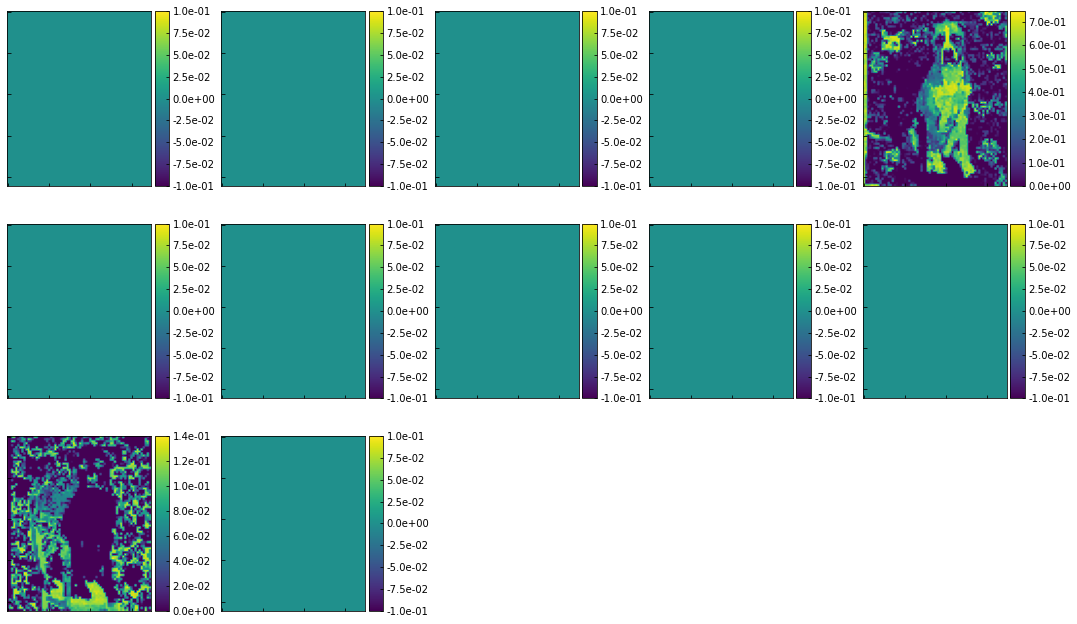

In [43]:
embedding_maps(encode, image)

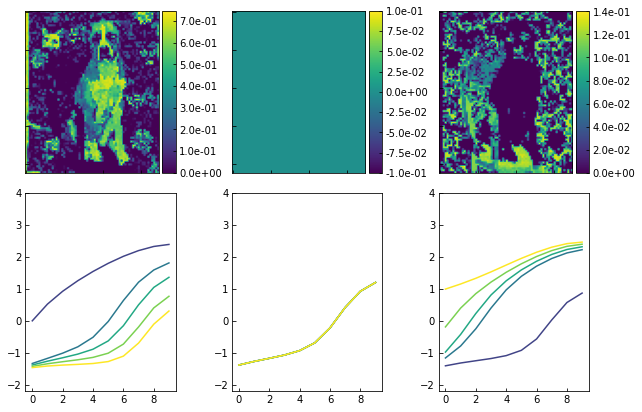

In [44]:
latent_generator(decoder, encode, image, 5, 10, indx=[4, 3, 10], device=device)

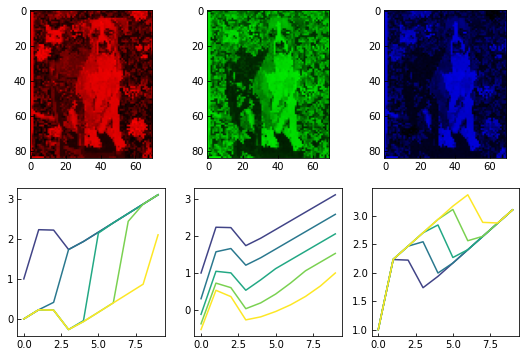

In [45]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)

In [46]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

c:\Conda\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Beta Variational Autoencoder

- Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution


### Normal Autoencoder

![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE1.png?raw=true)


### VAE

- Encoder identifies some distribution --> generates from that distribution
  ![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE2.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE3.png?raw=true)


![](https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/VAE4.png?raw=true)


### Builds the Model


In [47]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x

In [48]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

### Training


In [49]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) // epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if (
            (epoch - initial_epochs) // epoch_per_beta
            == (epoch - initial_epochs) / epoch_per_beta
        ) and (epoch >= initial_epochs):

            best_train_loss = float("inf")

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
            }
            if epoch >= 0:
                torch.save(
                    checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                )

In [50]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)

100%|██████████| 19/19 [00:00<00:00, 125.59it/s]


Epoch 0, Train Loss: 2.1055
.............................


100%|██████████| 19/19 [00:00<00:00, 218.12it/s]


Epoch 1, Train Loss: 2.0683
.............................


100%|██████████| 19/19 [00:00<00:00, 195.77it/s]


Epoch 2, Train Loss: 2.0328
.............................


100%|██████████| 19/19 [00:00<00:00, 199.82it/s]


Epoch 3, Train Loss: 2.0028
.............................


100%|██████████| 19/19 [00:00<00:00, 214.41it/s]


Epoch 4, Train Loss: 1.9607
.............................


100%|██████████| 19/19 [00:00<00:00, 206.81it/s]


Epoch 5, Train Loss: 1.9102
.............................


100%|██████████| 19/19 [00:00<00:00, 210.78it/s]


Epoch 6, Train Loss: 1.8534
.............................


100%|██████████| 19/19 [00:00<00:00, 198.57it/s]


Epoch 7, Train Loss: 1.7744
.............................


100%|██████████| 19/19 [00:00<00:00, 199.07it/s]


Epoch 8, Train Loss: 1.6892
.............................


100%|██████████| 19/19 [00:00<00:00, 199.89it/s]


Epoch 9, Train Loss: 1.5761
.............................


100%|██████████| 19/19 [00:00<00:00, 186.15it/s]


Epoch 10, Train Loss: 1.4694
.............................


100%|██████████| 19/19 [00:00<00:00, 210.91it/s]


Epoch 11, Train Loss: 1.3667
.............................


100%|██████████| 19/19 [00:00<00:00, 201.67it/s]


Epoch 12, Train Loss: 1.2435
.............................


100%|██████████| 19/19 [00:00<00:00, 203.25it/s]


Epoch 13, Train Loss: 1.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 206.64it/s]


Epoch 14, Train Loss: 1.0432
.............................


100%|██████████| 19/19 [00:00<00:00, 211.00it/s]


Epoch 15, Train Loss: 0.9562
.............................


100%|██████████| 19/19 [00:00<00:00, 210.77it/s]


Epoch 16, Train Loss: 0.8767
.............................


100%|██████████| 19/19 [00:00<00:00, 197.91it/s]


Epoch 17, Train Loss: 0.7903
.............................


100%|██████████| 19/19 [00:00<00:00, 197.97it/s]


Epoch 18, Train Loss: 0.7102
.............................


100%|██████████| 19/19 [00:00<00:00, 206.31it/s]


Epoch 19, Train Loss: 0.6191
.............................


100%|██████████| 19/19 [00:00<00:00, 208.42it/s]


Epoch 20, Train Loss: 0.5343
.............................


100%|██████████| 19/19 [00:00<00:00, 199.33it/s]


Epoch 21, Train Loss: 0.4568
.............................


100%|██████████| 19/19 [00:00<00:00, 210.91it/s]


Epoch 22, Train Loss: 0.3811
.............................


100%|██████████| 19/19 [00:00<00:00, 206.51it/s]


Epoch 23, Train Loss: 0.3270
.............................


100%|██████████| 19/19 [00:00<00:00, 190.29it/s]


Epoch 24, Train Loss: 0.2903
.............................


100%|██████████| 19/19 [00:00<00:00, 208.50it/s]


Epoch 25, Train Loss: 0.2677
.............................


100%|██████████| 19/19 [00:00<00:00, 218.26it/s]


Epoch 26, Train Loss: 0.2524
.............................


100%|██████████| 19/19 [00:00<00:00, 195.70it/s]


Epoch 27, Train Loss: 0.2430
.............................


100%|██████████| 19/19 [00:00<00:00, 206.17it/s]


Epoch 28, Train Loss: 0.2323
.............................


100%|██████████| 19/19 [00:00<00:00, 218.07it/s]


Epoch 29, Train Loss: 0.2246
.............................


100%|██████████| 19/19 [00:00<00:00, 203.70it/s]


Epoch 30, Train Loss: 0.2180
.............................


100%|██████████| 19/19 [00:00<00:00, 213.06it/s]


Epoch 31, Train Loss: 0.2118
.............................


100%|██████████| 19/19 [00:00<00:00, 204.10it/s]


Epoch 32, Train Loss: 0.2067
.............................


100%|██████████| 19/19 [00:00<00:00, 205.84it/s]


Epoch 33, Train Loss: 0.2031
.............................


100%|██████████| 19/19 [00:00<00:00, 204.14it/s]


Epoch 34, Train Loss: 0.1971
.............................


100%|██████████| 19/19 [00:00<00:00, 211.15it/s]


Epoch 35, Train Loss: 0.1941
.............................


100%|██████████| 19/19 [00:00<00:00, 208.60it/s]


Epoch 36, Train Loss: 0.1889
.............................


100%|██████████| 19/19 [00:00<00:00, 199.85it/s]


Epoch 37, Train Loss: 0.1866
.............................


100%|██████████| 19/19 [00:00<00:00, 202.04it/s]


Epoch 38, Train Loss: 0.1833
.............................


100%|██████████| 19/19 [00:00<00:00, 200.01it/s]


Epoch 39, Train Loss: 0.1795
.............................


100%|██████████| 19/19 [00:00<00:00, 194.98it/s]


Epoch 40, Train Loss: 0.1766
.............................


100%|██████████| 19/19 [00:00<00:00, 195.88it/s]


Epoch 41, Train Loss: 0.1738
.............................


100%|██████████| 19/19 [00:00<00:00, 197.59it/s]


Epoch 42, Train Loss: 0.1705
.............................


100%|██████████| 19/19 [00:00<00:00, 201.48it/s]


Epoch 43, Train Loss: 0.1680
.............................


100%|██████████| 19/19 [00:00<00:00, 208.65it/s]


Epoch 44, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 208.60it/s]


Epoch 45, Train Loss: 0.1624
.............................


100%|██████████| 19/19 [00:00<00:00, 193.50it/s]


Epoch 46, Train Loss: 0.1593
.............................


100%|██████████| 19/19 [00:00<00:00, 199.94it/s]


Epoch 47, Train Loss: 0.1566
.............................


100%|██████████| 19/19 [00:00<00:00, 199.86it/s]


Epoch 48, Train Loss: 0.1541
.............................


100%|██████████| 19/19 [00:00<00:00, 195.94it/s]


Epoch 49, Train Loss: 0.1515
.............................


100%|██████████| 19/19 [00:00<00:00, 202.08it/s]


Epoch 50, Train Loss: 0.1484
.............................


100%|██████████| 19/19 [00:00<00:00, 195.87it/s]


Epoch 51, Train Loss: 0.1460
.............................


100%|██████████| 19/19 [00:00<00:00, 197.87it/s]


Epoch 52, Train Loss: 0.1429
.............................


100%|██████████| 19/19 [00:00<00:00, 196.00it/s]


Epoch 53, Train Loss: 0.1398
.............................


100%|██████████| 19/19 [00:00<00:00, 195.03it/s]


Epoch 54, Train Loss: 0.1376
.............................


100%|██████████| 19/19 [00:00<00:00, 193.89it/s]


Epoch 55, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 187.97it/s]


Epoch 56, Train Loss: 0.1326
.............................


100%|██████████| 19/19 [00:00<00:00, 201.44it/s]


Epoch 57, Train Loss: 0.1308
.............................


100%|██████████| 19/19 [00:00<00:00, 182.14it/s]


Epoch 58, Train Loss: 0.1287
.............................


100%|██████████| 19/19 [00:00<00:00, 182.60it/s]


Epoch 59, Train Loss: 0.1266
.............................


100%|██████████| 19/19 [00:00<00:00, 163.39it/s]


Epoch 60, Train Loss: 0.1249
.............................


100%|██████████| 19/19 [00:00<00:00, 215.55it/s]


Epoch 61, Train Loss: 0.1231
.............................


100%|██████████| 19/19 [00:00<00:00, 191.93it/s]


Epoch 62, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 193.76it/s]


Epoch 63, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 162.11it/s]


Epoch 64, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 195.39it/s]


Epoch 65, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 218.24it/s]


Epoch 66, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 215.73it/s]


Epoch 67, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 193.54it/s]


Epoch 68, Train Loss: 0.1138
.............................


100%|██████████| 19/19 [00:00<00:00, 191.89it/s]


Epoch 69, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 163.75it/s]


Epoch 70, Train Loss: 0.1114
.............................


100%|██████████| 19/19 [00:00<00:00, 197.40it/s]


Epoch 71, Train Loss: 0.1105
.............................


100%|██████████| 19/19 [00:00<00:00, 161.66it/s]


Epoch 72, Train Loss: 0.1092
.............................


100%|██████████| 19/19 [00:00<00:00, 189.75it/s]


Epoch 73, Train Loss: 0.1082
.............................


100%|██████████| 19/19 [00:00<00:00, 195.51it/s]


Epoch 74, Train Loss: 0.1071
.............................


100%|██████████| 19/19 [00:00<00:00, 211.26it/s]


Epoch 75, Train Loss: 0.1060
.............................


100%|██████████| 19/19 [00:00<00:00, 213.47it/s]


Epoch 76, Train Loss: 0.1047
.............................


100%|██████████| 19/19 [00:00<00:00, 197.83it/s]


Epoch 77, Train Loss: 0.1034
.............................


100%|██████████| 19/19 [00:00<00:00, 190.07it/s]


Epoch 78, Train Loss: 0.1022
.............................


100%|██████████| 19/19 [00:00<00:00, 210.37it/s]


Epoch 79, Train Loss: 0.1009
.............................


100%|██████████| 19/19 [00:00<00:00, 191.63it/s]


Epoch 80, Train Loss: 0.0994
.............................


100%|██████████| 19/19 [00:00<00:00, 199.93it/s]


Epoch 81, Train Loss: 0.0980
.............................


100%|██████████| 19/19 [00:00<00:00, 206.41it/s]


Epoch 82, Train Loss: 0.0965
.............................


100%|██████████| 19/19 [00:00<00:00, 199.61it/s]


Epoch 83, Train Loss: 0.0946
.............................


100%|██████████| 19/19 [00:00<00:00, 175.82it/s]


Epoch 84, Train Loss: 0.0928
.............................


100%|██████████| 19/19 [00:00<00:00, 210.91it/s]


Epoch 85, Train Loss: 0.0908
.............................


100%|██████████| 19/19 [00:00<00:00, 199.22it/s]


Epoch 86, Train Loss: 0.0888
.............................


100%|██████████| 19/19 [00:00<00:00, 204.21it/s]


Epoch 87, Train Loss: 0.0866
.............................


100%|██████████| 19/19 [00:00<00:00, 199.98it/s]


Epoch 88, Train Loss: 0.0846
.............................


100%|██████████| 19/19 [00:00<00:00, 165.92it/s]


Epoch 89, Train Loss: 0.0821
.............................


100%|██████████| 19/19 [00:00<00:00, 198.01it/s]


Epoch 90, Train Loss: 0.0797
.............................


100%|██████████| 19/19 [00:00<00:00, 211.23it/s]


Epoch 91, Train Loss: 0.0771
.............................


100%|██████████| 19/19 [00:00<00:00, 213.24it/s]


Epoch 92, Train Loss: 0.0751
.............................


100%|██████████| 19/19 [00:00<00:00, 179.03it/s]


Epoch 93, Train Loss: 0.0733
.............................


100%|██████████| 19/19 [00:00<00:00, 195.88it/s]


Epoch 94, Train Loss: 0.0718
.............................


100%|██████████| 19/19 [00:00<00:00, 204.16it/s]


Epoch 95, Train Loss: 0.0705
.............................


100%|██████████| 19/19 [00:00<00:00, 196.19it/s]


Epoch 96, Train Loss: 0.0694
.............................


100%|██████████| 19/19 [00:00<00:00, 206.25it/s]


Epoch 97, Train Loss: 0.0684
.............................


100%|██████████| 19/19 [00:00<00:00, 204.33it/s]


Epoch 98, Train Loss: 0.0672
.............................


100%|██████████| 19/19 [00:00<00:00, 211.01it/s]


Epoch 99, Train Loss: 0.0662
.............................


100%|██████████| 19/19 [00:00<00:00, 208.54it/s]


Epoch 100, Train Loss: 0.0652
.............................


100%|██████████| 19/19 [00:00<00:00, 208.70it/s]


Epoch 101, Train Loss: 0.0643
.............................


100%|██████████| 19/19 [00:00<00:00, 218.39it/s]


Epoch 102, Train Loss: 0.0634
.............................


100%|██████████| 19/19 [00:00<00:00, 204.23it/s]


Epoch 103, Train Loss: 0.0625
.............................


100%|██████████| 19/19 [00:00<00:00, 202.13it/s]


Epoch 104, Train Loss: 0.0616
.............................


100%|██████████| 19/19 [00:00<00:00, 215.61it/s]


Epoch 105, Train Loss: 0.0609
.............................


100%|██████████| 19/19 [00:00<00:00, 199.81it/s]


Epoch 106, Train Loss: 0.0601
.............................


100%|██████████| 19/19 [00:00<00:00, 211.09it/s]


Epoch 107, Train Loss: 0.0592
.............................


100%|██████████| 19/19 [00:00<00:00, 215.89it/s]


Epoch 108, Train Loss: 0.0585
.............................


100%|██████████| 19/19 [00:00<00:00, 208.58it/s]


Epoch 109, Train Loss: 0.0577
.............................


100%|██████████| 19/19 [00:00<00:00, 193.77it/s]


Epoch 110, Train Loss: 0.0568
.............................


100%|██████████| 19/19 [00:00<00:00, 215.91it/s]


Epoch 111, Train Loss: 0.0562
.............................


100%|██████████| 19/19 [00:00<00:00, 199.92it/s]


Epoch 112, Train Loss: 0.0556
.............................


100%|██████████| 19/19 [00:00<00:00, 215.91it/s]


Epoch 113, Train Loss: 0.0549
.............................


100%|██████████| 19/19 [00:00<00:00, 208.69it/s]


Epoch 114, Train Loss: 0.0542
.............................


100%|██████████| 19/19 [00:00<00:00, 206.41it/s]


Epoch 115, Train Loss: 0.0534
.............................


100%|██████████| 19/19 [00:00<00:00, 215.77it/s]


Epoch 116, Train Loss: 0.0528
.............................


100%|██████████| 19/19 [00:00<00:00, 211.09it/s]


Epoch 117, Train Loss: 0.0521
.............................


100%|██████████| 19/19 [00:00<00:00, 200.00it/s]


Epoch 118, Train Loss: 0.0515
.............................


100%|██████████| 19/19 [00:00<00:00, 204.30it/s]


Epoch 119, Train Loss: 0.0509
.............................


100%|██████████| 19/19 [00:00<00:00, 201.99it/s]


Epoch 120, Train Loss: 0.0502
.............................


100%|██████████| 19/19 [00:00<00:00, 204.20it/s]


Epoch 121, Train Loss: 0.0497
.............................


100%|██████████| 19/19 [00:00<00:00, 204.21it/s]


Epoch 122, Train Loss: 0.0490
.............................


100%|██████████| 19/19 [00:00<00:00, 202.14it/s]


Epoch 123, Train Loss: 0.0484
.............................


100%|██████████| 19/19 [00:00<00:00, 213.56it/s]


Epoch 124, Train Loss: 0.0478
.............................


100%|██████████| 19/19 [00:00<00:00, 206.52it/s]


Epoch 125, Train Loss: 0.0472
.............................


100%|██████████| 19/19 [00:00<00:00, 193.82it/s]


Epoch 126, Train Loss: 0.0467
.............................


100%|██████████| 19/19 [00:00<00:00, 193.86it/s]


Epoch 127, Train Loss: 0.0460
.............................


100%|██████████| 19/19 [00:00<00:00, 195.83it/s]


Epoch 128, Train Loss: 0.0456
.............................


100%|██████████| 19/19 [00:00<00:00, 213.56it/s]


Epoch 129, Train Loss: 0.0449
.............................


100%|██████████| 19/19 [00:00<00:00, 195.87it/s]


Epoch 130, Train Loss: 0.0444
.............................


100%|██████████| 19/19 [00:00<00:00, 200.00it/s]


Epoch 131, Train Loss: 0.0439
.............................


100%|██████████| 19/19 [00:00<00:00, 204.19it/s]


Epoch 132, Train Loss: 0.0433
.............................


100%|██████████| 19/19 [00:00<00:00, 204.32it/s]


Epoch 133, Train Loss: 0.0427
.............................


100%|██████████| 19/19 [00:00<00:00, 208.63it/s]


Epoch 134, Train Loss: 0.0422
.............................


100%|██████████| 19/19 [00:00<00:00, 211.12it/s]


Epoch 135, Train Loss: 0.0416
.............................


100%|██████████| 19/19 [00:00<00:00, 200.03it/s]


Epoch 136, Train Loss: 0.0411
.............................


100%|██████████| 19/19 [00:00<00:00, 210.92it/s]


Epoch 137, Train Loss: 0.0406
.............................


100%|██████████| 19/19 [00:00<00:00, 202.03it/s]


Epoch 138, Train Loss: 0.0402
.............................


100%|██████████| 19/19 [00:00<00:00, 192.36it/s]


Epoch 139, Train Loss: 0.0396
.............................


100%|██████████| 19/19 [00:00<00:00, 204.19it/s]


Epoch 140, Train Loss: 0.0391
.............................


100%|██████████| 19/19 [00:00<00:00, 218.26it/s]


Epoch 141, Train Loss: 0.0386
.............................


100%|██████████| 19/19 [00:00<00:00, 197.95it/s]


Epoch 142, Train Loss: 0.0381
.............................


100%|██████████| 19/19 [00:00<00:00, 218.26it/s]


Epoch 143, Train Loss: 0.0375
.............................


100%|██████████| 19/19 [00:00<00:00, 200.66it/s]


Epoch 144, Train Loss: 0.0370
.............................


100%|██████████| 19/19 [00:00<00:00, 204.11it/s]


Epoch 145, Train Loss: 0.0365
.............................


100%|██████████| 19/19 [00:00<00:00, 202.19it/s]


Epoch 146, Train Loss: 0.0360
.............................


100%|██████████| 19/19 [00:00<00:00, 175.27it/s]


Epoch 147, Train Loss: 0.0356
.............................


100%|██████████| 19/19 [00:00<00:00, 213.35it/s]


Epoch 148, Train Loss: 0.0351
.............................


100%|██████████| 19/19 [00:00<00:00, 162.46it/s]


Epoch 149, Train Loss: 0.0347
.............................


100%|██████████| 19/19 [00:00<00:00, 189.93it/s]


Epoch 150, Train Loss: 0.0341
.............................


100%|██████████| 19/19 [00:00<00:00, 193.74it/s]


Epoch 151, Train Loss: 0.0338
.............................


100%|██████████| 19/19 [00:00<00:00, 193.27it/s]


Epoch 152, Train Loss: 0.0333
.............................


100%|██████████| 19/19 [00:00<00:00, 215.76it/s]


Epoch 153, Train Loss: 0.0328
.............................


100%|██████████| 19/19 [00:00<00:00, 200.74it/s]


Epoch 154, Train Loss: 0.0324
.............................


100%|██████████| 19/19 [00:00<00:00, 183.88it/s]


Epoch 155, Train Loss: 0.0321
.............................


100%|██████████| 19/19 [00:00<00:00, 193.79it/s]


Epoch 156, Train Loss: 0.0316
.............................


100%|██████████| 19/19 [00:00<00:00, 174.07it/s]


Epoch 157, Train Loss: 0.0312
.............................


100%|██████████| 19/19 [00:00<00:00, 210.89it/s]


Epoch 158, Train Loss: 0.0309
.............................


100%|██████████| 19/19 [00:00<00:00, 190.11it/s]


Epoch 159, Train Loss: 0.0304
.............................


100%|██████████| 19/19 [00:00<00:00, 166.60it/s]


Epoch 160, Train Loss: 0.0301
.............................


100%|██████████| 19/19 [00:00<00:00, 204.11it/s]


Epoch 161, Train Loss: 0.0297
.............................


100%|██████████| 19/19 [00:00<00:00, 170.85it/s]


Epoch 162, Train Loss: 0.0293
.............................


100%|██████████| 19/19 [00:00<00:00, 199.73it/s]


Epoch 163, Train Loss: 0.0289
.............................


100%|██████████| 19/19 [00:00<00:00, 197.54it/s]


Epoch 164, Train Loss: 0.0285
.............................


100%|██████████| 19/19 [00:00<00:00, 195.81it/s]


Epoch 165, Train Loss: 0.0282
.............................


100%|██████████| 19/19 [00:00<00:00, 213.29it/s]


Epoch 166, Train Loss: 0.0279
.............................


100%|██████████| 19/19 [00:00<00:00, 165.17it/s]


Epoch 167, Train Loss: 0.0274
.............................


100%|██████████| 19/19 [00:00<00:00, 173.81it/s]


Epoch 168, Train Loss: 0.0271
.............................


100%|██████████| 19/19 [00:00<00:00, 205.97it/s]


Epoch 169, Train Loss: 0.0267
.............................


100%|██████████| 19/19 [00:00<00:00, 169.51it/s]


Epoch 170, Train Loss: 0.0264
.............................


100%|██████████| 19/19 [00:00<00:00, 206.34it/s]


Epoch 171, Train Loss: 0.0260
.............................


100%|██████████| 19/19 [00:00<00:00, 193.82it/s]


Epoch 172, Train Loss: 0.0255
.............................


100%|██████████| 19/19 [00:00<00:00, 175.76it/s]


Epoch 173, Train Loss: 0.0252
.............................


100%|██████████| 19/19 [00:00<00:00, 196.95it/s]


Epoch 174, Train Loss: 0.0248
.............................


100%|██████████| 19/19 [00:00<00:00, 165.14it/s]


Epoch 175, Train Loss: 0.0244
.............................


100%|██████████| 19/19 [00:00<00:00, 206.51it/s]


Epoch 176, Train Loss: 0.0240
.............................


100%|██████████| 19/19 [00:00<00:00, 152.08it/s]


Epoch 177, Train Loss: 0.0236
.............................


100%|██████████| 19/19 [00:00<00:00, 169.63it/s]


Epoch 178, Train Loss: 0.0232
.............................


100%|██████████| 19/19 [00:00<00:00, 168.14it/s]


Epoch 179, Train Loss: 0.0229
.............................


100%|██████████| 19/19 [00:00<00:00, 172.73it/s]


Epoch 180, Train Loss: 0.0225
.............................


100%|██████████| 19/19 [00:00<00:00, 193.64it/s]


Epoch 181, Train Loss: 0.0222
.............................


100%|██████████| 19/19 [00:00<00:00, 158.33it/s]


Epoch 182, Train Loss: 0.0218
.............................


100%|██████████| 19/19 [00:00<00:00, 186.27it/s]


Epoch 183, Train Loss: 0.0214
.............................


100%|██████████| 19/19 [00:00<00:00, 145.04it/s]


Epoch 184, Train Loss: 0.0212
.............................


100%|██████████| 19/19 [00:00<00:00, 179.25it/s]


Epoch 185, Train Loss: 0.0209
.............................


100%|██████████| 19/19 [00:00<00:00, 213.33it/s]


Epoch 186, Train Loss: 0.0205
.............................


100%|██████████| 19/19 [00:00<00:00, 182.67it/s]


Epoch 187, Train Loss: 0.0203
.............................


100%|██████████| 19/19 [00:00<00:00, 186.28it/s]


Epoch 188, Train Loss: 0.0200
.............................


100%|██████████| 19/19 [00:00<00:00, 199.98it/s]


Epoch 189, Train Loss: 0.0198
.............................


100%|██████████| 19/19 [00:00<00:00, 193.61it/s]


Epoch 190, Train Loss: 0.0196
.............................


100%|██████████| 19/19 [00:00<00:00, 215.70it/s]


Epoch 191, Train Loss: 0.0193
.............................


100%|██████████| 19/19 [00:00<00:00, 203.96it/s]


Epoch 192, Train Loss: 0.0191
.............................


100%|██████████| 19/19 [00:00<00:00, 192.78it/s]


Epoch 193, Train Loss: 0.0188
.............................


100%|██████████| 19/19 [00:00<00:00, 201.74it/s]


Epoch 194, Train Loss: 0.0186
.............................


100%|██████████| 19/19 [00:00<00:00, 195.85it/s]


Epoch 195, Train Loss: 0.0184
.............................


100%|██████████| 19/19 [00:00<00:00, 190.00it/s]


Epoch 196, Train Loss: 0.0182
.............................


100%|██████████| 19/19 [00:00<00:00, 190.00it/s]


Epoch 197, Train Loss: 0.0181
.............................


100%|██████████| 19/19 [00:00<00:00, 197.80it/s]


Epoch 198, Train Loss: 0.0178
.............................


100%|██████████| 19/19 [00:00<00:00, 200.00it/s]


Epoch 199, Train Loss: 0.0176
.............................


100%|██████████| 19/19 [00:00<00:00, 197.56it/s]


Epoch 200, Train Loss: 1.7312
.............................


100%|██████████| 19/19 [00:00<00:00, 206.19it/s]


Epoch 201, Train Loss: 0.7938
.............................


100%|██████████| 19/19 [00:00<00:00, 175.91it/s]


Epoch 202, Train Loss: 0.4537
.............................


100%|██████████| 19/19 [00:00<00:00, 206.46it/s]


Epoch 203, Train Loss: 0.3404
.............................


100%|██████████| 19/19 [00:00<00:00, 202.13it/s]


Epoch 204, Train Loss: 0.3060
.............................


100%|██████████| 19/19 [00:00<00:00, 190.02it/s]


Epoch 205, Train Loss: 0.2873
.............................


100%|██████████| 19/19 [00:00<00:00, 200.39it/s]


Epoch 206, Train Loss: 0.2746
.............................


100%|██████████| 19/19 [00:00<00:00, 209.74it/s]


Epoch 207, Train Loss: 0.2681
.............................


100%|██████████| 19/19 [00:00<00:00, 201.98it/s]


Epoch 208, Train Loss: 0.2559
.............................


100%|██████████| 19/19 [00:00<00:00, 208.42it/s]


Epoch 209, Train Loss: 0.2517
.............................


100%|██████████| 19/19 [00:00<00:00, 199.60it/s]


Epoch 210, Train Loss: 0.2446
.............................


100%|██████████| 19/19 [00:00<00:00, 193.21it/s]


Epoch 211, Train Loss: 0.2385
.............................


100%|██████████| 19/19 [00:00<00:00, 190.00it/s]


Epoch 212, Train Loss: 0.2345
.............................


100%|██████████| 19/19 [00:00<00:00, 186.27it/s]


Epoch 213, Train Loss: 0.2295
.............................


100%|██████████| 19/19 [00:00<00:00, 186.21it/s]


Epoch 214, Train Loss: 0.2269
.............................


100%|██████████| 19/19 [00:00<00:00, 182.69it/s]


Epoch 215, Train Loss: 0.2217
.............................


100%|██████████| 19/19 [00:00<00:00, 177.55it/s]


Epoch 216, Train Loss: 0.2203
.............................


100%|██████████| 19/19 [00:00<00:00, 192.93it/s]


Epoch 217, Train Loss: 0.2156
.............................


100%|██████████| 19/19 [00:00<00:00, 195.87it/s]


Epoch 218, Train Loss: 0.2127
.............................


100%|██████████| 19/19 [00:00<00:00, 171.17it/s]


Epoch 219, Train Loss: 0.2067
.............................


100%|██████████| 19/19 [00:00<00:00, 190.00it/s]


Epoch 220, Train Loss: 0.2055
.............................


100%|██████████| 19/19 [00:00<00:00, 139.70it/s]


Epoch 221, Train Loss: 0.2026
.............................


100%|██████████| 19/19 [00:00<00:00, 163.79it/s]


Epoch 222, Train Loss: 0.1987
.............................


100%|██████████| 19/19 [00:00<00:00, 137.68it/s]


Epoch 223, Train Loss: 0.1972
.............................


100%|██████████| 19/19 [00:00<00:00, 163.79it/s]


Epoch 224, Train Loss: 0.1956
.............................


100%|██████████| 19/19 [00:00<00:00, 140.74it/s]


Epoch 225, Train Loss: 0.1930
.............................


100%|██████████| 19/19 [00:00<00:00, 186.17it/s]


Epoch 226, Train Loss: 0.1906
.............................


100%|██████████| 19/19 [00:00<00:00, 184.59it/s]


Epoch 227, Train Loss: 0.1898
.............................


100%|██████████| 19/19 [00:00<00:00, 172.68it/s]


Epoch 228, Train Loss: 0.1862
.............................


100%|██████████| 19/19 [00:00<00:00, 197.89it/s]


Epoch 229, Train Loss: 0.1833
.............................


100%|██████████| 19/19 [00:00<00:00, 187.99it/s]


Epoch 230, Train Loss: 0.1816
.............................


100%|██████████| 19/19 [00:00<00:00, 179.34it/s]


Epoch 231, Train Loss: 0.1788
.............................


100%|██████████| 19/19 [00:00<00:00, 186.28it/s]


Epoch 232, Train Loss: 0.1746
.............................


100%|██████████| 19/19 [00:00<00:00, 191.92it/s]


Epoch 233, Train Loss: 0.1755
.............................


100%|██████████| 19/19 [00:00<00:00, 179.25it/s]


Epoch 234, Train Loss: 0.1740
.............................


100%|██████████| 19/19 [00:00<00:00, 168.14it/s]


Epoch 235, Train Loss: 0.1708
.............................


100%|██████████| 19/19 [00:00<00:00, 180.96it/s]


Epoch 236, Train Loss: 0.1694
.............................


100%|██████████| 19/19 [00:00<00:00, 201.08it/s]


Epoch 237, Train Loss: 0.1693
.............................


100%|██████████| 19/19 [00:00<00:00, 193.76it/s]


Epoch 238, Train Loss: 0.1663
.............................


100%|██████████| 19/19 [00:00<00:00, 223.14it/s]


Epoch 239, Train Loss: 0.1656
.............................


100%|██████████| 19/19 [00:00<00:00, 202.11it/s]


Epoch 240, Train Loss: 0.1639
.............................


100%|██████████| 19/19 [00:00<00:00, 208.80it/s]


Epoch 241, Train Loss: 0.1618
.............................


100%|██████████| 19/19 [00:00<00:00, 194.00it/s]


Epoch 242, Train Loss: 0.1611
.............................


100%|██████████| 19/19 [00:00<00:00, 208.67it/s]


Epoch 243, Train Loss: 0.1609
.............................


100%|██████████| 19/19 [00:00<00:00, 195.75it/s]


Epoch 244, Train Loss: 0.1582
.............................


100%|██████████| 19/19 [00:00<00:00, 188.01it/s]


Epoch 245, Train Loss: 0.1553
.............................


100%|██████████| 19/19 [00:00<00:00, 204.30it/s]


Epoch 246, Train Loss: 0.1563
.............................


100%|██████████| 19/19 [00:00<00:00, 204.30it/s]


Epoch 247, Train Loss: 0.1540
.............................


100%|██████████| 19/19 [00:00<00:00, 206.23it/s]


Epoch 248, Train Loss: 0.1534
.............................


100%|██████████| 19/19 [00:00<00:00, 202.31it/s]


Epoch 249, Train Loss: 0.1505
.............................


100%|██████████| 19/19 [00:00<00:00, 204.04it/s]


Epoch 250, Train Loss: 0.1503
.............................


100%|██████████| 19/19 [00:00<00:00, 197.90it/s]


Epoch 251, Train Loss: 0.1486
.............................


100%|██████████| 19/19 [00:00<00:00, 208.55it/s]


Epoch 252, Train Loss: 0.1467
.............................


100%|██████████| 19/19 [00:00<00:00, 204.30it/s]


Epoch 253, Train Loss: 0.1468
.............................


100%|██████████| 19/19 [00:00<00:00, 204.17it/s]


Epoch 254, Train Loss: 0.1458
.............................


100%|██████████| 19/19 [00:00<00:00, 218.02it/s]


Epoch 255, Train Loss: 0.1441
.............................


100%|██████████| 19/19 [00:00<00:00, 202.06it/s]


Epoch 256, Train Loss: 0.1437
.............................


100%|██████████| 19/19 [00:00<00:00, 197.90it/s]


Epoch 257, Train Loss: 0.1431
.............................


100%|██████████| 19/19 [00:00<00:00, 207.54it/s]


Epoch 258, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 197.75it/s]


Epoch 259, Train Loss: 0.1395
.............................


100%|██████████| 19/19 [00:00<00:00, 177.48it/s]


Epoch 260, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 200.01it/s]


Epoch 261, Train Loss: 0.1372
.............................


100%|██████████| 19/19 [00:00<00:00, 216.75it/s]


Epoch 262, Train Loss: 0.1368
.............................


100%|██████████| 19/19 [00:00<00:00, 213.06it/s]


Epoch 263, Train Loss: 0.1363
.............................


100%|██████████| 19/19 [00:00<00:00, 179.07it/s]


Epoch 264, Train Loss: 0.1351
.............................


100%|██████████| 19/19 [00:00<00:00, 199.87it/s]


Epoch 265, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 208.54it/s]


Epoch 266, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 215.76it/s]


Epoch 267, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 208.74it/s]


Epoch 268, Train Loss: 0.1307
.............................


100%|██████████| 19/19 [00:00<00:00, 211.06it/s]


Epoch 269, Train Loss: 0.1307
.............................


100%|██████████| 19/19 [00:00<00:00, 208.92it/s]


Epoch 270, Train Loss: 0.1295
.............................


100%|██████████| 19/19 [00:00<00:00, 186.27it/s]


Epoch 271, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 196.01it/s]


Epoch 272, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 193.63it/s]


Epoch 273, Train Loss: 0.1257
.............................


100%|██████████| 19/19 [00:00<00:00, 188.19it/s]


Epoch 274, Train Loss: 0.1268
.............................


100%|██████████| 19/19 [00:00<00:00, 171.17it/s]


Epoch 275, Train Loss: 0.1247
.............................


100%|██████████| 19/19 [00:00<00:00, 189.83it/s]


Epoch 276, Train Loss: 0.1242
.............................


100%|██████████| 19/19 [00:00<00:00, 195.88it/s]


Epoch 277, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 179.25it/s]


Epoch 278, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 177.57it/s]


Epoch 279, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 193.60it/s]


Epoch 280, Train Loss: 0.1207
.............................


100%|██████████| 19/19 [00:00<00:00, 182.69it/s]


Epoch 281, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 204.31it/s]


Epoch 282, Train Loss: 0.1184
.............................


100%|██████████| 19/19 [00:00<00:00, 199.10it/s]


Epoch 283, Train Loss: 0.1190
.............................


100%|██████████| 19/19 [00:00<00:00, 205.36it/s]


Epoch 284, Train Loss: 0.1182
.............................


100%|██████████| 19/19 [00:00<00:00, 215.77it/s]


Epoch 285, Train Loss: 0.1170
.............................


100%|██████████| 19/19 [00:00<00:00, 193.83it/s]


Epoch 286, Train Loss: 0.1156
.............................


100%|██████████| 19/19 [00:00<00:00, 159.14it/s]


Epoch 287, Train Loss: 0.1156
.............................


100%|██████████| 19/19 [00:00<00:00, 188.01it/s]


Epoch 288, Train Loss: 0.1153
.............................


100%|██████████| 19/19 [00:00<00:00, 197.58it/s]


Epoch 289, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 206.39it/s]


Epoch 290, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 201.07it/s]


Epoch 291, Train Loss: 0.1139
.............................


100%|██████████| 19/19 [00:00<00:00, 188.12it/s]


Epoch 292, Train Loss: 0.1123
.............................


100%|██████████| 19/19 [00:00<00:00, 197.92it/s]


Epoch 293, Train Loss: 0.1105
.............................


100%|██████████| 19/19 [00:00<00:00, 202.02it/s]


Epoch 294, Train Loss: 0.1114
.............................


100%|██████████| 19/19 [00:00<00:00, 206.51it/s]


Epoch 295, Train Loss: 0.1106
.............................


100%|██████████| 19/19 [00:00<00:00, 195.91it/s]


Epoch 296, Train Loss: 0.1100
.............................


100%|██████████| 19/19 [00:00<00:00, 201.95it/s]


Epoch 297, Train Loss: 0.1094
.............................


100%|██████████| 19/19 [00:00<00:00, 193.88it/s]


Epoch 298, Train Loss: 0.1094
.............................


100%|██████████| 19/19 [00:00<00:00, 197.82it/s]


Epoch 299, Train Loss: 0.1072
.............................


100%|██████████| 19/19 [00:00<00:00, 193.37it/s]


Epoch 300, Train Loss: 0.1514
.............................


100%|██████████| 19/19 [00:00<00:00, 197.79it/s]


Epoch 301, Train Loss: 0.1452
.............................


100%|██████████| 19/19 [00:00<00:00, 182.53it/s]


Epoch 302, Train Loss: 0.1435
.............................


100%|██████████| 19/19 [00:00<00:00, 175.84it/s]


Epoch 303, Train Loss: 0.1431
.............................


100%|██████████| 19/19 [00:00<00:00, 175.61it/s]


Epoch 304, Train Loss: 0.1414
.............................


100%|██████████| 19/19 [00:00<00:00, 188.12it/s]


Epoch 305, Train Loss: 0.1416
.............................


100%|██████████| 19/19 [00:00<00:00, 218.17it/s]


Epoch 306, Train Loss: 0.1408
.............................


100%|██████████| 19/19 [00:00<00:00, 195.79it/s]


Epoch 307, Train Loss: 0.1402
.............................


100%|██████████| 19/19 [00:00<00:00, 186.80it/s]


Epoch 308, Train Loss: 0.1384
.............................


100%|██████████| 19/19 [00:00<00:00, 197.58it/s]


Epoch 309, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 206.53it/s]


Epoch 310, Train Loss: 0.1357
.............................


100%|██████████| 19/19 [00:00<00:00, 199.94it/s]


Epoch 311, Train Loss: 0.1365
.............................


100%|██████████| 19/19 [00:00<00:00, 186.33it/s]


Epoch 312, Train Loss: 0.1356
.............................


100%|██████████| 19/19 [00:00<00:00, 204.18it/s]


Epoch 313, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 179.19it/s]


Epoch 314, Train Loss: 0.1340
.............................


100%|██████████| 19/19 [00:00<00:00, 184.36it/s]


Epoch 315, Train Loss: 0.1344
.............................


100%|██████████| 19/19 [00:00<00:00, 208.75it/s]


Epoch 316, Train Loss: 0.1323
.............................


100%|██████████| 19/19 [00:00<00:00, 206.32it/s]


Epoch 317, Train Loss: 0.1331
.............................


100%|██████████| 19/19 [00:00<00:00, 180.98it/s]


Epoch 318, Train Loss: 0.1323
.............................


100%|██████████| 19/19 [00:00<00:00, 206.40it/s]


Epoch 319, Train Loss: 0.1327
.............................


100%|██████████| 19/19 [00:00<00:00, 206.46it/s]


Epoch 320, Train Loss: 0.1301
.............................


100%|██████████| 19/19 [00:00<00:00, 166.51it/s]


Epoch 321, Train Loss: 0.1298
.............................


100%|██████████| 19/19 [00:00<00:00, 188.02it/s]


Epoch 322, Train Loss: 0.1304
.............................


100%|██████████| 19/19 [00:00<00:00, 213.49it/s]


Epoch 323, Train Loss: 0.1267
.............................


100%|██████████| 19/19 [00:00<00:00, 163.82it/s]


Epoch 324, Train Loss: 0.1279
.............................


100%|██████████| 19/19 [00:00<00:00, 179.17it/s]


Epoch 325, Train Loss: 0.1284
.............................


100%|██████████| 19/19 [00:00<00:00, 210.82it/s]


Epoch 326, Train Loss: 0.1261
.............................


100%|██████████| 19/19 [00:00<00:00, 176.61it/s]


Epoch 327, Train Loss: 0.1277
.............................


100%|██████████| 19/19 [00:00<00:00, 186.09it/s]


Epoch 328, Train Loss: 0.1252
.............................


100%|██████████| 19/19 [00:00<00:00, 208.69it/s]


Epoch 329, Train Loss: 0.1247
.............................


100%|██████████| 19/19 [00:00<00:00, 182.67it/s]


Epoch 330, Train Loss: 0.1248
.............................


100%|██████████| 19/19 [00:00<00:00, 184.38it/s]


Epoch 331, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 204.13it/s]


Epoch 332, Train Loss: 0.1233
.............................


100%|██████████| 19/19 [00:00<00:00, 177.53it/s]


Epoch 333, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 167.91it/s]


Epoch 334, Train Loss: 0.1237
.............................


100%|██████████| 19/19 [00:00<00:00, 202.53it/s]


Epoch 335, Train Loss: 0.1221
.............................


100%|██████████| 19/19 [00:00<00:00, 193.30it/s]


Epoch 336, Train Loss: 0.1211
.............................


100%|██████████| 19/19 [00:00<00:00, 180.99it/s]


Epoch 337, Train Loss: 0.1227
.............................


100%|██████████| 19/19 [00:00<00:00, 195.87it/s]


Epoch 338, Train Loss: 0.1216
.............................


100%|██████████| 19/19 [00:00<00:00, 215.92it/s]


Epoch 339, Train Loss: 0.1197
.............................


100%|██████████| 19/19 [00:00<00:00, 181.00it/s]


Epoch 340, Train Loss: 0.1188
.............................


100%|██████████| 19/19 [00:00<00:00, 175.67it/s]


Epoch 341, Train Loss: 0.1199
.............................


100%|██████████| 19/19 [00:00<00:00, 206.34it/s]


Epoch 342, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 168.16it/s]


Epoch 343, Train Loss: 0.1191
.............................


100%|██████████| 19/19 [00:00<00:00, 169.64it/s]


Epoch 344, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 197.91it/s]


Epoch 345, Train Loss: 0.1168
.............................


100%|██████████| 19/19 [00:00<00:00, 186.39it/s]


Epoch 346, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 191.79it/s]


Epoch 347, Train Loss: 0.1176
.............................


100%|██████████| 19/19 [00:00<00:00, 216.01it/s]


Epoch 348, Train Loss: 0.1155
.............................


100%|██████████| 19/19 [00:00<00:00, 179.28it/s]


Epoch 349, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 163.77it/s]


Epoch 350, Train Loss: 0.1154
.............................


100%|██████████| 19/19 [00:00<00:00, 206.28it/s]


Epoch 351, Train Loss: 0.1152
.............................


100%|██████████| 19/19 [00:00<00:00, 159.68it/s]


Epoch 352, Train Loss: 0.1154
.............................


100%|██████████| 19/19 [00:00<00:00, 197.89it/s]


Epoch 353, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 170.96it/s]


Epoch 354, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 199.55it/s]


Epoch 355, Train Loss: 0.1131
.............................


100%|██████████| 19/19 [00:00<00:00, 152.07it/s]


Epoch 356, Train Loss: 0.1133
.............................


100%|██████████| 19/19 [00:00<00:00, 195.77it/s]


Epoch 357, Train Loss: 0.1134
.............................


100%|██████████| 19/19 [00:00<00:00, 182.28it/s]


Epoch 358, Train Loss: 0.1123
.............................


100%|██████████| 19/19 [00:00<00:00, 210.77it/s]


Epoch 359, Train Loss: 0.1127
.............................


100%|██████████| 19/19 [00:00<00:00, 172.75it/s]


Epoch 360, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 195.72it/s]


Epoch 361, Train Loss: 0.1115
.............................


100%|██████████| 19/19 [00:00<00:00, 189.73it/s]


Epoch 362, Train Loss: 0.1111
.............................


100%|██████████| 19/19 [00:00<00:00, 193.63it/s]


Epoch 363, Train Loss: 0.1096
.............................


100%|██████████| 19/19 [00:00<00:00, 158.26it/s]


Epoch 364, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 204.21it/s]


Epoch 365, Train Loss: 0.1100
.............................


100%|██████████| 19/19 [00:00<00:00, 175.82it/s]


Epoch 366, Train Loss: 0.1102
.............................


100%|██████████| 19/19 [00:00<00:00, 172.66it/s]


Epoch 367, Train Loss: 0.1107
.............................


100%|██████████| 19/19 [00:00<00:00, 193.61it/s]


Epoch 368, Train Loss: 0.1101
.............................


100%|██████████| 19/19 [00:00<00:00, 186.38it/s]


Epoch 369, Train Loss: 0.1098
.............................


100%|██████████| 19/19 [00:00<00:00, 201.40it/s]


Epoch 370, Train Loss: 0.1083
.............................


100%|██████████| 19/19 [00:00<00:00, 180.95it/s]


Epoch 371, Train Loss: 0.1081
.............................


100%|██████████| 19/19 [00:00<00:00, 182.58it/s]


Epoch 372, Train Loss: 0.1080
.............................


100%|██████████| 19/19 [00:00<00:00, 182.62it/s]


Epoch 373, Train Loss: 0.1088
.............................


100%|██████████| 19/19 [00:00<00:00, 206.11it/s]


Epoch 374, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 161.06it/s]


Epoch 375, Train Loss: 0.1069
.............................


100%|██████████| 19/19 [00:00<00:00, 188.00it/s]


Epoch 376, Train Loss: 0.1069
.............................


100%|██████████| 19/19 [00:00<00:00, 190.04it/s]


Epoch 377, Train Loss: 0.1070
.............................


100%|██████████| 19/19 [00:00<00:00, 199.20it/s]


Epoch 378, Train Loss: 0.1059
.............................


100%|██████████| 19/19 [00:00<00:00, 186.10it/s]


Epoch 379, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 179.20it/s]


Epoch 380, Train Loss: 0.1057
.............................


100%|██████████| 19/19 [00:00<00:00, 205.77it/s]


Epoch 381, Train Loss: 0.1057
.............................


100%|██████████| 19/19 [00:00<00:00, 189.90it/s]


Epoch 382, Train Loss: 0.1047
.............................


100%|██████████| 19/19 [00:00<00:00, 215.30it/s]


Epoch 383, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 180.56it/s]


Epoch 384, Train Loss: 0.1039
.............................


100%|██████████| 19/19 [00:00<00:00, 182.63it/s]


Epoch 385, Train Loss: 0.1045
.............................


100%|██████████| 19/19 [00:00<00:00, 210.66it/s]


Epoch 386, Train Loss: 0.1030
.............................


100%|██████████| 19/19 [00:00<00:00, 186.39it/s]


Epoch 387, Train Loss: 0.1036
.............................


100%|██████████| 19/19 [00:00<00:00, 172.71it/s]


Epoch 388, Train Loss: 0.1032
.............................


100%|██████████| 19/19 [00:00<00:00, 199.89it/s]


Epoch 389, Train Loss: 0.1038
.............................


100%|██████████| 19/19 [00:00<00:00, 169.64it/s]


Epoch 390, Train Loss: 0.1024
.............................


100%|██████████| 19/19 [00:00<00:00, 193.91it/s]


Epoch 391, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 202.11it/s]


Epoch 392, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 213.39it/s]


Epoch 393, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 171.05it/s]


Epoch 394, Train Loss: 0.1014
.............................


100%|██████████| 19/19 [00:00<00:00, 206.52it/s]


Epoch 395, Train Loss: 0.1017
.............................


100%|██████████| 19/19 [00:00<00:00, 162.37it/s]


Epoch 396, Train Loss: 0.1007
.............................


100%|██████████| 19/19 [00:00<00:00, 199.46it/s]


Epoch 397, Train Loss: 0.1006
.............................


100%|██████████| 19/19 [00:00<00:00, 206.47it/s]


Epoch 398, Train Loss: 0.1012
.............................


100%|██████████| 19/19 [00:00<00:00, 188.04it/s]


Epoch 399, Train Loss: 0.1001
.............................


100%|██████████| 19/19 [00:00<00:00, 191.82it/s]


Epoch 400, Train Loss: 0.1241
.............................


100%|██████████| 19/19 [00:00<00:00, 184.50it/s]


Epoch 401, Train Loss: 0.1229
.............................


100%|██████████| 19/19 [00:00<00:00, 172.65it/s]


Epoch 402, Train Loss: 0.1218
.............................


100%|██████████| 19/19 [00:00<00:00, 204.29it/s]


Epoch 403, Train Loss: 0.1202
.............................


100%|██████████| 19/19 [00:00<00:00, 208.68it/s]


Epoch 404, Train Loss: 0.1213
.............................


100%|██████████| 19/19 [00:00<00:00, 199.74it/s]


Epoch 405, Train Loss: 0.1224
.............................


100%|██████████| 19/19 [00:00<00:00, 182.37it/s]


Epoch 406, Train Loss: 0.1210
.............................


100%|██████████| 19/19 [00:00<00:00, 171.09it/s]


Epoch 407, Train Loss: 0.1203
.............................


100%|██████████| 19/19 [00:00<00:00, 191.91it/s]


Epoch 408, Train Loss: 0.1196
.............................


100%|██████████| 19/19 [00:00<00:00, 215.37it/s]


Epoch 409, Train Loss: 0.1209
.............................


100%|██████████| 19/19 [00:00<00:00, 187.21it/s]


Epoch 410, Train Loss: 0.1186
.............................


100%|██████████| 19/19 [00:00<00:00, 174.25it/s]


Epoch 411, Train Loss: 0.1185
.............................


100%|██████████| 19/19 [00:00<00:00, 154.44it/s]


Epoch 412, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 206.03it/s]


Epoch 413, Train Loss: 0.1181
.............................


100%|██████████| 19/19 [00:00<00:00, 175.88it/s]


Epoch 414, Train Loss: 0.1169
.............................


100%|██████████| 19/19 [00:00<00:00, 201.92it/s]


Epoch 415, Train Loss: 0.1167
.............................


100%|██████████| 19/19 [00:00<00:00, 199.80it/s]


Epoch 416, Train Loss: 0.1178
.............................


100%|██████████| 19/19 [00:00<00:00, 215.74it/s]


Epoch 417, Train Loss: 0.1173
.............................


100%|██████████| 19/19 [00:00<00:00, 171.28it/s]


Epoch 418, Train Loss: 0.1155
.............................


100%|██████████| 19/19 [00:00<00:00, 174.30it/s]


Epoch 419, Train Loss: 0.1183
.............................


100%|██████████| 19/19 [00:00<00:00, 210.82it/s]


Epoch 420, Train Loss: 0.1159
.............................


100%|██████████| 19/19 [00:00<00:00, 205.27it/s]


Epoch 421, Train Loss: 0.1157
.............................


100%|██████████| 19/19 [00:00<00:00, 158.28it/s]


Epoch 422, Train Loss: 0.1163
.............................


100%|██████████| 19/19 [00:00<00:00, 195.88it/s]


Epoch 423, Train Loss: 0.1147
.............................


100%|██████████| 19/19 [00:00<00:00, 211.00it/s]


Epoch 424, Train Loss: 0.1161
.............................


100%|██████████| 19/19 [00:00<00:00, 182.79it/s]


Epoch 425, Train Loss: 0.1142
.............................


100%|██████████| 19/19 [00:00<00:00, 197.53it/s]


Epoch 426, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 199.64it/s]


Epoch 427, Train Loss: 0.1137
.............................


100%|██████████| 19/19 [00:00<00:00, 175.57it/s]


Epoch 428, Train Loss: 0.1148
.............................


100%|██████████| 19/19 [00:00<00:00, 168.15it/s]


Epoch 429, Train Loss: 0.1139
.............................


100%|██████████| 19/19 [00:00<00:00, 199.91it/s]


Epoch 430, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 181.05it/s]


Epoch 431, Train Loss: 0.1143
.............................


100%|██████████| 19/19 [00:00<00:00, 172.56it/s]


Epoch 432, Train Loss: 0.1145
.............................


100%|██████████| 19/19 [00:00<00:00, 171.28it/s]


Epoch 433, Train Loss: 0.1126
.............................


100%|██████████| 19/19 [00:00<00:00, 192.09it/s]


Epoch 434, Train Loss: 0.1124
.............................


100%|██████████| 19/19 [00:00<00:00, 188.12it/s]


Epoch 435, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 180.88it/s]


Epoch 436, Train Loss: 0.1117
.............................


100%|██████████| 19/19 [00:00<00:00, 210.69it/s]


Epoch 437, Train Loss: 0.1135
.............................


100%|██████████| 19/19 [00:00<00:00, 208.89it/s]


Epoch 438, Train Loss: 0.1116
.............................


100%|██████████| 19/19 [00:00<00:00, 168.09it/s]


Epoch 439, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 185.87it/s]


Epoch 440, Train Loss: 0.1110
.............................


100%|██████████| 19/19 [00:00<00:00, 193.71it/s]


Epoch 441, Train Loss: 0.1114
.............................


100%|██████████| 19/19 [00:00<00:00, 156.93it/s]


Epoch 442, Train Loss: 0.1101
.............................


100%|██████████| 19/19 [00:00<00:00, 210.64it/s]


Epoch 443, Train Loss: 0.1094
.............................


100%|██████████| 19/19 [00:00<00:00, 215.91it/s]


Epoch 444, Train Loss: 0.1109
.............................


100%|██████████| 19/19 [00:00<00:00, 193.62it/s]


Epoch 445, Train Loss: 0.1104
.............................


100%|██████████| 19/19 [00:00<00:00, 219.98it/s]


Epoch 446, Train Loss: 0.1092
.............................


100%|██████████| 19/19 [00:00<00:00, 155.65it/s]


Epoch 447, Train Loss: 0.1107
.............................


100%|██████████| 19/19 [00:00<00:00, 187.94it/s]


Epoch 448, Train Loss: 0.1097
.............................


100%|██████████| 19/19 [00:00<00:00, 202.05it/s]


Epoch 449, Train Loss: 0.1101
.............................


100%|██████████| 19/19 [00:00<00:00, 174.35it/s]


Epoch 450, Train Loss: 0.1090
.............................


100%|██████████| 19/19 [00:00<00:00, 204.03it/s]


Epoch 451, Train Loss: 0.1098
.............................


100%|██████████| 19/19 [00:00<00:00, 204.26it/s]


Epoch 452, Train Loss: 0.1105
.............................


100%|██████████| 19/19 [00:00<00:00, 171.18it/s]


Epoch 453, Train Loss: 0.1077
.............................


100%|██████████| 19/19 [00:00<00:00, 203.11it/s]


Epoch 454, Train Loss: 0.1085
.............................


100%|██████████| 19/19 [00:00<00:00, 201.91it/s]


Epoch 455, Train Loss: 0.1082
.............................


100%|██████████| 19/19 [00:00<00:00, 211.30it/s]


Epoch 456, Train Loss: 0.1087
.............................


100%|██████████| 19/19 [00:00<00:00, 172.70it/s]


Epoch 457, Train Loss: 0.1074
.............................


100%|██████████| 19/19 [00:00<00:00, 195.76it/s]


Epoch 458, Train Loss: 0.1089
.............................


100%|██████████| 19/19 [00:00<00:00, 208.67it/s]


Epoch 459, Train Loss: 0.1075
.............................


100%|██████████| 19/19 [00:00<00:00, 204.20it/s]


Epoch 460, Train Loss: 0.1069
.............................


100%|██████████| 19/19 [00:00<00:00, 157.03it/s]


Epoch 461, Train Loss: 0.1074
.............................


100%|██████████| 19/19 [00:00<00:00, 195.64it/s]


Epoch 462, Train Loss: 0.1068
.............................


100%|██████████| 19/19 [00:00<00:00, 210.21it/s]


Epoch 463, Train Loss: 0.1071
.............................


100%|██████████| 19/19 [00:00<00:00, 193.70it/s]


Epoch 464, Train Loss: 0.1080
.............................


100%|██████████| 19/19 [00:00<00:00, 165.12it/s]


Epoch 465, Train Loss: 0.1070
.............................


100%|██████████| 19/19 [00:00<00:00, 197.34it/s]


Epoch 466, Train Loss: 0.1060
.............................


100%|██████████| 19/19 [00:00<00:00, 179.34it/s]


Epoch 467, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 162.35it/s]


Epoch 468, Train Loss: 0.1058
.............................


100%|██████████| 19/19 [00:00<00:00, 184.41it/s]


Epoch 469, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 202.22it/s]


Epoch 470, Train Loss: 0.1071
.............................


100%|██████████| 19/19 [00:00<00:00, 166.74it/s]


Epoch 471, Train Loss: 0.1053
.............................


100%|██████████| 19/19 [00:00<00:00, 210.93it/s]


Epoch 472, Train Loss: 0.1063
.............................


100%|██████████| 19/19 [00:00<00:00, 179.34it/s]


Epoch 473, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 173.20it/s]


Epoch 474, Train Loss: 0.1051
.............................


100%|██████████| 19/19 [00:00<00:00, 210.79it/s]


Epoch 475, Train Loss: 0.1052
.............................


100%|██████████| 19/19 [00:00<00:00, 182.73it/s]


Epoch 476, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 180.65it/s]


Epoch 477, Train Loss: 0.1054
.............................


100%|██████████| 19/19 [00:00<00:00, 208.07it/s]


Epoch 478, Train Loss: 0.1049
.............................


100%|██████████| 19/19 [00:00<00:00, 188.03it/s]


Epoch 479, Train Loss: 0.1032
.............................


100%|██████████| 19/19 [00:00<00:00, 187.90it/s]


Epoch 480, Train Loss: 0.1053
.............................


100%|██████████| 19/19 [00:00<00:00, 196.75it/s]


Epoch 481, Train Loss: 0.1048
.............................


100%|██████████| 19/19 [00:00<00:00, 169.64it/s]


Epoch 482, Train Loss: 0.1049
.............................


100%|██████████| 19/19 [00:00<00:00, 186.01it/s]


Epoch 483, Train Loss: 0.1043
.............................


100%|██████████| 19/19 [00:00<00:00, 211.12it/s]


Epoch 484, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 185.78it/s]


Epoch 485, Train Loss: 0.1038
.............................


100%|██████████| 19/19 [00:00<00:00, 173.78it/s]


Epoch 486, Train Loss: 0.1040
.............................


100%|██████████| 19/19 [00:00<00:00, 198.99it/s]


Epoch 487, Train Loss: 0.1037
.............................


100%|██████████| 19/19 [00:00<00:00, 184.31it/s]


Epoch 488, Train Loss: 0.1038
.............................


100%|██████████| 19/19 [00:00<00:00, 208.61it/s]


Epoch 489, Train Loss: 0.1032
.............................


100%|██████████| 19/19 [00:00<00:00, 175.91it/s]


Epoch 490, Train Loss: 0.1033
.............................


100%|██████████| 19/19 [00:00<00:00, 182.61it/s]


Epoch 491, Train Loss: 0.1030
.............................


100%|██████████| 19/19 [00:00<00:00, 191.90it/s]


Epoch 492, Train Loss: 0.1023
.............................


100%|██████████| 19/19 [00:00<00:00, 213.48it/s]


Epoch 493, Train Loss: 0.1025
.............................


100%|██████████| 19/19 [00:00<00:00, 182.77it/s]


Epoch 494, Train Loss: 0.1027
.............................


100%|██████████| 19/19 [00:00<00:00, 172.74it/s]


Epoch 495, Train Loss: 0.1020
.............................


100%|██████████| 19/19 [00:00<00:00, 195.68it/s]


Epoch 496, Train Loss: 0.1010
.............................


100%|██████████| 19/19 [00:00<00:00, 147.66it/s]


Epoch 497, Train Loss: 0.1011
.............................


100%|██████████| 19/19 [00:00<00:00, 163.71it/s]


Epoch 498, Train Loss: 0.1016
.............................


100%|██████████| 19/19 [00:00<00:00, 195.74it/s]

Epoch 499, Train Loss: 0.1017
.............................


### Validation


In [51]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)

In [52]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


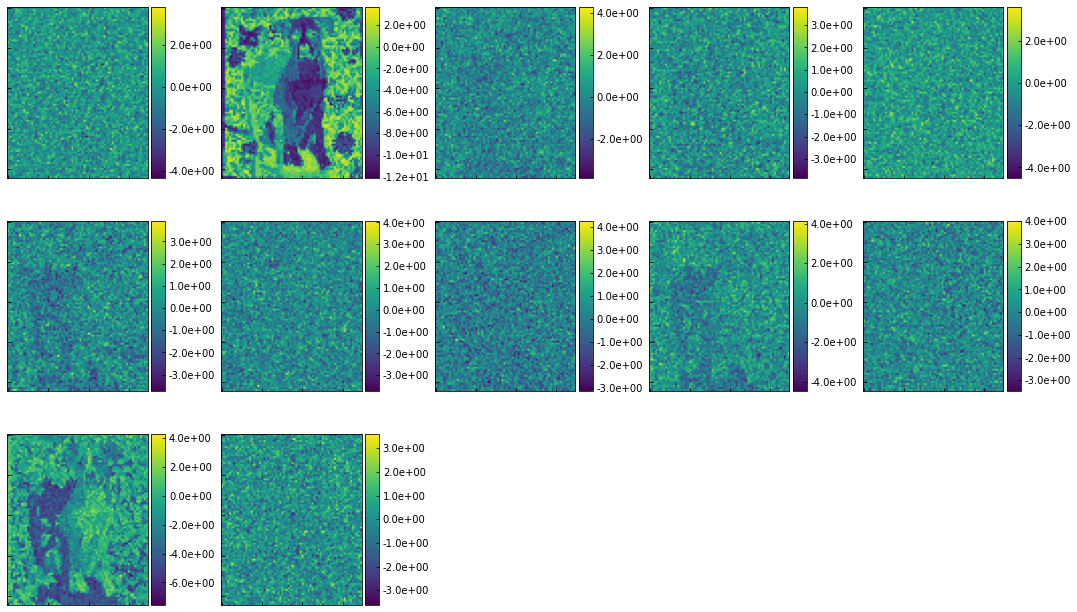

In [53]:
embedding_maps(encoded_spectra, image)

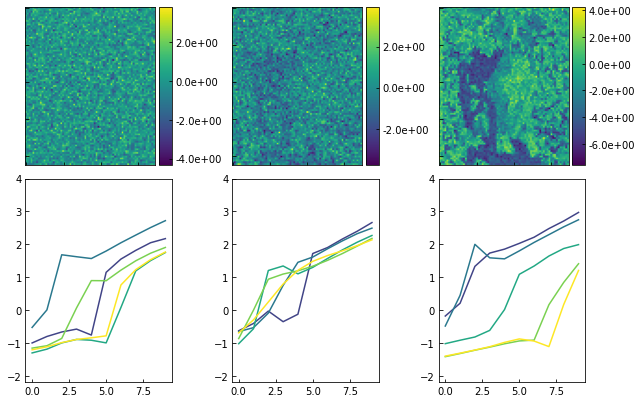

In [54]:
latent_generator(decoder, encoded_spectra, image, 5, 10, indx=[0, 5, 10], device=device)

- disentanglement with $\beta$ VAE requires careful control of optimiztion.
